In [5]:
import numpy as np
import pandas
import torch
import neuralnetworks_torch as nntorch
import os
import time
import matplotlib.pyplot as plt
import sklearn
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import scipy
from scipy.spatial.distance import cosine as cos_dist

In [6]:
class CNN1D(torch.nn.Module):

    def __init__(self, n_inputs, n_channels, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, n_outputs,
                 patch_size_per_conv_layer, stride_per_conv_layer, activation_function='tanh', device='cpu'):

        super().__init__()

        self.device = device

        n_conv_layers = len(n_hiddens_per_conv_layer)
        if (len(patch_size_per_conv_layer) != n_conv_layers
            or len(stride_per_conv_layer) != n_conv_layers):
            raise Exception('The lengths of n_hiddens_per_conv_layer, patch_size_per_conv_layer, and stride_per_conv_layer must be equal.')

        self.activation_function = torch.tanh if activation_function == 'tanh' else torch.relu

        self.make_conv_and_fc_layers(n_inputs, n_channels, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, n_outputs,
                                     patch_size_per_conv_layer, stride_per_conv_layer)
        
        self.Xmeans = None
        self.to(self.device)

    def make_conv_and_fc_layers(self, n_inputs, n_channels, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer,
                                n_outputs, patch_size_per_conv_layer, stride_per_conv_layer):
        # Create all convolutional layers
        # First argument to first Conv2d is number of channels for each pixel.
        # Just 1 for our grayscale images.
        n_in = n_channels
        input_hw = n_inputs  # original input image height (=width because image assumed square)
        self.conv_layers = torch.nn.ModuleList()
        layeri = 0
        for nh, patch_size, stride in zip(n_hiddens_per_conv_layer,
                                          patch_size_per_conv_layer,
                                          stride_per_conv_layer):
            self.conv_layers.append(torch.nn.Conv1d(n_in, nh, kernel_size=patch_size, stride=stride))
            conv_layer_output_hw = (input_hw - patch_size) // stride + 1
            print(input_hw,patch_size,stride,conv_layer_output_hw)
            if conv_layer_output_hw <= 0:
                raise Exception(f'''For conv layer {layeri}, input_hw of {input_hw} is less than patch_size {patch_size}.
Try reducing the patch_size for this layer or for the previous layer.''')
            input_hw = conv_layer_output_hw  # for next trip through this loop
            n_in = nh
            layeri += 1
           
        # Create all fully connected layers.  First must determine number of inputs to first
        # fully-connected layer that results from flattening the images coming out of the last
        # convolutional layer.
        n_in = input_hw * n_in
        self.fc_layers = torch.nn.ModuleList()
        for nh in n_hiddens_per_fc_layer:
            self.fc_layers.append(torch.nn.Linear(n_in, nh))
            n_in = nh
        self.fc_layers.append(torch.nn.Linear(n_in, n_outputs))

    def forward_all_outputs(self, X):
        n_samples = X.shape[0]
        Ys = [X]
        for conv_layer in self.conv_layers:
            Ys.append(self.activation_function(conv_layer(Ys[-1])))

        flattened_input = Ys[-1].reshape(n_samples, -1)

        for layeri, fc_layer in enumerate(self.fc_layers[:-1]):
            if layeri == 0:
                Ys.append(self.activation_function(fc_layer(flattened_input)))
            else:
                Ys.append(self.activation_function(fc_layer(Ys[-1])))

        if len(self.fc_layers) == 1:
            # only the output layer
            Ys.append(self.fc_layers[-1](flattened_input))
        else:
            Ys.append(self.fc_layers[-1](Ys[-1]))

        return Ys

    def forward(self, X):
        Ys = self.forward_all_outputs(X)
        return Ys[-1]

    def train(self, X, T, batch_size, n_epochs, learning_rate, method='sgd', verbose=True):
        '''X and T must be numpy arrays'''

        self.classes = np.unique(T)
        T = np.arange(len(self.classes))[np.where(T.reshape(-1, 1) == self.classes)[1]]

        # Set data matrices to torch.tensors
        X = torch.from_numpy(X).float().to(self.device)
        T = torch.from_numpy(T).long().to(self.device)  # required for classification in pytorch

        # Setup standardization parameters
        if self.Xmeans is None:
            self.Xmeans = X.mean(axis=0)
            self.Xstds = X.std(axis=0)
            self.Xstds[self.Xstds == 0] = 1  # So we don't divide by zero when standardizing

        # Standardize X
        X = (X - self.Xmeans) / self.Xstds
        
        X.requires_grad_(True)

        if method == 'sgd':
            optimizer = torch.optim.SGD(self.parameters(), lr=learning_rate, momentum=0.9)
        else:
            optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)

        CELoss = torch.nn.CrossEntropyLoss(reduction='mean')
        self.error_trace = []

        for epoch in range(n_epochs):

            num_batches = X.shape[0] // batch_size
            loss_sum = 0

            for k in range(num_batches):
                start = k * batch_size
                end = (k + 1) * batch_size
                X_batch = X[start:end, ...]
                T_batch = T[start:end, ...]

                Y = self.forward(X_batch)

                loss = CELoss(Y, T_batch)
                loss.backward()

                # Update parameters
                optimizer.step()
                optimizer.zero_grad()

                loss_sum += loss

            self.error_trace.append(loss_sum / num_batches)

            if verbose and (epoch + 1) % (max(1, n_epochs // 10)) == 0:
                print(f'{method}: Epoch {epoch + 1} Loss {self.error_trace[-1]:.3f}')

        return self

    def softmax(self, Y):
        '''Apply to final layer weighted sum outputs'''
        # Trick to avoid overflow
        maxY = torch.max(Y, axis=1)[0].reshape((-1, 1))
        expY = torch.exp(Y - maxY)
        denom = torch.sum(expY, axis=1).reshape((-1, 1))
        Y = expY / denom
        return Y

    def use(self, X):
        # Set input matrix to torch.tensors
        X = torch.from_numpy(X).float().to(self.device)
        # Standardize X
        X = (X - self.Xmeans) / self.Xstds
        # Calculate output of net for all samples in X
        Y = self.forward(X)
        # Convert output to class probabilities
        probs = self.softmax(Y)
        # For each sample pick highest probability and translate that to class labels
        classes = self.classes[torch.argmax(probs, axis=1).cpu().numpy()].reshape(-1, 1)
        return classes, probs.detach().cpu().numpy()

In [7]:
def pad(data):
    eps = np.unique(data[:,0])
    samples = data
    padded = samples.copy()
    for i in eps:
        count = np.count_nonzero(samples[:,0] == i)
        if count < 10:
            max_idx = np.max(np.where(padded[:,0] == i)[0])
            #print(i,10-count,max_idx)
            for j in range(10-count):
                #print("Inserting %s at %s" % (padded[max_idx][0], max_idx+1+j))
                padded = np.insert(padded,max_idx+1+j,padded[max_idx],axis=0)
                #print(j,padded.shape)
                
    return padded

In [8]:
def make_train_test_data(classes, crop_len, feature_idxs):
    subset = crop_len

    Xtrain = np.vstack([train_data[c][:subset] for c in classes])[:,feature_idxs]
    Ttrain = np.vstack([train_data[c][:subset] for c in classes])[:,1]
    Xtrain = Xtrain.reshape(Xtrain.shape[0],-1)

    Xtest = np.vstack([test_data[c] for c in classes])[:,feature_idxs]
    Ttest = np.vstack([test_data[c] for c in classes])[:,1]

    n_channels = Xtrain.shape[1]
    print(Xtrain.shape,Ttrain.shape,Xtest.shape,Ttest.shape)

    Xtrain = Xtrain.flatten().reshape(-1,int(Xtrain.shape[1]*10)) # group into 10s
    Ttrain = np.max(Ttrain.flatten().reshape(-1,10), axis=1)

    Xtest = Xtest.flatten().reshape(-1,int(Xtest.shape[1]*10))
    Ttest = np.max(Ttest.flatten().reshape(-1,10), axis=1)
    print(Xtrain.shape,Ttrain.shape,Xtest.shape,Ttest.shape)

    Xtrain = Xtrain.reshape(-1,1,n_channels*10)
    Xtest = Xtest.reshape(-1,1,n_channels*10)

    print(Xtrain.shape,Ttrain.shape,Xtest.shape,Ttest.shape)

    return Xtrain,Ttrain,Xtest,Ttest

In [34]:
def train_classifier(X, T, n_classes, pretrained=None):
    gpu = True
    device = 'cpu'
    if gpu:
        if not torch.cuda.is_available():
            print("CUDA not available. Defaulting to CPU.")
        else:
            device = 'cuda:0'

    n_channels = X.shape[-1]//10
    
    cnn1d = CNN1D(n_channels*10, 1, [256, 128], [64, 64], n_classes, [n_channels, 4], [8, 2], device=device)
    
    #print(cnn1d.fc_layers[0].weight)
    
    with torch.no_grad():
        if pretrained is not None:
            for i in range(len(pretrained[0])):
                #print("Replacing %s with %s" % (cnn1d.conv_layers[i].weight,\
                #                                torch.nn.Parameter(pretrained[0][i])))
                cnn1d.conv_layers[i].weight = torch.nn.Parameter(pretrained[0][i])
            for i in range(len(pretrained[1])):
                #print("Replacing %s with %s" % (cnn1d.fc_layers[i].weight,\
                #                                torch.nn.Parameter(pretrained[1][i])))
                cnn1d.fc_layers[i].weight = torch.nn.Parameter(pretrained[1][i])
        cnn1d.fc_layers[-1].weight = nn.init.xavier_uniform_(cnn1d.fc_layers[-1].weight)

    n_epochs = 500
    batch_size = 100
    learning_rate = 0.001

    cnn1d.train(X, T, batch_size, n_epochs, learning_rate, method='adam')
    
    #print(cnn1d.fc_layers[0].weight)
    
    return cnn1d

In [10]:
# try some new data
# (load all samples from padded_data because we don't care about a balanced set for testing on new object types)
# 2 = cylinders (3 = capsules; 4 = small cubes)
def compare_classes(model, n_channels, novelty_threshold=25):
    novelty = []
    dissimilarities = []
    outlier_ratios = []
    for i in range(5):
        new_data_class = i
        Xnew = np.vstack([padded_data[new_data_class]])[:,feature_idxs]
        Xnew = Xnew.flatten().reshape(-1,int(Xnew.shape[1]*10))
        Xnew = Xnew.reshape(-1,1,n_channels*10)

        print("New class:", new_data_class)

        # get most similar class
        classes, _ = model.use(Xnew)
        most_similar_class = int(scipy.stats.mode(classes).mode.item())
        print("Most similar class:", most_similar_class)

        # get embedding vectors of the new samples
        newYs = model.forward_all_outputs(torch.from_numpy(Xnew).float())
        new_logits = newYs[-2].detach().numpy()

        #print(np.var(new_logits, axis=0))
        #print(np.var(new_logits, axis=0).shape)
        #print("New data vector variance:", np.sum(np.var(new_logits, axis=0)))

        # get embedding vectors of the known class samples
        Xsim = np.vstack([padded_data[most_similar_class]])[:,feature_idxs]
        Xsim = Xsim.flatten().reshape(-1,int(Xsim.shape[1]*10))
        Xsim = Xsim.reshape(-1,1,n_channels*10)

        simYs = model.forward_all_outputs(torch.from_numpy(Xsim).float())
        sim_logits = simYs[-2].detach().numpy()

        #print(np.mean(new_logits, axis=0))
        #print(np.mean(sim_logits, axis=0))
        new_mean = np.mean(new_logits, axis=0)
        sim_mean = np.mean(sim_logits, axis=0)
        #print(new_mean-sim_mean)

        new_std = np.std(new_logits, axis=0)
        sim_std = np.std(sim_logits, axis=0)
        #print(sim_variance)

        print("Angle from sim_mean to sim_mean+std:",cos_dist(sim_mean,sim_mean+sim_std))
        #print("Angle from sim_mean to sim_mean-var:",cos_dist(sim_mean,sim_mean-sim_variance))
        print("Angle from sim_mean to new_mean:", cos_dist(sim_mean,new_mean))
        #print("Angle from new_mean to new_mean+std:", cos_dist(new_mean,new_mean+new_std))
        #print("Angle from sim_mean to new_mean+std:", cos_dist(sim_mean,new_mean+new_std))
        #print("Angle from sim_mean to new_mean-std:", cos_dist(sim_mean,new_mean-new_std))
        #min_diff_angle = np.min([cos_dist(sim_mean,new_mean+new_std),cos_dist(sim_mean,new_mean-new_std)])
        #max_diff_angle = np.max([cos_dist(sim_mean,new_mean+new_std),cos_dist(sim_mean,new_mean-new_std)])
        #print("Max angle from sim_mean to new_mean+/-std", max_diff_angle)
        #print("Max angle/angle from sim_mean to sim_mean+std:", max_diff_angle/cos_dist(sim_mean,sim_mean+sim_std))
        print("Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std:",\
              cos_dist(sim_mean,new_mean)/cos_dist(sim_mean,sim_mean+sim_std))
        likely_novel_class = cos_dist(sim_mean,new_mean)/cos_dist(sim_mean,sim_mean+sim_std) > 0
        #print(likely_novel_class)

        outlier_threshold = 1
        z_threshold = 3
        
        new_outliers = []
        for i in range(len(new_logits)):
            if cos_dist(sim_mean,new_logits[i])/cos_dist(sim_mean,sim_mean+sim_std) > outlier_threshold:
                #print(i,cos_dist(sim_mean,new_logits[i])/cos_dist(sim_mean,sim_mean+sim_std))
                new_outliers.append(cos_dist(sim_mean,new_logits[i])/cos_dist(sim_mean,sim_mean+sim_std))
        #print(len(new_outliers))
        #print(np.mean([new_outliers]),np.std([new_outliers]))
        new_outliers_pruned = []
        for i in range(len(new_outliers)):
            if (new_outliers[i]-np.mean([new_outliers]))/np.std([new_outliers]) < z_threshold:
                #print(new_outliers[i])
                new_outliers_pruned.append(new_outliers[i])
        #print(len(new_outliers_pruned))
        #print()
        
        sim_outliers = []
        for i in range(len(sim_logits)):
            if cos_dist(sim_mean,sim_logits[i])/cos_dist(sim_mean,sim_mean+sim_std) > outlier_threshold:
                #print(i,cos_dist(sim_mean,sim_logits[i])/cos_dist(sim_mean,sim_mean+sim_std))
                sim_outliers.append(cos_dist(sim_mean,sim_logits[i])/cos_dist(sim_mean,sim_mean+sim_std))
        #print(len(sim_outliers))
        #print(np.mean([sim_outliers]),np.std([sim_outliers]))
        sim_outliers_pruned = []
        for i in range(len(sim_outliers)):
            if (sim_outliers[i]-np.mean([sim_outliers]))/np.std([sim_outliers]) < z_threshold:
                #print(sim_outliers[i])
                sim_outliers_pruned.append(sim_outliers[i])
        #print(len(sim_outliers_pruned))
                
        #print(np.sum(new_outliers_pruned),np.sum(sim_outliers_pruned))
        outlier_ratio = np.sum(new_outliers_pruned)/np.sum(sim_outliers_pruned) \
              if np.sum(sim_outliers_pruned) > 0 else float('inf')
        print("Outlier ratio:",outlier_ratio)
        likely_novel_class = (outlier_ratio == float('inf')) if likely_novel_class else likely_novel_class
        
        dissimilarity = outlier_ratio*cos_dist(sim_mean,new_mean)/cos_dist(sim_mean,sim_mean+sim_std)*\
        np.sum(sim_outliers)
        print("Dissimilarity from most similar class:", dissimilarity)

        likely_novel_class = (dissimilarity > novelty_threshold) if not likely_novel_class else likely_novel_class
        #likely_novel_class = outlier_ratio > novelty_threshold
        print("Likely novel class:",likely_novel_class)
        
        print()
        
        outlier_ratios.append(outlier_ratio)
        dissimilarities.append(dissimilarity)
        novelty.append(likely_novel_class)
        
    return novelty,dissimilarities,outlier_ratios

Column key:
* Column 1 is the episode number.
* Column 2 is the theme object;  0 = big cube, 1 = sphere, 2 = cylinder, 3 = capsule, 4 = small cube.
* Column 3 is the destination object.  Always 0 because we were always stacking on a cube.
* Columns 4-6 are the rotation (4 = X; 5 = Y; 6 = Z) of the theme object at the start of the trial, in radians.
* Column 7 is the angle, theta (in radians), between the vertical upright axis in world space (0,1,0), and the normalized intrinsic upward axis of the theme object at the start of the trial.
* Columns 8, 9 are the 2-dimensions of the action that was executed.
* Columns 10-12 are the rotation of the theme object after the action was completed (same convention as 4-6), in radians.
* Column 13 is the theta angle, as in 7, but after action was completed.
* Column 14-16 is the "jitter" force applied to the object after placement (to simulate release)
* Columns 17-19 is the center of the theme object (after action completion)
* Columns 20-22 is the size of the theme object
* Column 23-25 is the observation after action completion. Here I’m using height and center of gravity so it takes up 3 columns
* Column 26 is the reward. With this model, the agent gets -1 for missing the destination object entirely, 9 for touching the destination object but the theme falls off, and up to 1000 for successful stacking (1000 on the first try, -100 for each additional attempt).
* Column 27 is the cumulative reward over the episode.
* Column 28 is the mean reward over the episode.

In [11]:
# load up data
data = {}
data[0] = pandas.read_csv('trial-data/122521-2cubes.csv', header=None)
data[0] = data[0][data[0].iloc[:,1] == 0]

data[1] = pandas.read_csv('trial-data/122521-cube_sphere.csv', header=None)
data[1] = data[1][data[1].iloc[:,1] == 1]

data[2] = pandas.read_csv('trial-data/122521-cube_cylinder.csv', header=None)
data[2] = data[2][data[2].iloc[:,1] == 2]

data[3] = pandas.read_csv('trial-data/122521-cube_capsule.csv', header=None)
data[3] = data[3][data[3].iloc[:,1] == 3]

data[4] = pandas.read_csv('trial-data/122521-bigcube_smallcube.csv', header=None)
data[4] = data[4][data[4].iloc[:,1] == 4]

In [12]:
# pad data
padded_data = {}
padded_data[0] = pad(data[0].to_numpy())
padded_data[1] = pad(data[1].to_numpy())
padded_data[2] = pad(data[2].to_numpy())
padded_data[3] = pad(data[3].to_numpy())
padded_data[4] = pad(data[4].to_numpy())

test_n = 100 # 100 test samples of each class

# split train and test
test_data = {}
test_data[0] = padded_data[0][-test_n:]
test_data[1] = padded_data[1][-test_n:]
test_data[2] = padded_data[2][-test_n:]
test_data[3] = padded_data[3][-test_n:]
test_data[4] = padded_data[4][-test_n:]

crop_len = min([len(padded_data[k]) for k in padded_data])-test_n

print(crop_len)

train_data = {}
train_data[0] = padded_data[0][:crop_len]
train_data[1] = padded_data[1][:crop_len]
train_data[2] = padded_data[2][:crop_len]
train_data[3] = padded_data[3][:crop_len]
train_data[4] = padded_data[4][:crop_len]

for k in train_data:
    print(train_data[k].shape,train_data[k])

900
(900, 28) [[   3.    0.    0. ... 1000. 1000. 1000.]
 [   3.    0.    0. ... 1000. 1000. 1000.]
 [   3.    0.    0. ... 1000. 1000. 1000.]
 ...
 [  92.    0.    0. ... 1000. 1000. 1000.]
 [  92.    0.    0. ... 1000. 1000. 1000.]
 [  92.    0.    0. ... 1000. 1000. 1000.]]
(900, 28) [[ 3.        1.        0.       ...  9.        9.        9.      ]
 [ 3.        1.        0.       ... -1.        8.        4.      ]
 [ 3.        1.        0.       ...  9.       17.        5.666667]
 ...
 [92.        1.        0.       ...  9.       42.        5.25    ]
 [92.        1.        0.       ...  9.       51.        5.666667]
 [92.        1.        0.       ...  9.       60.        6.      ]]
(900, 28) [[   3.    2.    0. ... 1000. 1000. 1000.]
 [   3.    2.    0. ... 1000. 1000. 1000.]
 [   3.    2.    0. ... 1000. 1000. 1000.]
 ...
 [  92.    2.    0. ... 1000. 1000. 1000.]
 [  92.    2.    0. ... 1000. 1000. 1000.]
 [  92.    2.    0. ... 1000. 1000. 1000.]]
(900, 28) [[ 3.        3.     

In [30]:
def get_initial_weights(n_channels, n_classes):
    model = CNN1D(n_channels*10, 1, [256, 128], [64, 64], n_classes, [n_channels, 4], [8, 2])
    
    with torch.no_grad():
        weights = [[],[]]
        for i in range(len(model.conv_layers)):
            nn.init.xavier_normal_(model.conv_layers[i].weight)
            weights[0].append(model.conv_layers[i].weight.detach())
        for i in range(len(model.fc_layers)-1):
            nn.init.xavier_normal_(model.fc_layers[i].weight)
            weights[1].append(model.fc_layers[i].weight.detach())

        print(weights)
    
    return weights

In [31]:
initial_weights = get_initial_weights(Xtrain.shape[-1]//10, 2)

190 19 8 22
22 4 2 10
[[tensor([[[ 0.0019,  0.0286,  0.0042,  ...,  0.0322,  0.0216,  0.0142]],

        [[ 0.0258, -0.0140, -0.0080,  ..., -0.0352, -0.0155, -0.0281]],

        [[ 0.0139,  0.0023,  0.0403,  ..., -0.0022, -0.0292, -0.0229]],

        ...,

        [[-0.0026, -0.0103, -0.0119,  ..., -0.0407, -0.0284, -0.0025]],

        [[-0.0133, -0.0161, -0.0018,  ...,  0.0081, -0.0284, -0.0054]],

        [[ 0.0508,  0.0014,  0.0035,  ..., -0.0022,  0.0550, -0.0284]]]), tensor([[[ 0.0600, -0.0266, -0.0341, -0.0802],
         [-0.0284, -0.0479,  0.0190,  0.0220],
         [-0.0140, -0.0221,  0.0180,  0.0165],
         ...,
         [-0.0043,  0.0321, -0.1064,  0.0923],
         [ 0.0357, -0.0458,  0.0069,  0.0589],
         [-0.0103, -0.0153,  0.0715, -0.0584]],

        [[-0.0107, -0.0149,  0.0177, -0.0275],
         [-0.0118,  0.0145,  0.0318,  0.0155],
         [ 0.0320,  0.0030, -0.0320, -0.0259],
         ...,
         [ 0.0475,  0.0299,  0.0329, -0.0164],
         [-0.0042, -0.0

# A: Given cube and sphere

Test for the ability to infer the existence of cylinder and capsule as distinct classes while not splitting small cube from big cube.

========== Experiment 1 ==========
(1800, 19) (1800,) (200, 19) (200,)
(180, 190) (180,) (20, 190) (20,)
(180, 1, 190) (180,) (20, 1, 190) (20,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.001
adam: Epoch 100 Loss 0.000
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0019835233688354492
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.003871023654937744
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimil

Angle from sim_mean to sim_mean+std: 0.0043392181396484375
Angle from sim_mean to new_mean: 1.0788440704345703e-05
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0024862637362637365
Outlier ratio: 1.264941958349393
Dissimilarity from most similar class: 0.988345434579157
Likely novel class: False

========== Experiment 5 ==========
(1800, 19) (1800,) (200, 19) (200,)
(180, 190) (180,) (20, 190) (20,)
(180, 1, 190) (180,) (20, 1, 190) (20,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.000
adam: Epoch 100 Loss 0.000
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0017835497856140137
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 

Angle from sim_mean to sim_mean+std: 0.002400815486907959
Angle from sim_mean to new_mean: 1.2576580047607422e-05
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.005238461729437175
Outlier ratio: 1.5105890906537982
Dissimilarity from most similar class: 1.5558774963877677
Likely novel class: False

========== Experiment 9 ==========
(1800, 19) (1800,) (200, 19) (200,)
(180, 190) (180,) (20, 190) (20,)
(180, 1, 190) (180,) (20, 1, 190) (20,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.001
adam: Epoch 100 Loss 0.000
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.005699634552001953
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0

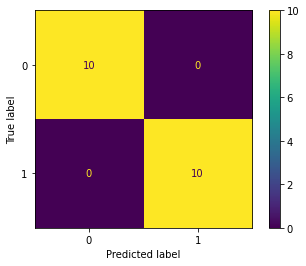

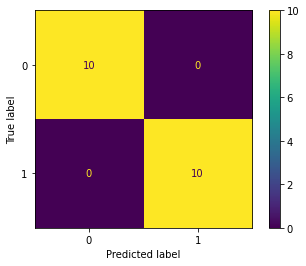

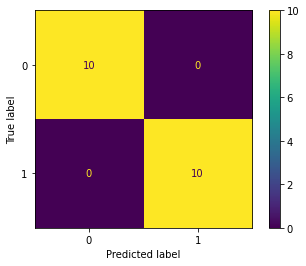

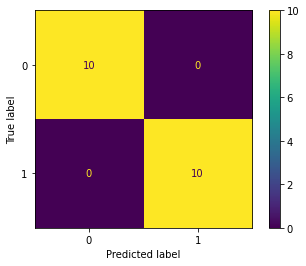

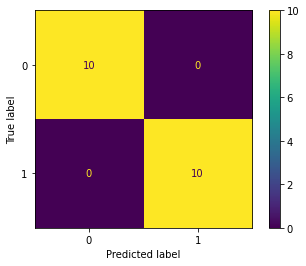

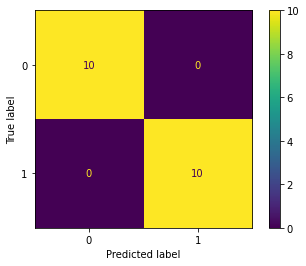

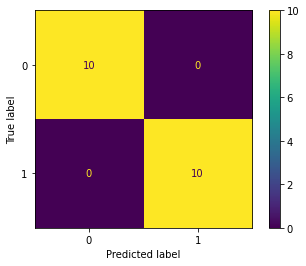

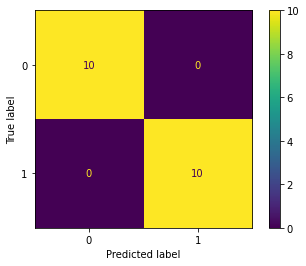

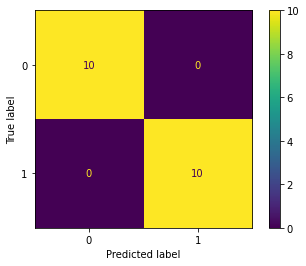

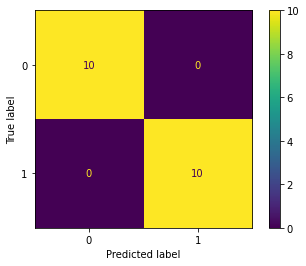

In [93]:
ground_truth = [False, False, True, True, False]
novelty_judgments = []
n_exps = 10

for i in range(n_exps):
    print("========== Experiment %s ==========" % str(i+1))
    
    feature_idxs = [*range(3,16),*range(22,28)] 
    #feature_idxs = [*range(3,13),*range(22,28)] # without jitter force
    #feature_idxs = [*range(3,19),*range(22,28)] # with object position
    Xtrain, Ttrain, Xtest, Ttest = make_train_test_data([0,1], crop_len, feature_idxs)
    print()

    model = train_classifier(Xtrain, Ttrain, 2, pretrained=inital_weights)
    print()

    # check classifier on the test data
    classes, probs = model.use(Xtest)

    # make confusion matrix
    cm = sklearn.metrics.confusion_matrix(Ttest, classes)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()

    novel_classes, dissimilarities = compare_classes(model, Xtrain.shape[-1]//10)
    novelty_judgments.append(novel_classes)
    
novelty_judgments = np.array(novelty_judgments).reshape(n_exps,-1).T

pred_acc = []
for i in range(2,len(ground_truth)):
    pred_acc.append(np.sum(novelty_judgments[i] == ground_truth[i])/n_exps)
    print(ground_truth[i], novelty_judgments[i], pred_acc[-1])
    
print(pred_acc, np.mean(pred_acc))

# B: Given cube, sphere, and cylinder

Test for the ability to infer the existence of capsule as a distinct class while not splitting small cube from big cube.

========== Experiment 1 ==========
(2700, 19) (2700,) (300, 19) (300,)
(270, 190) (270,) (30, 190) (30,)
(270, 1, 190) (270,) (30, 1, 190) (30,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.047
adam: Epoch 100 Loss 0.021
adam: Epoch 150 Loss 0.015
adam: Epoch 200 Loss 0.013
adam: Epoch 250 Loss 0.011
adam: Epoch 300 Loss 0.010
adam: Epoch 350 Loss 0.009
adam: Epoch 400 Loss 0.009
adam: Epoch 450 Loss 0.008
adam: Epoch 500 Loss 0.008

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.00028586387634277344
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0007625222206115723
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissim

adam: Epoch 50 Loss 0.041
adam: Epoch 100 Loss 0.019
adam: Epoch 150 Loss 0.014
adam: Epoch 200 Loss 0.012
adam: Epoch 250 Loss 0.010
adam: Epoch 300 Loss 0.010
adam: Epoch 350 Loss 0.009
adam: Epoch 400 Loss 0.008
adam: Epoch 450 Loss 0.008
adam: Epoch 500 Loss 0.008

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0007848739624023438
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0021735429763793945
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 2
Angle from sim_mean to sim_mean+std: 0.006443321704864502
Angle from sim_mean to new_mean: 0.0
Angle from sim

adam: Epoch 50 Loss 0.043
adam: Epoch 100 Loss 0.019
adam: Epoch 150 Loss 0.014
adam: Epoch 200 Loss 0.011
adam: Epoch 250 Loss 0.010
adam: Epoch 300 Loss 0.009
adam: Epoch 350 Loss 0.009
adam: Epoch 400 Loss 0.008
adam: Epoch 450 Loss 0.008
adam: Epoch 500 Loss 0.008

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0008268952369689941
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0006233453750610352
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 2
Angle from sim_mean to sim_mean+std: 0.0010946393013000488
Angle from sim_mean to new_mean: 0.0
Angle from si

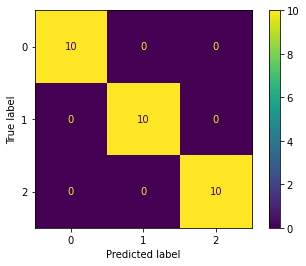

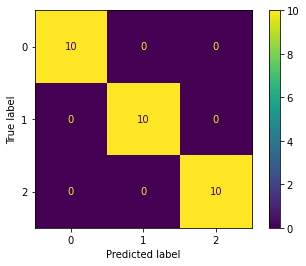

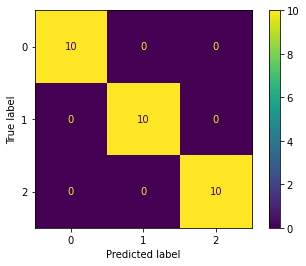

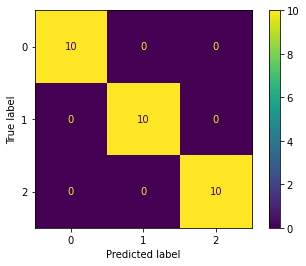

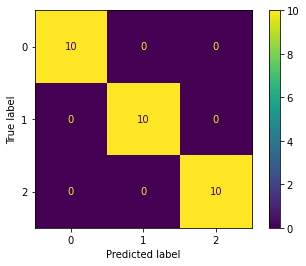

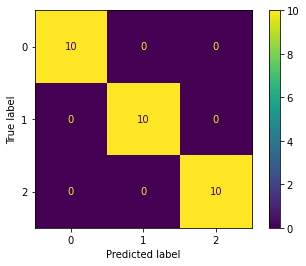

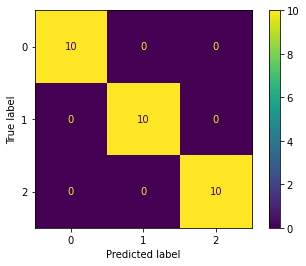

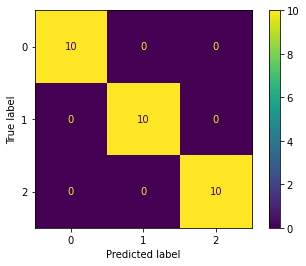

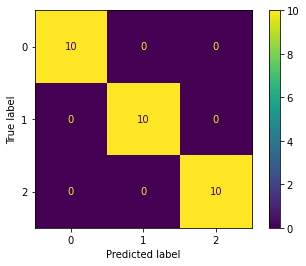

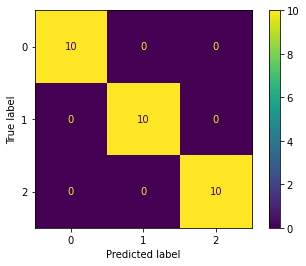

In [42]:
ground_truth = [False, False, False, True, False]
novelty_judgments = []
n_exps = 10

for i in range(n_exps):
    print("========== Experiment %s ==========" % str(i+1))

    feature_idxs = [*range(3,16),*range(22,28)]
    #feature_idxs = [*range(3,13),*range(22,28)] # without jitter force
    #feature_idxs = [*range(3,19),*range(22,28)] # with object position
    Xtrain, Ttrain, Xtest, Ttest = make_train_test_data([0,1,2], crop_len, feature_idxs)
    print()

    model = train_classifier(Xtrain, Ttrain, 3)
    print()

    # check classifier on the test data
    classes, probs = model.use(Xtest)

    # make confusion matrix
    cm = sklearn.metrics.confusion_matrix(Ttest, classes)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()

    novel_classes, dissimilarities = compare_classes(model, Xtrain.shape[-1]//10)
    novelty_judgments.append(novel_classes)
    
novelty_judgments = np.array(novelty_judgments).reshape(n_exps,-1).T

pred_acc = []
for i in range(2,len(ground_truth)):
    pred_acc.append(np.sum(novelty_judgments[i] == ground_truth[i])/n_exps)
    print(ground_truth[i], novelty_judgments[i], pred_acc[-1])
    
print(pred_acc, np.mean(pred_acc))

# C: Given cube, sphere, and capsule

Test for the ability to infer the existence of cylinder as a distinct class while not splitting small cube from big cube.

========== Experiment 1 ==========
(2700, 19) (2700,) (300, 19) (300,)
(270, 190) (270,) (30, 190) (30,)
(270, 1, 190) (270,) (30, 1, 190) (30,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.013
adam: Epoch 100 Loss 0.003
adam: Epoch 150 Loss 0.002
adam: Epoch 200 Loss 0.001
adam: Epoch 250 Loss 0.001
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.014282941818237305
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0009968876838684082
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimil

adam: Epoch 50 Loss 0.012
adam: Epoch 100 Loss 0.003
adam: Epoch 150 Loss 0.002
adam: Epoch 200 Loss 0.001
adam: Epoch 250 Loss 0.001
adam: Epoch 300 Loss 0.001
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.01308983564376831
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.001265883445739746
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.01308983564376831
Angle from sim_mean to new_mean: 4.178285598754883e-05


adam: Epoch 50 Loss 0.011
adam: Epoch 100 Loss 0.003
adam: Epoch 150 Loss 0.002
adam: Epoch 200 Loss 0.001
adam: Epoch 250 Loss 0.001
adam: Epoch 300 Loss 0.001
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.017429769039154053
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0012916326522827148
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.017429769039154053
Angle from sim_mean to new_mean: 0.00020653009414672

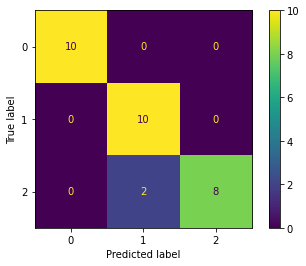

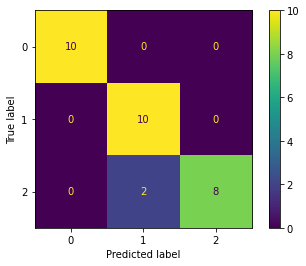

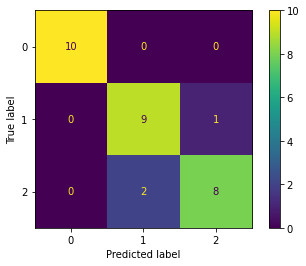

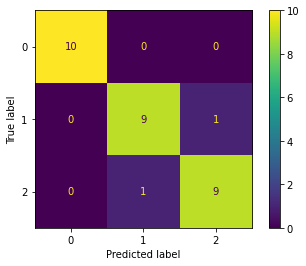

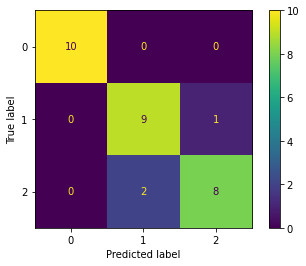

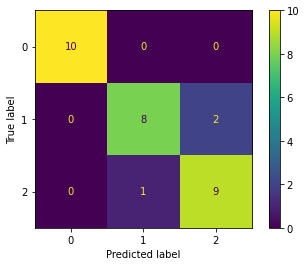

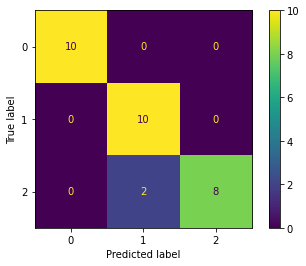

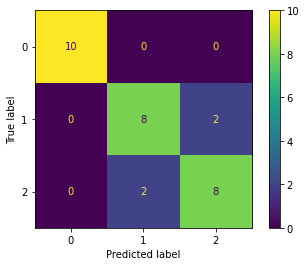

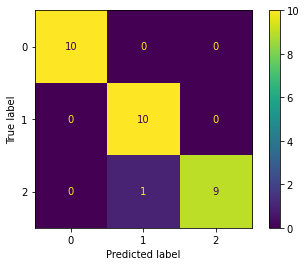

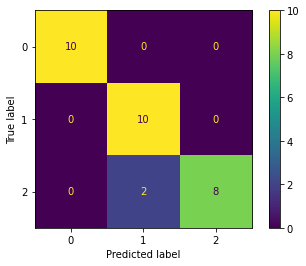

In [43]:
ground_truth = [False, False, True, False, False]
novelty_judgments = []
n_exps = 10

for i in range(n_exps):
    print("========== Experiment %s ==========" % str(i+1))
    
    feature_idxs = [*range(3,16),*range(22,28)]
    #feature_idxs = [*range(3,13),*range(22,28)] # without jitter force
    #feature_idxs = [*range(3,19),*range(22,28)] # with object position
    Xtrain, Ttrain, Xtest, Ttest = make_train_test_data([0,1,3], crop_len, feature_idxs)
    print()

    model = train_classifier(Xtrain, Ttrain, 3)
    print()

    # check classifier on the test data
    classes, probs = model.use(Xtest)

    # make confusion matrix
    cm = sklearn.metrics.confusion_matrix(Ttest, classes)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()

    novel_classes, dissimilarities = compare_classes(model, Xtrain.shape[-1]//10)
    novelty_judgments.append(novel_classes)
    
novelty_judgments = np.array(novelty_judgments).reshape(n_exps,-1).T

pred_acc = []
for i in range(2,len(ground_truth)):
    pred_acc.append(np.sum(novelty_judgments[i] == ground_truth[i])/n_exps)
    print(ground_truth[i], novelty_judgments[i], pred_acc[-1])
    
print(pred_acc, np.mean(pred_acc))

# D: Given cube, sphere, cylinder, and capsule

Test that small cube is not considered to be different from big cube.

========== Experiment 1 ==========
(3600, 19) (3600,) (400, 19) (400,)
(360, 190) (360,) (40, 190) (40,)
(360, 1, 190) (360,) (40, 1, 190) (40,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.083
adam: Epoch 100 Loss 0.034
adam: Epoch 150 Loss 0.023
adam: Epoch 200 Loss 0.018
adam: Epoch 250 Loss 0.016
adam: Epoch 300 Loss 0.014
adam: Epoch 350 Loss 0.011
adam: Epoch 400 Loss 0.007
adam: Epoch 450 Loss 0.008
adam: Epoch 500 Loss 0.009

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0824851393699646
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0012874603271484375
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilar

adam: Epoch 50 Loss 0.079
adam: Epoch 100 Loss 0.033
adam: Epoch 150 Loss 0.023
adam: Epoch 200 Loss 0.019
adam: Epoch 250 Loss 0.016
adam: Epoch 300 Loss 0.016
adam: Epoch 350 Loss 0.012
adam: Epoch 400 Loss 0.012
adam: Epoch 450 Loss 0.012
adam: Epoch 500 Loss 0.009

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.008952677249908447
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0003172159194946289
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 2
Angle from sim_mean to sim_mean+std: 0.01848471164703369
Angle from sim_mean to new_mean: 0.0
Angle from sim_m

adam: Epoch 400 Loss 0.015
adam: Epoch 450 Loss 0.011
adam: Epoch 500 Loss 0.023

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.012508034706115723
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0006490945816040039
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 2
Angle from sim_mean to sim_mean+std: 0.026194453239440918
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 3
Most similar class: 3
Angle 

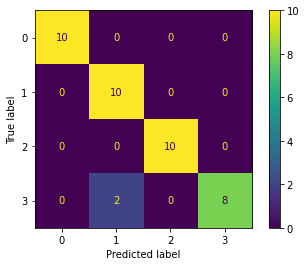

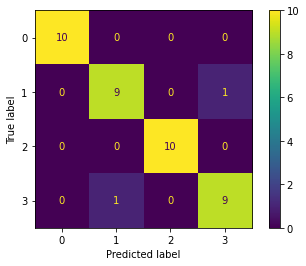

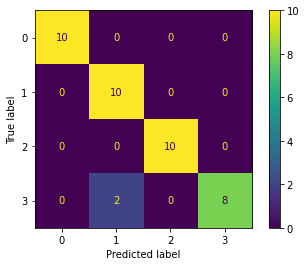

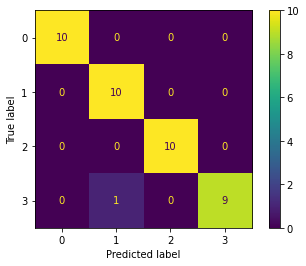

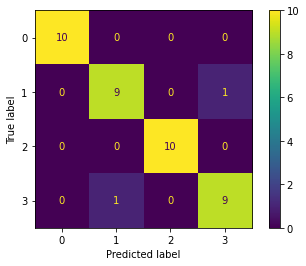

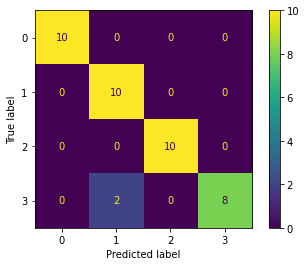

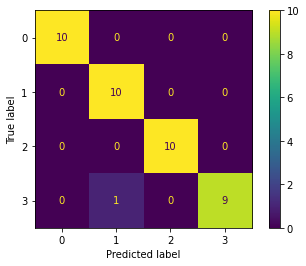

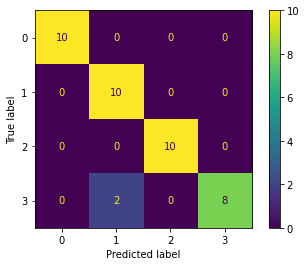

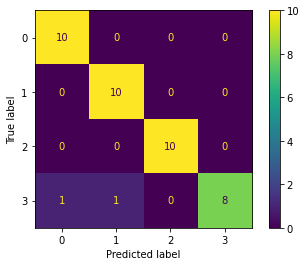

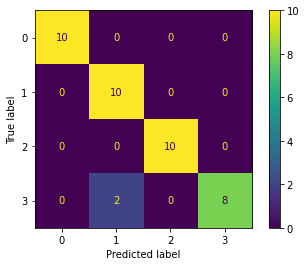

In [44]:
ground_truth = [False, False, False, False, False]
novelty_judgments = []
n_exps = 10

for i in range(n_exps):
    print("========== Experiment %s ==========" % str(i+1))
    
    feature_idxs = [*range(3,16),*range(22,28)]
    #feature_idxs = [*range(3,13),*range(22,28)] # without jitter force
    #feature_idxs = [*range(3,19),*range(22,28)] # with object position
    Xtrain, Ttrain, Xtest, Ttest = make_train_test_data([0,1,2,3], crop_len, feature_idxs)
    print()

    model = train_classifier(Xtrain, Ttrain, 4)
    print()

    # check classifier on the test data
    classes, probs = model.use(Xtest)

    # make confusion matrix
    cm = sklearn.metrics.confusion_matrix(Ttest, classes)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()

    novel_classes, dissimilarities = compare_classes(model, Xtrain.shape[-1]//10)
    novelty_judgments.append(novel_classes)
    
novelty_judgments = np.array(novelty_judgments).reshape(n_exps,-1).T

pred_acc = []
for i in range(2,len(ground_truth)):
    pred_acc.append(np.sum(novelty_judgments[i] == ground_truth[i])/n_exps)
    print(ground_truth[i], novelty_judgments[i], pred_acc[-1])
    
print(pred_acc, np.mean(pred_acc))

# E: Multi-class non-curriculum learning 1

Start with cube and sphere.  After each trial add the class that has inferred to have the *lowest*  dissimilarity from its most similar class *above the novelty threshold*.  Test for the ability to acquire cylinder and capsule as distinct classes while not splitting small cube from big cube.  With each additional class added, the model is retrained from scratch.

========== Experiment 1 ==========
Known classes: [0, 1]
(1800, 19) (1800,) (200, 19) (200,)
(180, 190) (180,) (20, 190) (20,)
(180, 1, 190) (180,) (20, 1, 190) (20,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.000
adam: Epoch 100 Loss 0.000
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.010188877582550049
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0017129778861999512
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outli

adam: Epoch 50 Loss 0.001
adam: Epoch 100 Loss 0.000
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0101395845413208
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.004990339279174805
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0101395845413208
Angle from sim_mean to new_mean: 7.975101470947266e-05
An

adam: Epoch 50 Loss 0.000
adam: Epoch 100 Loss 0.000
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.009365379810333252
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.003991901874542236
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.009365379810333252
Angle from sim_mean to new_mean: 4.6133995056152344e-

adam: Epoch 50 Loss 0.002
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.001
adam: Epoch 200 Loss 0.001
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.019963204860687256
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.001259922981262207
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.019963204860687256
Angle from sim_mean to new_mean: 9.113550186157227e-0

adam: Epoch 50 Loss 0.003
adam: Epoch 100 Loss 0.002
adam: Epoch 150 Loss 0.001
adam: Epoch 200 Loss 0.001
adam: Epoch 250 Loss 0.001
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.01695781946182251
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0014888644218444824
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.01695781946182251
Angle from sim_mean to new_mean: 7.76052474975586e-05


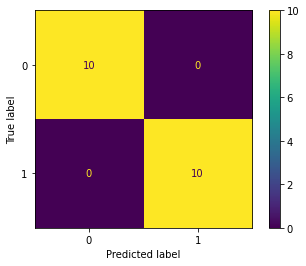

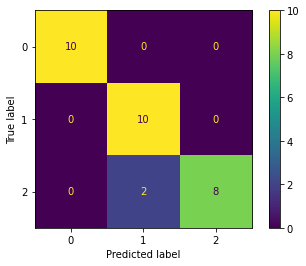

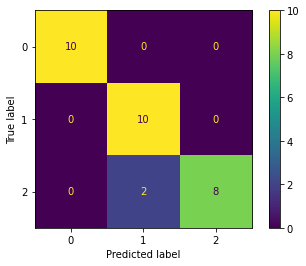

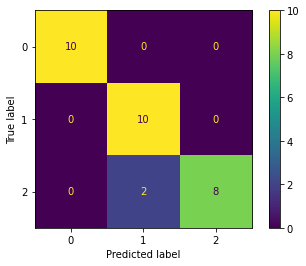

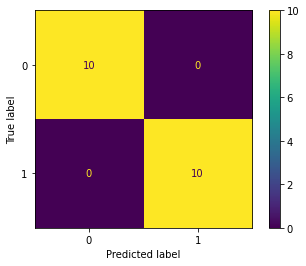

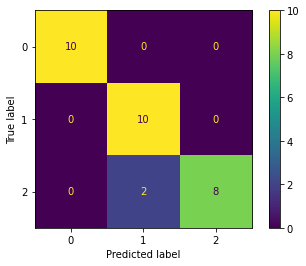

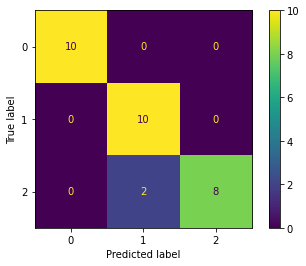

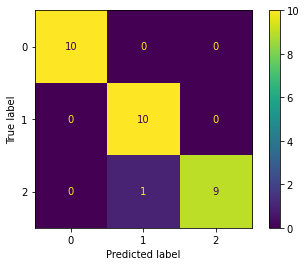

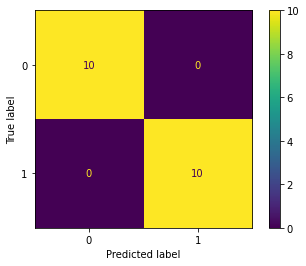

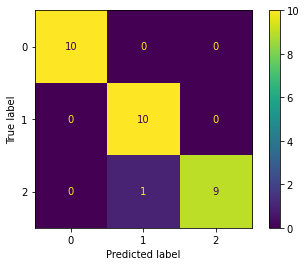

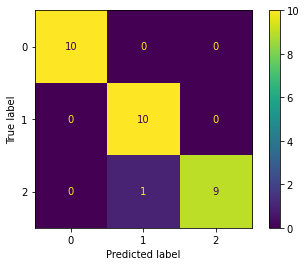

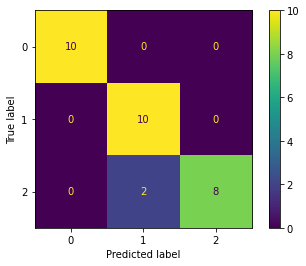

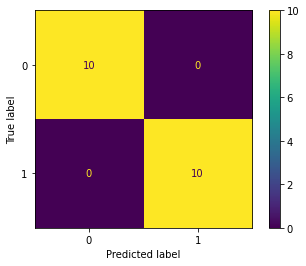

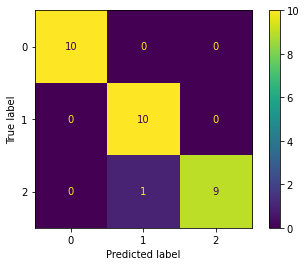

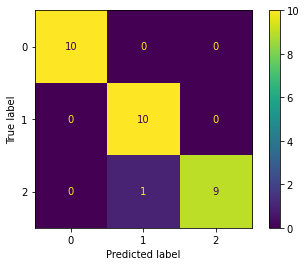

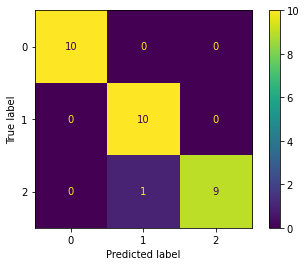

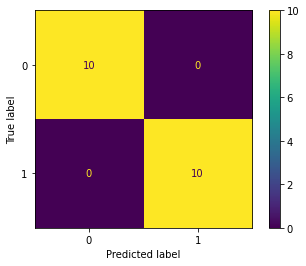

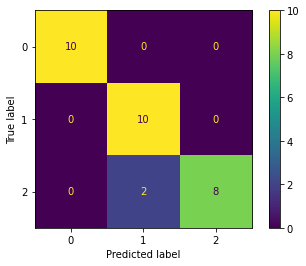

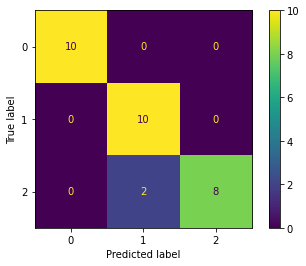

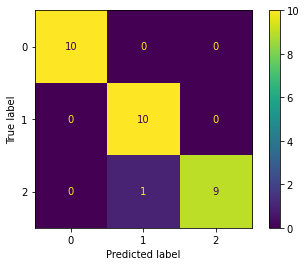

In [95]:
n_exps = 5

ground_truth = [0,1,2,3]

pred_iou = []
for i in range(n_exps):
    print("========== Experiment %s ==========" % str(i+1))
    known_classes = [0,1]
    known_classes_order = []
    
    model = None
    
    retrains = 0
    while len(known_classes) < len(ground_truth) and retrains < 2:
        print("Known classes:", known_classes)
        known_classes_order.append(known_classes.copy())
        
        feature_idxs = [*range(3,16),*range(22,28)]
        #feature_idxs = [*range(3,13),*range(22,28)] # without jitter force
        #feature_idxs = [*range(3,19),*range(22,28)] # with object position
        Xtrain, Ttrain, Xtest, Ttest = make_train_test_data(known_classes, crop_len, feature_idxs)
        print()

        model = train_classifier(Xtrain, Ttrain, len(known_classes), pretrained=inital_weights)
        print()

        # check classifier on the test data
        classes, probs = model.use(Xtest)

        # make confusion matrix
        cm = sklearn.metrics.confusion_matrix(Ttest, classes)
        disp = ConfusionMatrixDisplay(cm)
        disp.plot()

        novel_classes, dissimilarities = compare_classes(model, Xtrain.shape[-1]//10)
        gated_dissimilarities = [dissimilarities[i] if novel_classes[i] == True \
            else float('inf') for i in range(len(dissimilarities))]
        
        gated_dissimilarities = [gated_dissimilarities[i] if gated_dissimilarities[i] == gated_dissimilarities[i] \
            else float('inf') for i in range(len(gated_dissimilarities))]
        
        if np.min(gated_dissimilarities) == float('inf'):
            print("No novel class found")
            retrains += 1
            print("Retraining (%s)" % retrains)
        else:
            new_class = np.argmin(gated_dissimilarities)
            known_classes.append(new_class)
            retrains = 0

            print("Most novel class:", known_classes[-1])
        print()
        
    print("Known classes:", known_classes)
    known_classes_order.append(known_classes.copy())
    
    feature_idxs = [*range(3,16),*range(22,28)]
    #feature_idxs = [*range(3,13),*range(22,28)] # without jitter force
    #feature_idxs = [*range(3,19),*range(22,28)] # with object position
    Xtrain, Ttrain, Xtest, Ttest = make_train_test_data(known_classes, crop_len, feature_idxs)
    print()

    model = train_classifier(Xtrain, Ttrain, len(known_classes), pretrained=inital_weights)
    print()

    # check classifier on the test data
    classes, probs = model.use(Xtest)

    # make confusion matrix
    cm = sklearn.metrics.confusion_matrix(Ttest, classes)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()

    novel_classes, dissimilarities = compare_classes(model, Xtrain.shape[-1]//10)
    gated_dissimilarities = [dissimilarities[i] if novel_classes[i] == True \
        else float('inf') for i in range(len(dissimilarities))]
    
    gated_dissimilarities = [gated_dissimilarities[i] if gated_dissimilarities[i] == gated_dissimilarities[i] \
        else float('inf') for i in range(len(gated_dissimilarities))]
    
    if np.min(gated_dissimilarities) != float('inf'):
        new_class = np.argmin(gated_dissimilarities)
        known_classes.append(new_class)
        
    print("Known classes:", known_classes)
    known_classes_order.append(known_classes.copy())
    
    print("Order of acquisition:", known_classes_order)

    pred_iou.append(np.intersect1d(known_classes[2:],ground_truth[2:]).shape[0]/\
                    np.union1d(known_classes[2:],ground_truth[2:]).shape[0])
    print(pred_iou,pred_iou[-1])
    print()
    
print(np.sum(pred_iou)/len(pred_iou))

# F: Multi-class curriculum learning 1

Start with cube and sphere.  After each trial add the class that has inferred to have the *lowest*  dissimilarity from its most similar class *above the novelty threshold*.  Test for the ability to acquire cylinder and capsule as distinct classes while not splitting small cube from big cube.  With each additional class added, the model is initialized with the trained weights from the previous model (except for the final fully connected layer weights, which are initialized randomly).

========== Experiment 1 ==========
Known classes: [0, 1]
(1800, 19) (1800,) (200, 19) (200,)
(180, 190) (180,) (20, 190) (20,)
(180, 1, 190) (180,) (20, 1, 190) (20,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.001
adam: Epoch 100 Loss 0.000
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 3.6954879760742188e-06
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 7.50422477722168e-05
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outl

Angle from sim_mean to sim_mean+std: 0.007977187633514404
Angle from sim_mean to new_mean: 6.222724914550781e-05
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.007800650054171181
Outlier ratio: 1.462380205602093
Dissimilarity from most similar class: 8.151850247802722
Likely novel class: False

Most novel class: 3

Known classes: [0, 1, 3]
(2700, 19) (2700,) (300, 19) (300,)
(270, 190) (270,) (30, 190) (30,)
(270, 1, 190) (270,) (30, 1, 190) (30,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.032
adam: Epoch 100 Loss 0.015
adam: Epoch 150 Loss 0.006
adam: Epoch 200 Loss 0.003
adam: Epoch 250 Loss 0.002
adam: Epoch 300 Loss 0.001
adam: Epoch 350 Loss 0.001
adam: Epoch 400 Loss 0.001
adam: Epoch 450 Loss 0.001
adam: Epoch 500 Loss 0.001

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.01543194055557251
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean

Angle from sim_mean to sim_mean+std: 0.010195255279541016
Angle from sim_mean to new_mean: 6.586313247680664e-05
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.006460174921659417
Outlier ratio: 1.3667128419642078
Dissimilarity from most similar class: 6.138857529991736
Likely novel class: False

Most novel class: 3

Known classes: [0, 1, 3]
(2700, 19) (2700,) (300, 19) (300,)
(270, 190) (270,) (30, 190) (30,)
(270, 1, 190) (270,) (30, 1, 190) (30,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.031
adam: Epoch 100 Loss 0.012
adam: Epoch 150 Loss 0.006
adam: Epoch 200 Loss 0.003
adam: Epoch 250 Loss 0.002
adam: Epoch 300 Loss 0.002
adam: Epoch 350 Loss 0.001
adam: Epoch 400 Loss 0.001
adam: Epoch 450 Loss 0.001
adam: Epoch 500 Loss 0.001

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.012545228004455566
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_me

Angle from sim_mean to sim_mean+std: 0.04257500171661377
Angle from sim_mean to new_mean: 0.00022596120834350586
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.005307368155791066
Outlier ratio: 1.3239507301159195
Dissimilarity from most similar class: 4.286211796476789
Likely novel class: False

Most novel class: 3

Known classes: [0, 1, 3]
(2700, 19) (2700,) (300, 19) (300,)
(270, 190) (270,) (30, 190) (30,)
(270, 1, 190) (270,) (30, 1, 190) (30,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.003
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.001
adam: Epoch 200 Loss 0.001
adam: Epoch 250 Loss 0.001
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.022346317768096924
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_me

Angle from sim_mean to sim_mean+std: 0.010752439498901367
Angle from sim_mean to new_mean: 5.0008296966552734e-05
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.004650879176921883
Outlier ratio: 1.3703653700279403
Dissimilarity from most similar class: 4.109209985627159
Likely novel class: False

Most novel class: 3

Known classes: [0, 1, 3]
(2700, 19) (2700,) (300, 19) (300,)
(270, 190) (270,) (30, 190) (30,)
(270, 1, 190) (270,) (30, 1, 190) (30,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.014
adam: Epoch 100 Loss 0.004
adam: Epoch 150 Loss 0.002
adam: Epoch 200 Loss 0.001
adam: Epoch 250 Loss 0.001
adam: Epoch 300 Loss 0.001
adam: Epoch 350 Loss 0.001
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.01016312837600708
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_me

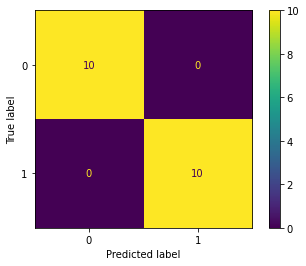

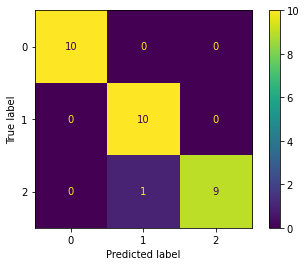

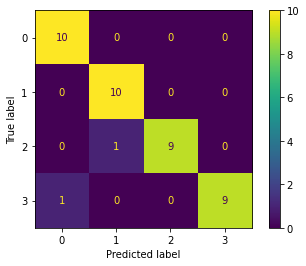

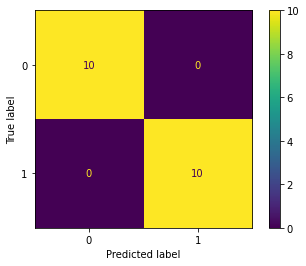

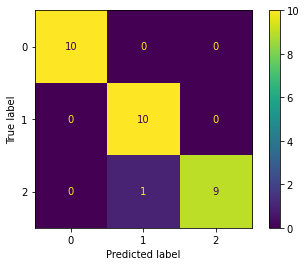

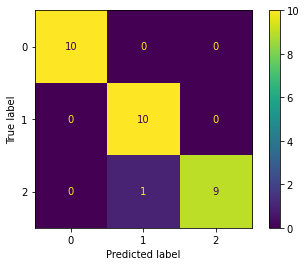

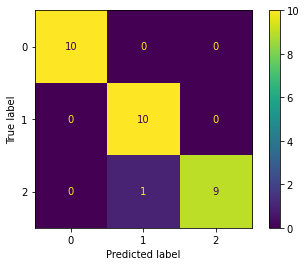

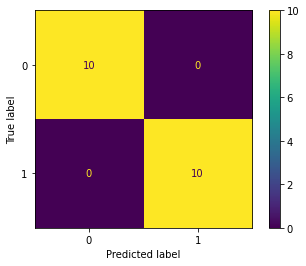

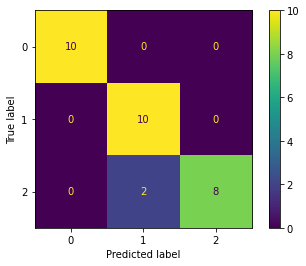

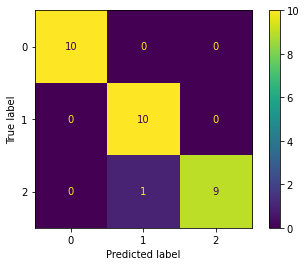

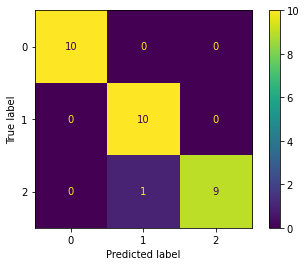

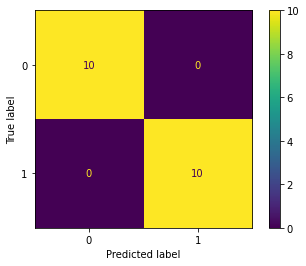

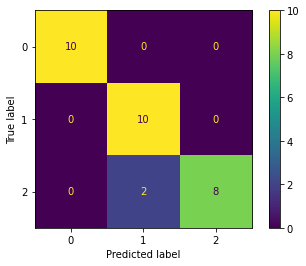

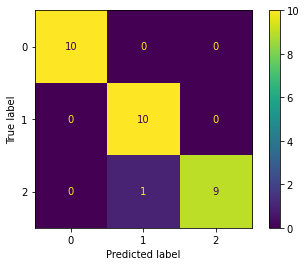

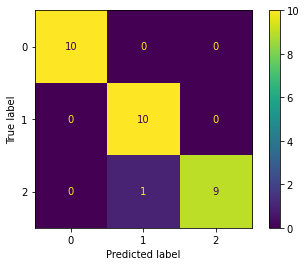

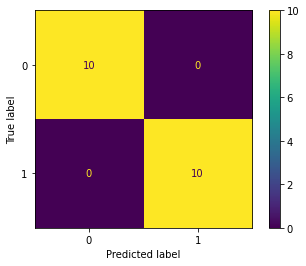

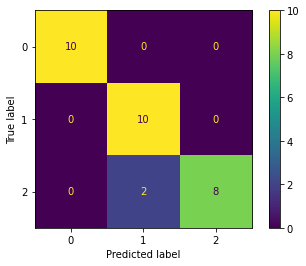

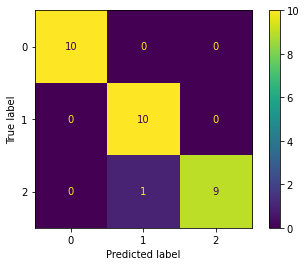

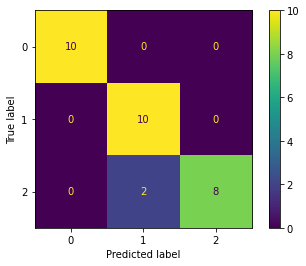

In [35]:
n_exps = 5

ground_truth = [0,1,2,3]

pred_iou = []
for i in range(n_exps):
    print("========== Experiment %s ==========" % str(i+1))
    known_classes = [0,1]
    known_classes_order = []
    
    model = None
    
    retrains = 0
    while len(known_classes) < len(ground_truth) and retrains < 2:
        print("Known classes:", known_classes)
        known_classes_order.append(known_classes.copy())
        
        feature_idxs = [*range(3,16),*range(22,28)]
        #feature_idxs = [*range(3,13),*range(22,28)] # without jitter force
        #feature_idxs = [*range(3,19),*range(22,28)] # with object position
        Xtrain, Ttrain, Xtest, Ttest = make_train_test_data(known_classes, crop_len, feature_idxs)
        print()

        if model is None:
            model = train_classifier(Xtrain, Ttrain, len(known_classes), pretrained=initial_weights)
        else:
            with torch.no_grad():
                weights = [[],[]]
                for i in range(len(model.conv_layers)):
                    weights[0].append(model.conv_layers[i].weight.detach())
                for i in range(len(model.fc_layers)-1):
                    weights[1].append(model.fc_layers[i].weight.detach())
            model = train_classifier(Xtrain, Ttrain, len(known_classes), pretrained=weights)
        print()

        # check classifier on the test data
        classes, probs = model.use(Xtest)

        # make confusion matrix
        cm = sklearn.metrics.confusion_matrix(Ttest, classes)
        disp = ConfusionMatrixDisplay(cm)
        disp.plot()

        novel_classes, dissimilarities, outlier_ratios = compare_classes(model, Xtrain.shape[-1]//10)
        gated_dissimilarities = [dissimilarities[i] if novel_classes[i] == True \
            else float('inf') for i in range(len(dissimilarities))]
        
        gated_dissimilarities = [gated_dissimilarities[i] if gated_dissimilarities[i] == gated_dissimilarities[i] \
            else float('inf') for i in range(len(gated_dissimilarities))]
        
        if np.min(gated_dissimilarities) == float('inf'):
            print("No novel class found")
            retrains += 1
            print("Retraining (%s)" % retrains)
        else:
            new_class = np.argmin(gated_dissimilarities)
            known_classes.append(new_class)
            retrains = 0

            print("Most novel class:", known_classes[-1])
        print()
        
    print("Known classes:", known_classes)
    known_classes_order.append(known_classes.copy())
    
    feature_idxs = [*range(3,16),*range(22,28)]
    #feature_idxs = [*range(3,13),*range(22,28)] # without jitter force
    #feature_idxs = [*range(3,19),*range(22,28)] # with object position
    Xtrain, Ttrain, Xtest, Ttest = make_train_test_data(known_classes, crop_len, feature_idxs)
    print()

    with torch.no_grad():
        weights = [[],[]]
        for i in range(len(model.conv_layers)):
            weights[0].append(model.conv_layers[i].weight.detach())
        for i in range(len(model.fc_layers)-1):
            weights[1].append(model.fc_layers[i].weight.detach())
    model = train_classifier(Xtrain, Ttrain, len(known_classes), pretrained=weights)
    print()

    # check classifier on the test data
    classes, probs = model.use(Xtest)

    # make confusion matrix
    cm = sklearn.metrics.confusion_matrix(Ttest, classes)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()

    novel_classes, dissimilarities, outlier_ratios = compare_classes(model, Xtrain.shape[-1]//10)
    gated_dissimilarities = [dissimilarities[i] if novel_classes[i] == True \
        else float('inf') for i in range(len(dissimilarities))]
    
    gated_dissimilarities = [gated_dissimilarities[i] if gated_dissimilarities[i] == gated_dissimilarities[i] \
        else float('inf') for i in range(len(gated_dissimilarities))]
    
    if np.min(gated_dissimilarities) != float('inf'):
        new_class = np.argmin(gated_dissimilarities)
        known_classes.append(new_class)
        
    print("Known classes:", known_classes)
    known_classes_order.append(known_classes.copy())
    
    print("Order of acquisition:", known_classes_order)

    pred_iou.append(np.intersect1d(known_classes[2:],ground_truth[2:]).shape[0]/\
                    np.union1d(known_classes[2:],ground_truth[2:]).shape[0])
    print(pred_iou,pred_iou[-1])
    print()
    
print(np.sum(pred_iou)/len(pred_iou))

# G: Multi-class non-curriculum learning 2

Start with cube and sphere.  After each trial add the class that has inferred to have the *greatest*  dissimilarity from its most similar class above the novelty threshold.  Test for the ability to acquire cylinder and capsule as distinct classes while not splitting small cube from big cube. With each additional class added, the model is retrained from scratch.

In [125]:
n_exps = 25

ground_truth = [0,1,2,3]

pred_iou = []
for i in range(n_exps):
    print("========== Experiment %s ==========" % str(i+1))
    known_classes = [0,1]
    known_classes_order = []
    
    model = None
    
    retrains = 0
    while len(known_classes) < len(ground_truth) and retrains < 2:
        print("Known classes:", known_classes)
        known_classes_order.append(known_classes.copy())
        
        feature_idxs = [*range(3,16),*range(22,28)]
        #feature_idxs = [*range(3,13),*range(22,28)] # without jitter force
        #feature_idxs = [*range(3,19),*range(22,28)] # with object position
        Xtrain, Ttrain, Xtest, Ttest = make_train_test_data(known_classes, crop_len, feature_idxs)
        print()

        model = train_classifier(Xtrain, Ttrain, len(known_classes))
        print()

        # check classifier on the test data
        classes, probs = model.use(Xtest)

        # make confusion matrix
        cm = sklearn.metrics.confusion_matrix(Ttest, classes)
        disp = ConfusionMatrixDisplay(cm)
        disp.plot()

        novel_classes, dissimilarities = compare_classes(model, Xtrain.shape[-1]//10)
        gated_dissimilarities = [dissimilarities[i] if novel_classes[i] == True \
            else float('-inf') for i in range(len(dissimilarities))]
        
        gated_dissimilarities = [gated_dissimilarities[i] if gated_dissimilarities[i] == gated_dissimilarities[i] \
            else float('-inf') for i in range(len(gated_dissimilarities))]
        
        if np.max(gated_dissimilarities) == float('-inf'):
            print("No novel class found")
            retrains += 1
            print("Retraining (%s)" % retrains)
        else:
            new_class = np.argmax(gated_dissimilarities)
            known_classes.append(new_class)
            retrains = 0

            print("Most novel class:", known_classes[-1])
        print()
        
    print("Known classes:", known_classes)
    known_classes_order.append(known_classes.copy())
    
    feature_idxs = [*range(3,16),*range(22,28)]
    #feature_idxs = [*range(3,13),*range(22,28)] # without jitter force
    #feature_idxs = [*range(3,19),*range(22,28)] # with object position
    Xtrain, Ttrain, Xtest, Ttest = make_train_test_data(known_classes, crop_len, feature_idxs)
    print()

    model = train_classifier(Xtrain, Ttrain, len(known_classes))
    print()

    # check classifier on the test data
    classes, probs = model.use(Xtest)

    # make confusion matrix
    cm = sklearn.metrics.confusion_matrix(Ttest, classes)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()

    novel_classes, dissimilarities = compare_classes(model, Xtrain.shape[-1]//10)
    gated_dissimilarities = [dissimilarities[i] if novel_classes[i] == True \
        else float('-inf') for i in range(len(dissimilarities))]
    
    gated_dissimilarities = [gated_dissimilarities[i] if gated_dissimilarities[i] == gated_dissimilarities[i] \
        else float('-inf') for i in range(len(gated_dissimilarities))]
    
    if np.max(gated_dissimilarities) != float('-inf'):
        new_class = np.argmax(gated_dissimilarities)
        known_classes.append(new_class)
        
    print("Known classes:", known_classes)
    known_classes_order.append(known_classes.copy())
    
    print("Order of acquisition:", known_classes_order)

    pred_iou.append(np.intersect1d(known_classes[2:],ground_truth[2:]).shape[0]/\
                    np.union1d(known_classes[2:],ground_truth[2:]).shape[0])
    print(pred_iou,pred_iou[-1])
    print()
    
print(np.sum(pred_iou)/len(pred_iou))

========== Experiment 1 ==========
Known classes: [0, 1]
(1800, 19) (1800,) (200, 19) (200,)
(180, 190) (180,) (20, 190) (20,)
(180, 1, 190) (180,) (20, 1, 190) (20,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

# H: Multi-class curriculum learning 2

Start with cube and sphere.  After each trial add the class that has inferred to have the *greatest*  dissimilarity from its most similar class above the novelty threshold.  Test for the ability to acquire cylinder and capsule as distinct classes while not splitting small cube from big cube. With each additional class added, the model is initialized with the trained weights from the previous model (except for the final fully connected layer weights, which are initialized randomly).

In [ ]:
n_exps = 25

ground_truth = [0,1,2,3]

pred_iou = []
for i in range(n_exps):
    print("========== Experiment %s ==========" % str(i+1))
    known_classes = [0,1]
    known_classes_order = []
    
    model = None
    
    retrains = 0
    while len(known_classes) < len(ground_truth) and retrains < 2:
        print("Known classes:", known_classes)
        known_classes_order.append(known_classes.copy())
        
        feature_idxs = [*range(3,16),*range(22,28)]
        #feature_idxs = [*range(3,13),*range(22,28)] # without jitter force
        #feature_idxs = [*range(3,19),*range(22,28)] # with object position
        Xtrain, Ttrain, Xtest, Ttest = make_train_test_data(known_classes, crop_len, feature_idxs)
        print()

        if model is None:
            model = train_classifier(Xtrain, Ttrain, len(known_classes))
        else:
            with torch.no_grad():
                weights = [[],[]]
                for i in range(len(model.conv_layers)):
                    weights[0].append(model.conv_layers[i].weight.detach())
                for i in range(len(model.fc_layers)-1):
                    weights[1].append(model.fc_layers[i].weight.detach())
            model = train_classifier(Xtrain, Ttrain, len(known_classes), pretrained=weights)
        print()

        # check classifier on the test data
        classes, probs = model.use(Xtest)

        # make confusion matrix
        cm = sklearn.metrics.confusion_matrix(Ttest, classes)
        disp = ConfusionMatrixDisplay(cm)
        disp.plot()

        novel_classes, dissimilarities = compare_classes(model, Xtrain.shape[-1]//10)
        gated_dissimilarities = [dissimilarities[i] if novel_classes[i] == True \
            else float('-inf') for i in range(len(dissimilarities))]
        
        gated_dissimilarities = [gated_dissimilarities[i] if gated_dissimilarities[i] == gated_dissimilarities[i] \
            else float('-inf') for i in range(len(gated_dissimilarities))]
        
        if np.max(gated_dissimilarities) == float('-inf'):
            print("No novel class found")
            retrains += 1
            print("Retraining (%s)" % retrains)
        else:
            new_class = np.argmax(gated_dissimilarities)
            known_classes.append(new_class)
            retrains = 0

            print("Most novel class:", known_classes[-1])
        print()
        
    print("Known classes:", known_classes)
    known_classes_order.append(known_classes.copy())
    
    feature_idxs = [*range(3,16),*range(22,28)]
    #feature_idxs = [*range(3,13),*range(22,28)] # without jitter force
    #feature_idxs = [*range(3,19),*range(22,28)] # with object position
    Xtrain, Ttrain, Xtest, Ttest = make_train_test_data(known_classes, crop_len, feature_idxs)
    print()

    with torch.no_grad():
        weights = [[],[]]
        for i in range(len(model.conv_layers)):
            weights[0].append(model.conv_layers[i].weight.detach())
        for i in range(len(model.fc_layers)-1):
            weights[1].append(model.fc_layers[i].weight.detach())
    model = train_classifier(Xtrain, Ttrain, len(known_classes), pretrained=weights)
    print()

    # check classifier on the test data
    classes, probs = model.use(Xtest)

    # make confusion matrix
    cm = sklearn.metrics.confusion_matrix(Ttest, classes)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()

    novel_classes, dissimilarities = compare_classes(model, Xtrain.shape[-1]//10)
    gated_dissimilarities = [dissimilarities[i] if novel_classes[i] == True \
        else float('-inf') for i in range(len(dissimilarities))]
    
    gated_dissimilarities = [gated_dissimilarities[i] if gated_dissimilarities[i] == gated_dissimilarities[i] \
        else float('-inf') for i in range(len(gated_dissimilarities))]
    
    if np.max(gated_dissimilarities) != float('-inf'):
        new_class = np.argmax(gated_dissimilarities)
        known_classes.append(new_class)
        
    print("Known classes:", known_classes)
    known_classes_order.append(known_classes.copy())
    
    print("Order of acquisition:", known_classes_order)

    pred_iou.append(np.intersect1d(known_classes[2:],ground_truth[2:]).shape[0]/\
                    np.union1d(known_classes[2:],ground_truth[2:]).shape[0])
    print(pred_iou,pred_iou[-1])
    print()
    
print(np.sum(pred_iou)/len(pred_iou))

# I: Given cube and sphere (no VoxML features)

Like (A), but the training data drops the VoxML-derived "jitter" features.

========== Experiment 1 ==========
(1800, 16) (1800,) (200, 16) (200,)
(180, 160) (180,) (20, 160) (20,)
(180, 1, 160) (180,) (20, 1, 160) (20,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.002
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.001
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 3.5762786865234375e-07
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.5634541213512421
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilar

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in double_scalars
/Users/n

Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: nan
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: False

New class: 2
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: nan
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: False

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0
Angle from sim_mean to new_mean: -1.1920928955078125e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: -inf
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: False

New class: 4


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: nan
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: False

========== Experiment 3 ==========
(1800, 16) (1800,) (200, 16) (200,)
(180, 160) (180,) (20, 160) (20,)
(180, 1, 160) (180,) (20, 1, 160) (20,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.001
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 1.9669532775878906e-06
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class:

Most similar class: 0
Angle from sim_mean to sim_mean+std: 4.172325134277344e-07
Angle from sim_mean to new_mean: -1.1920928955078125e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: -0.2857142857142857
Outlier ratio: 0.5177095631641087
Dissimilarity from most similar class: -35.79591836734694
Likely novel class: False

========== Experiment 7 ==========
(1800, 16) (1800,) (200, 16) (200,)
(180, 160) (180,) (20, 160) (20,)
(180, 1, 160) (180,) (20, 1, 160) (20,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.002
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+s

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in double_scalars
/Users/n

Angle from sim_mean to sim_mean+std: 0.0
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: nan
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: False

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0039476752281188965
Angle from sim_mean to new_mean: 0.00014227628707885742
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0360405248297625
Outlier ratio: 0.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 4
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0
Angle from sim_mean to new_mean: -1.1920928955078125e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: -inf


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: False

========== Experiment 8 ==========
(1800, 16) (1800,) (200, 16) (200,)
(180, 160) (180,) (20, 160) (20,)
(180, 1, 160) (180,) (20, 1, 160) (20,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.001
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 4.76837158203125e-07
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0049849748611450195
Angle from sim_mean to new_mean: 0.0
Angle from s

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in double_scalars


Angle from sim_mean to sim_mean+std: -1.1920928955078125e-07
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: -0.0
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: False

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 3.516674041748047e-06
Angle from sim_mean to new_mean: 1.9669532775878906e-06
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.559322033898305
Outlier ratio: 15.796014067995307
Dissimilarity from most similar class: 127.73398448721628
Likely novel class: True

New class: 4
Most similar class: 0
Angle from sim_mean to sim_mean+std: -1.1920928955078125e-07
Angle from sim_mean to new_mean: -1.1920928955078125e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 1.0
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: True

========== Experiment 10 ==========
(1800, 16) (1800,) (200, 16) (200,

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


adam: Epoch 50 Loss 0.001
adam: Epoch 100 Loss 0.000
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 1.7881393432617188e-07
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0014268755912780762
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: False

New class: 2
Most similar class: 0


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in double_scalars


Angle from sim_mean to sim_mean+std: 1.7881393432617188e-07
Angle from sim_mean to new_mean: 4.172325134277344e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 2.3333333333333335
Outlier ratio: 133666.42734060885
Dissimilarity from most similar class: 180999194.44444442
Likely novel class: True

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0014268755912780762
Angle from sim_mean to new_mean: 0.002047717571258545
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 1.4351058941476251
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: True

New class: 4
Most similar class: 0


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


Angle from sim_mean to sim_mean+std: 1.7881393432617188e-07
Angle from sim_mean to new_mean: 5.960464477539063e-08
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.3333333333333333
Outlier ratio: 0.3469270534175762
Dissimilarity from most similar class: 67.11111111111111
Likely novel class: True

True [ True False  True False  True  True False  True False  True] 0.6
True [ True False  True False  True  True False False  True  True] 0.6
False [False False False  True False False False False  True  True] 0.7
[0.6, 0.6, 0.7] 0.6333333333333333


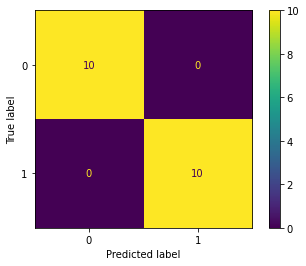

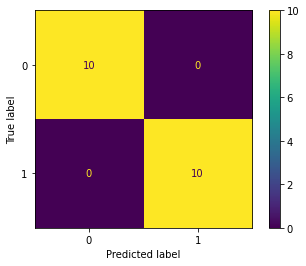

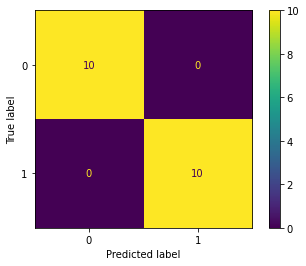

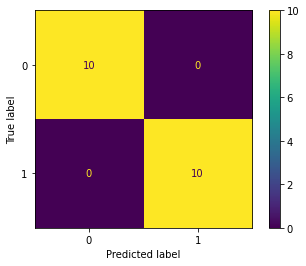

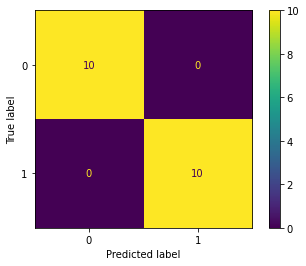

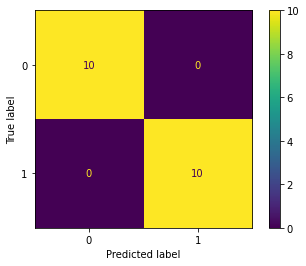

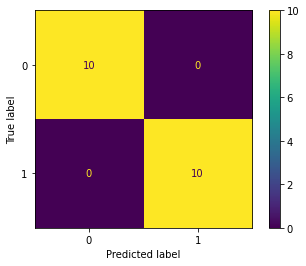

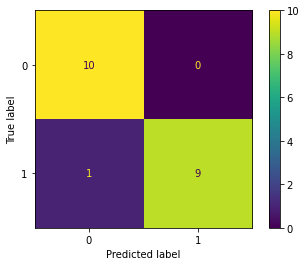

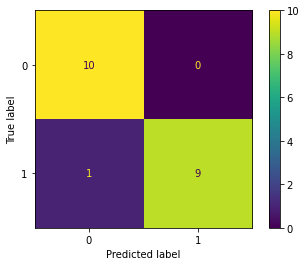

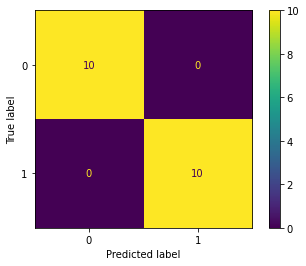

In [49]:
ground_truth = [False, False, True, True, False]
novelty_judgments = []
n_exps = 10

for i in range(n_exps):
    print("========== Experiment %s ==========" % str(i+1))
    
    #feature_idxs = [*range(3,16),*range(22,28)]
    feature_idxs = [*range(3,13),*range(22,28)] # without jitter force
    #feature_idxs = [*range(3,19),*range(22,28)] # with object position
    Xtrain, Ttrain, Xtest, Ttest = make_train_test_data([0,1], crop_len, feature_idxs)
    print()

    model = train_classifier(Xtrain, Ttrain, 2)
    print()

    # check classifier on the test data
    classes, probs = model.use(Xtest)

    # make confusion matrix
    cm = sklearn.metrics.confusion_matrix(Ttest, classes)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()

    novel_classes, dissimilarities = compare_classes(model, Xtrain.shape[-1]//10)
    novelty_judgments.append(novel_classes)
    
novelty_judgments = np.array(novelty_judgments).reshape(n_exps,-1).T

pred_acc = []
for i in range(2,len(ground_truth)):
    pred_acc.append(np.sum(novelty_judgments[i] == ground_truth[i])/n_exps)
    print(ground_truth[i], novelty_judgments[i], pred_acc[-1])
    
print(pred_acc, np.mean(pred_acc))

# J: Given cube, sphere, and cylinder (no VoxML features)

Like (B), but the training data drops the VoxML-derived "jitter" features.

========== Experiment 1 ==========
(2700, 16) (2700,) (300, 16) (300,)
(270, 160) (270,) (30, 160) (30,)
(270, 1, 160) (270,) (30, 1, 160) (30,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.249
adam: Epoch 100 Loss 0.240
adam: Epoch 150 Loss 0.228
adam: Epoch 200 Loss 0.209
adam: Epoch 250 Loss 0.197
adam: Epoch 300 Loss 0.187
adam: Epoch 350 Loss 0.179
adam: Epoch 400 Loss 0.173
adam: Epoch 450 Loss 0.167
adam: Epoch 500 Loss 0.162

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.004251539707183838
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.1376744508743286
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarit

adam: Epoch 50 Loss 0.249
adam: Epoch 100 Loss 0.237
adam: Epoch 150 Loss 0.227
adam: Epoch 200 Loss 0.214
adam: Epoch 250 Loss 0.205
adam: Epoch 300 Loss 0.200
adam: Epoch 350 Loss 0.197
adam: Epoch 400 Loss 0.193
adam: Epoch 450 Loss 0.190
adam: Epoch 500 Loss 0.187

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0584721565246582
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.001898050308227539
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0584721565246582
Angle from sim_mean to new_mean: 0.0009388327598571777
An

adam: Epoch 50 Loss 0.250
adam: Epoch 100 Loss 0.239
adam: Epoch 150 Loss 0.227
adam: Epoch 200 Loss 0.208
adam: Epoch 250 Loss 0.199
adam: Epoch 300 Loss 0.195
adam: Epoch 350 Loss 0.193
adam: Epoch 400 Loss 0.191
adam: Epoch 450 Loss 0.186
adam: Epoch 500 Loss 0.182

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0012156963348388672
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.003821432590484619
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0012156963348388672
Angle from sim_mean to new_mean: 1.8775463104248047

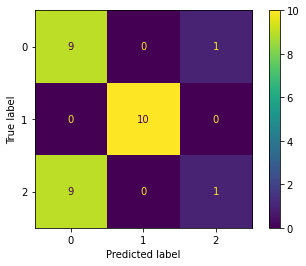

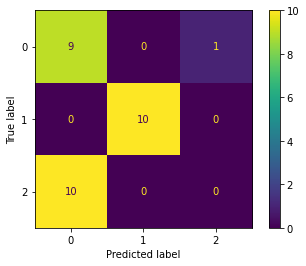

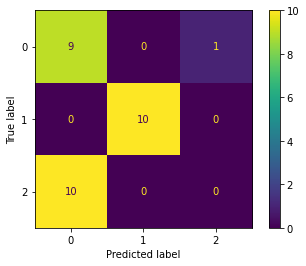

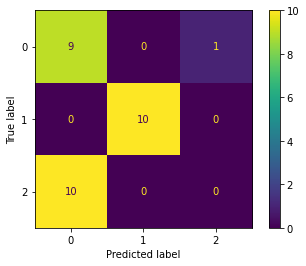

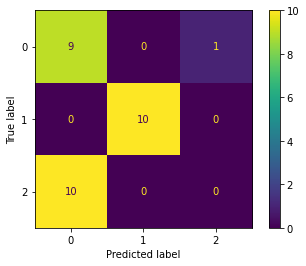

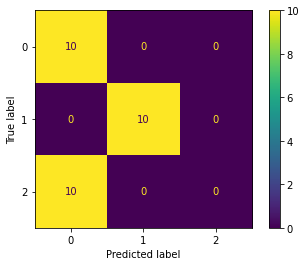

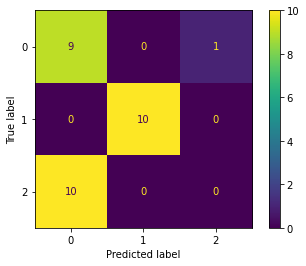

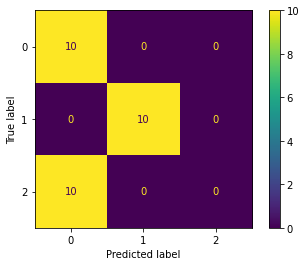

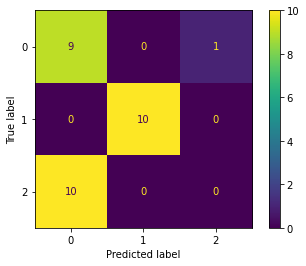

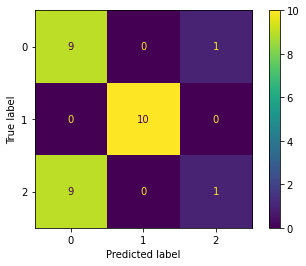

In [55]:
ground_truth = [False, False, False, True, False]
novelty_judgments = []
n_exps = 10

for i in range(n_exps):
    print("========== Experiment %s ==========" % str(i+1))
    
    #feature_idxs = [*range(3,16),*range(22,28)]
    feature_idxs = [*range(3,13),*range(22,28)] # without jitter force
    #feature_idxs = [*range(3,19),*range(22,28)] # with object position
    Xtrain, Ttrain, Xtest, Ttest = make_train_test_data([0,1,2], crop_len, feature_idxs)
    print()

    model = train_classifier(Xtrain, Ttrain, 3)
    print()

    # check classifier on the test data
    classes, probs = model.use(Xtest)

    # make confusion matrix
    cm = sklearn.metrics.confusion_matrix(Ttest, classes)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()

    novel_classes, dissimilarities = compare_classes(model, Xtrain.shape[-1]//10)
    novelty_judgments.append(novel_classes)
    
novelty_judgments = np.array(novelty_judgments).reshape(n_exps,-1).T

pred_acc = []
for i in range(2,len(ground_truth)):
    pred_acc.append(np.sum(novelty_judgments[i] == ground_truth[i])/n_exps)
    print(ground_truth[i], novelty_judgments[i], pred_acc[-1])
    
print(pred_acc, np.mean(pred_acc))

# K: Given cube, sphere, and capsule (no VoxML features)

Like (C), but the training data drops the VoxML-derived "jitter" features.

========== Experiment 1 ==========
(2700, 16) (2700,) (300, 16) (300,)
(270, 160) (270,) (30, 160) (30,)
(270, 1, 160) (270,) (30, 1, 160) (30,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.056
adam: Epoch 100 Loss 0.017
adam: Epoch 150 Loss 0.004
adam: Epoch 200 Loss 0.002
adam: Epoch 250 Loss 0.001
adam: Epoch 300 Loss 0.001
adam: Epoch 350 Loss 0.001
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.011135220527648926
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0005427002906799316
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimila

adam: Epoch 50 Loss 0.033
adam: Epoch 100 Loss 0.004
adam: Epoch 150 Loss 0.002
adam: Epoch 200 Loss 0.001
adam: Epoch 250 Loss 0.001
adam: Epoch 300 Loss 0.001
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.01055997610092163
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.00046688318252563477
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.01055997610092163
Angle from sim_mean to new_mean: 2.1398067474365234e-

adam: Epoch 50 Loss 0.039
adam: Epoch 100 Loss 0.006
adam: Epoch 150 Loss 0.002
adam: Epoch 200 Loss 0.001
adam: Epoch 250 Loss 0.001
adam: Epoch 300 Loss 0.001
adam: Epoch 350 Loss 0.001
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.001210331916809082
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0004074573516845703
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.001210331916809082
Angle from sim_mean to new_mean: 1.9550323486328125e

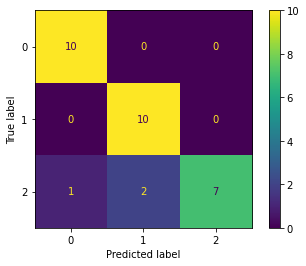

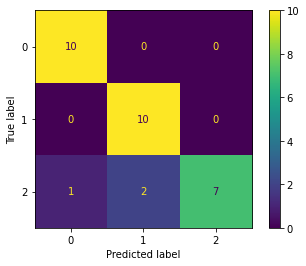

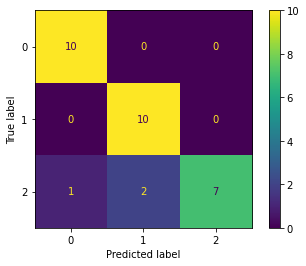

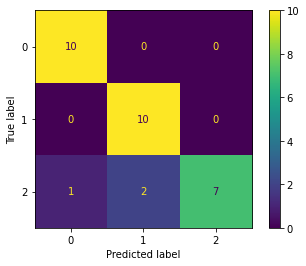

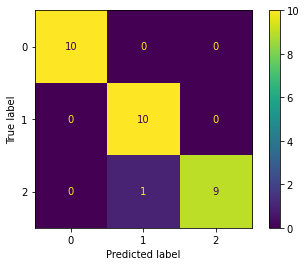

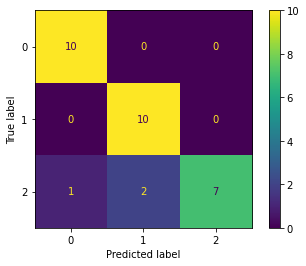

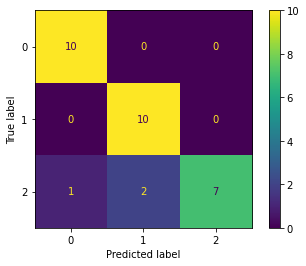

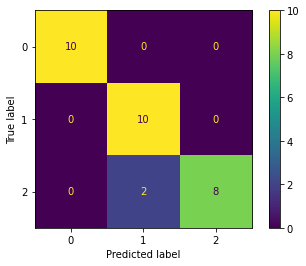

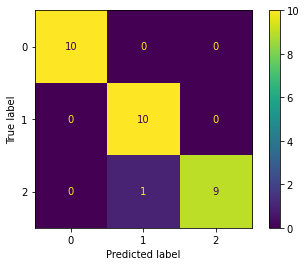

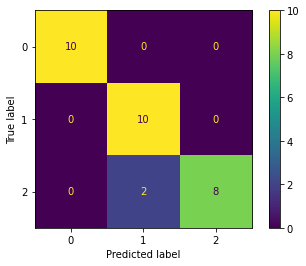

In [56]:
ground_truth = [False, False, True, False, False]
novelty_judgments = []
n_exps = 10

for i in range(n_exps):
    print("========== Experiment %s ==========" % str(i+1))
    
    #feature_idxs = [*range(3,16),*range(22,28)]
    feature_idxs = [*range(3,13),*range(22,28)] # without jitter force
    #feature_idxs = [*range(3,19),*range(22,28)] # with object position
    Xtrain, Ttrain, Xtest, Ttest = make_train_test_data([0,1,3], crop_len, feature_idxs)
    print()

    model = train_classifier(Xtrain, Ttrain, 3)
    print()

    # check classifier on the test data
    classes, probs = model.use(Xtest)

    # make confusion matrix
    cm = sklearn.metrics.confusion_matrix(Ttest, classes)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()

    novel_classes, dissimilarities = compare_classes(model, Xtrain.shape[-1]//10)
    novelty_judgments.append(novel_classes)
    
novelty_judgments = np.array(novelty_judgments).reshape(n_exps,-1).T

pred_acc = []
for i in range(2,len(ground_truth)):
    pred_acc.append(np.sum(novelty_judgments[i] == ground_truth[i])/n_exps)
    print(ground_truth[i], novelty_judgments[i], pred_acc[-1])
    
print(pred_acc, np.mean(pred_acc))

# L: Multi-class learning (no VoxML features)

Like (E), but the training data drops the VoxML-derived "jitter" features.

========== Experiment 1 ==========
Known classes: [0, 1]
(1800, 16) (1800,) (200, 16) (200,)
(180, 160) (180,) (20, 160) (20,)
(180, 1, 160) (180,) (20, 1, 160) (20,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.002
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 6.496906280517578e-06
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.1976657509803772
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier 

Angle from sim_mean to sim_mean+std: 1.1920928955078125e-07
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 265.9457259158752
Dissimilarity from most similar class: 0.0
Likely novel class: False

Most novel class: 3

Known classes: [0, 1, 3]
(2700, 16) (2700,) (300, 16) (300,)
(270, 160) (270,) (30, 160) (30,)
(270, 1, 160) (270,) (30, 1, 160) (30,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.047
adam: Epoch 100 Loss 0.006
adam: Epoch 150 Loss 0.002
adam: Epoch 200 Loss 0.001
adam: Epoch 250 Loss 0.001
adam: Epoch 300 Loss 0.001
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0018596053123474121
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity fro

Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.023437917232513428
Angle from sim_mean to new_mean: 0.0006362795829772949
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.027147445597027642
Outlier ratio: 1.5211476907968053
Dissimilarity from most similar class: 24.36236461494727
Likely novel class: False

No novel class found
Retraining (4)

Known classes: [0, 1, 3]
(2700, 16) (2700,) (300, 16) (300,)
(270, 160) (270,) (30, 160) (30,)
(270, 1, 160) (270,) (30, 1, 160) (30,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.039
adam: Epoch 100 Loss 0.005
adam: Epoch 150 Loss 0.002
adam: Epoch 200 Loss 0.001
adam: Epoch 250 Loss 0.001
adam: Epoch 300 Loss 0.001
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.002138197422027588
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to n

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in double_scalars


Angle from sim_mean to sim_mean+std: 0.00024205446243286133
Angle from sim_mean to new_mean: 5.960464477539063e-08
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0002462447672986949
Outlier ratio: 209.9162148568815
Dissimilarity from most similar class: 14.248208661788544
Likely novel class: False

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 2.1696090698242188e-05
Angle from sim_mean to new_mean: 5.6862831115722656e-05
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 2.620879120879121
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: True

New class: 4


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.00024205446243286133
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 30.49624392636327
Dissimilarity from most similar class: 0.0
Likely novel class: False

No novel class found
Retraining (1)

Known classes: [0, 1]
(1800, 16) (1800,) (200, 16) (200,)
(180, 160) (180,) (20, 160) (20,)
(180, 1, 160) (180,) (20, 1, 160) (20,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.001
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: nan
Outlier ratio: inf


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in double_scalars
/Users/n

Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: nan
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: False

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 1.4126300811767578e-05
Angle from sim_mean to new_mean: 3.874301910400391e-06
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.2742616033755274
Outlier ratio: 12.613173381620642
Dissimilarity from most similar class: 64.48619345190407
Likely novel class: True

New class: 4
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: nan
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: False

Most novel class: 3

Known classes: [0, 1, 3]
(2700, 16) (2700,) (300, 16) (300,)
(270, 160) (270,) (30, 160

Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.017401278018951416
Angle from sim_mean to new_mean: 4.166364669799805e-05
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.00239428659507784
Outlier ratio: 1.7982513410047494
Dissimilarity from most similar class: 2.843608054278935
Likely novel class: False

New class: 3
Most similar class: 3
Angle from sim_mean to sim_mean+std: 0.524345189332962
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 4
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.017401278018951416
Angle from sim_mean to new_mean: 3.3795833587646484e-05
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0019421466372090634
Outlier ratio: 1.6317935823493182
Dissimilarity from most similar class: 2.093102260552221
Likely novel class: False

No novel cl

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in double_scalars
/Users/n

Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: nan
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: False

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0007992982864379883
Angle from sim_mean to new_mean: 2.9265880584716797e-05
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0366144668158091
Outlier ratio: 0.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 4
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0
Angle from sim_mean to new_mean: -1.1920928955078125e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: -inf
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: False

No novel class found
Retraining (1)

Known classes: [0, 1]
(1800, 16) (1800,) (200, 16) (200,)
(180, 160) (180,) (2

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


adam: Epoch 50 Loss 0.001
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: nan
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0014525055885314941
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in double_scalars
/Users/n

Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0
Angle from sim_mean to new_mean: 1.7881393432617188e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: inf


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: True

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0014525055885314941
Angle from sim_mean to new_mean: 0.00018346309661865234
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.12630801428043825
Outlier ratio: 4.359848133181532
Dissimilarity from most similar class: 4.624690532636002
Likely novel class: False

New class: 4
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: nan
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: False

No novel class found
Retraining (2)

Known classes: [0, 1]
(1800, 16) (1800,) (200, 16) (200,)
(180, 160) (180,) (20, 160) (20,)
(180, 1, 160) (180,) (20, 1, 160) (20,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.001
adam: Epoch 100 Loss 0.00

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/sklearn/metrics/_plot/confusion_matrix.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Angle from sim_mean to sim_mean+std: 3.331899642944336e-05
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.014285564422607422
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 0
Angle from sim_mean to sim_mean+std: 3.331899642944336e-05
Angle from sim_mean to new_mean: 2.384185791015625e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.007155635062611807
Outlier ratio: 2458.9979804354684
Dissimilarity from most similar class: 2992.526752026523
Likely novel class: True

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.014285564422607422
A

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in double_scalars
/Users/n

Most similar class: 0
Angle from sim_mean to sim_mean+std: -1.1920928955078125e-07
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: -0.0
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: False

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0
Angle from sim_mean to new_mean: 5.960464477539063e-08
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: inf
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: True

New class: 4
Most similar class: 0


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


Angle from sim_mean to sim_mean+std: -1.1920928955078125e-07
Angle from sim_mean to new_mean: -1.1920928955078125e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 1.0
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: True

No novel class found
Retraining (1)

Known classes: [0, 1]
(1800, 16) (1800,) (200, 16) (200,)
(180, 160) (180,) (20, 160) (20,)
(180, 1, 160) (180,) (20, 1, 160) (20,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.002
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.001
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: nan
Outlier ratio: inf
Dissimilarity fr

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in double_scalars
/Users/n

Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0
Angle from sim_mean to new_mean: -1.1920928955078125e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: -inf


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: False

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 2.3245811462402344e-06
Angle from sim_mean to new_mean: 1.1920928955078125e-06
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.5128205128205128
Outlier ratio: 14.747609942638622
Dissimilarity from most similar class: 101.42011834319526
Likely novel class: True

New class: 4
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0
Angle from sim_mean to new_mean: 5.960464477539063e-08
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: inf
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: True

Most novel class: 3

Known classes: [0, 1, 3]
(2700, 16) (2700,) (300, 16) (300,)
(270, 160) (270,) (30, 160) (30,)
(270, 1, 160) (270,) (30, 1, 160) (30,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.046
adam: Epoch 100 Los

Outlier ratio: 0.959720325616077
Dissimilarity from most similar class: 5.38982968049477
Likely novel class: False

New class: 3
Most similar class: 3
Angle from sim_mean to sim_mean+std: 0.4638485908508301
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 4
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.004343092441558838
Angle from sim_mean to new_mean: 8.940696716308594e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.00020586015233651272
Outlier ratio: 1.2505255529756791
Dissimilarity from most similar class: 0.12206843670297556
Likely novel class: False

No novel class found
Retraining (4)

Known classes: [0, 1, 3]
(2700, 16) (2700,) (300, 16) (300,)
(270, 160) (270,) (30, 160) (30,)
(270, 1, 160) (270,) (30, 1, 160) (30,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
a

Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0037593841552734375
Angle from sim_mean to new_mean: 4.5299530029296875e-05
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.012049720953830542
Outlier ratio: 0.9718063963070984
Dissimilarity from most similar class: 6.513634160799629
Likely novel class: False

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.00030159950256347656
Angle from sim_mean to new_mean: 0.0025556087493896484
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 8.473517786561265
Outlier ratio: 105.95873090187338
Dissimilarity from most similar class: 53817.71452530113
Likely novel class: True

New class: 4
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0037593841552734375
Angle from sim_mean to new_mean: 9.578466415405273e-05
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.025478817858954846
Outlier ratio: 1.4763125427105743
Dissimilarity from most simi

Most similar class: 2
Angle from sim_mean to sim_mean+std: 0.06157958507537842
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.002147972583770752
Angle from sim_mean to new_mean: 0.016518592834472656
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 7.690318283985904
Outlier ratio: 76.2873575458532
Dissimilarity from most similar class: 36919.83151086243
Likely novel class: True

New class: 4
Most similar class: 4
Angle from sim_mean to sim_mean+std: 0.0863645076751709
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

Known classes: [0, 1, 2, 4, 3]
Order of acquisition: [[0, 1], [0, 1, 2], [0, 1, 2, 

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in double_scalars
/Users/n

Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: nan
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: False

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 5.960464477539063e-08
Angle from sim_mean to new_mean: 4.76837158203125e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 8.0
Outlier ratio: 45.401785714285715
Dissimilarity from most similar class: 40680.0
Likely novel class: True

New class: 4
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: nan
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: False

Most novel class: 3

Known classe

Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.01028674840927124
Angle from sim_mean to new_mean: 4.9948692321777344e-05
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.004855634680124925
Outlier ratio: 3.1709656902252394
Dissimilarity from most similar class: 6.55652542353601
Likely novel class: False

New class: 3
Most similar class: 3
Angle from sim_mean to sim_mean+std: 0.21945977210998535
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 4
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.01028674840927124
Angle from sim_mean to new_mean: 0.00010722875595092773
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.010423969915924512
Outlier ratio: 1.5990448355519942
Dissimilarity from most similar class: 7.097901894956244
Likely novel class: False

No novel cl

Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.015250027179718018
Angle from sim_mean to new_mean: 0.00015360116958618164
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.010072189890288564
Outlier ratio: 0.9667269834989156
Dissimilarity from most similar class: 5.833961463715084
Likely novel class: False

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.006163358688354492
Angle from sim_mean to new_mean: 0.024590492248535156
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 3.989787629105257
Outlier ratio: 36.56661053043697
Dissimilarity from most similar class: 8677.778447188626
Likely novel class: True

New class: 4
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.015250027179718018
Angle from sim_mean to new_mean: 0.00048100948333740234
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.031541549248982816
Outlier ratio: 1.5142769261543598
Dissimilarity from most similar c

Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.004645884037017822
Angle from sim_mean to new_mean: 3.612041473388672e-05
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.007774712938610559
Outlier ratio: 1.1504687056230847
Dissimilarity from most similar class: 3.3596657704341513
Likely novel class: False

New class: 3
Most similar class: 3
Angle from sim_mean to sim_mean+std: 0.37982815504074097
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 4
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.004645884037017822
Angle from sim_mean to new_mean: 2.7179718017578125e-05
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0058502790429148755
Outlier ratio: 1.5217502328200336
Dissimilarity from most similar class: 3.3439275567152795
Likely novel class: False

No nov

Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.00818091630935669
Angle from sim_mean to new_mean: 1.811981201171875e-05
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0022148878348742834
Outlier ratio: 0.9207592178233337
Dissimilarity from most similar class: 1.0023803104458404
Likely novel class: False

New class: 3
Most similar class: 3
Angle from sim_mean to sim_mean+std: 0.11454880237579346
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 4
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.00818091630935669
Angle from sim_mean to new_mean: 8.022785186767578e-05
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.00980670732151574
Outlier ratio: 1.0976975816223002
Dissimilarity from most similar class: 5.291035015652651
Likely novel class: False

Known class

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in double_scalars
/Users/n

Angle from sim_mean to sim_mean+std: 0.27644145488739014
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0
Angle from sim_mean to new_mean: 7.748603820800781e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: inf


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: True

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.27644145488739014
Angle from sim_mean to new_mean: 0.029038190841674805
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.10504282309432811
Outlier ratio: 0.4743854741265808
Dissimilarity from most similar class: 5.042101206530844
Likely novel class: False

New class: 4
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0
Angle from sim_mean to new_mean: 5.960464477539063e-08
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: inf
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: True

No novel class found
Retraining (1)

Known classes: [0, 1]
(1800, 16) (1800,) (200, 16) (200,)
(180, 160) (180,) (20, 160) (20,)
(180, 1, 160) (180,) (20, 1, 160) (20,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.001
adam: Epoch

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in double_scalars


Most similar class: 0
Angle from sim_mean to sim_mean+std: 6.020069122314453e-06
Angle from sim_mean to new_mean: 5.960464477539063e-08
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.009900990099009901
Outlier ratio: 14787.40940953584
Dissimilarity from most similar class: 22954.477796294486
Likely novel class: True

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.004801273345947266
Angle from sim_mean to new_mean: 0.0015255212783813477
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.3177326447512166
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: True

New class: 4
Most similar class: 0


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


Angle from sim_mean to sim_mean+std: 6.020069122314453e-06
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 2116.5761919797915
Dissimilarity from most similar class: 0.0
Likely novel class: False

Most novel class: 2

Known classes: [0, 1, 2]
(2700, 16) (2700,) (300, 16) (300,)
(270, 160) (270,) (30, 160) (30,)
(270, 1, 160) (270,) (30, 1, 160) (30,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.249
adam: Epoch 100 Loss 0.240
adam: Epoch 150 Loss 0.232
adam: Epoch 200 Loss 0.221
adam: Epoch 250 Loss 0.205
adam: Epoch 300 Loss 0.199
adam: Epoch 350 Loss 0.196
adam: Epoch 400 Loss 0.194
adam: Epoch 450 Loss 0.191
adam: Epoch 500 Loss 0.189

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0010862946510314941
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity fro

Angle from sim_mean to sim_mean+std: 0.08943551778793335
Angle from sim_mean to new_mean: 8.118152618408203e-05
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0009077101378959652
Outlier ratio: 1.08258793741366
Dissimilarity from most similar class: 0.5764850854144201
Likely novel class: False

No novel class found
Retraining (1)

Known classes: [0, 1, 3]
(2700, 16) (2700,) (300, 16) (300,)
(270, 160) (270,) (30, 160) (30,)
(270, 1, 160) (270,) (30, 1, 160) (30,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.043
adam: Epoch 100 Loss 0.006
adam: Epoch 150 Loss 0.002
adam: Epoch 200 Loss 0.001
adam: Epoch 250 Loss 0.001
adam: Epoch 300 Loss 0.001
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0062825679779052734
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in double_scalars


Most similar class: 0
Angle from sim_mean to sim_mean+std: 2.205371856689453e-06
Angle from sim_mean to new_mean: 2.384185791015625e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.10810810810810811
Outlier ratio: 37670.51509769094
Dissimilarity from most similar class: 681646.4572680789
Likely novel class: True

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0025881528854370117
Angle from sim_mean to new_mean: 0.0008053183555603027
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.3111556353921975
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: True

New class: 4
Most similar class: 0


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


Angle from sim_mean to sim_mean+std: 2.205371856689453e-06
Angle from sim_mean to new_mean: 5.960464477539063e-08
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.02702702702702703
Outlier ratio: 2.6726949782011946
Dissimilarity from most similar class: 12.090577063550036
Likely novel class: False

Most novel class: 2

Known classes: [0, 1, 2]
(2700, 16) (2700,) (300, 16) (300,)
(270, 160) (270,) (30, 160) (30,)
(270, 1, 160) (270,) (30, 1, 160) (30,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.248
adam: Epoch 100 Loss 0.239
adam: Epoch 150 Loss 0.233
adam: Epoch 200 Loss 0.224
adam: Epoch 250 Loss 0.206
adam: Epoch 300 Loss 0.195
adam: Epoch 350 Loss 0.188
adam: Epoch 400 Loss 0.182
adam: Epoch 450 Loss 0.177
adam: Epoch 500 Loss 0.174

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.026872634887695312
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_me

Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.02197551727294922
Angle from sim_mean to new_mean: 0.0005423426628112793
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.024679403723473506
Outlier ratio: 1.3171417707068014
Dissimilarity from most similar class: 15.420904812957119
Likely novel class: False

Most novel class: 3

Known classes: [0, 1, 2, 3]
(3600, 19) (3600,) (400, 19) (400,)
(360, 190) (360,) (40, 190) (40,)
(360, 1, 190) (360,) (40, 1, 190) (40,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.108
adam: Epoch 100 Loss 0.037
adam: Epoch 150 Loss 0.022
adam: Epoch 200 Loss 0.017
adam: Epoch 250 Loss 0.015
adam: Epoch 300 Loss 0.014
adam: Epoch 350 Loss 0.019
adam: Epoch 400 Loss 0.010
adam: Epoch 450 Loss 0.007
adam: Epoch 500 Loss 0.018

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.00852733850479126
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in double_scalars
/Users/n

Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: nan
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: False

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: nan
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: False

New class: 4
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0
Angle from sim_mean to new_mean: 5.960464477539063e-08
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: inf
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: True

No novel class found
Retraining (1)

Known classes: [0, 1]
(1800, 16) (1800,) (200, 16) (200,)
(180, 160) (180,) (20, 160) (20,)
(180, 1, 160) (180,) (20, 1, 160) (20,)

C

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


adam: Epoch 50 Loss 0.001
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 3.5762786865234375e-07
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.17086046934127808
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 0
Angle from sim_mean to sim_mean+std: 3.5762786865234375e-07
Angle from sim_mean to new_mean: 8.940696716308594

adam: Epoch 50 Loss 0.040
adam: Epoch 100 Loss 0.006
adam: Epoch 150 Loss 0.003
adam: Epoch 200 Loss 0.001
adam: Epoch 250 Loss 0.001
adam: Epoch 300 Loss 0.001
adam: Epoch 350 Loss 0.001
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.010072827339172363
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0022512078285217285
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.010072827339172363
Angle from sim_mean to new_mean: 9.542703628540039e-

adam: Epoch 50 Loss 0.001
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: -1.1920928955078125e-07
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: -0.0
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 7.748603820800781e-07
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 0


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in double_scalars


Angle from sim_mean to sim_mean+std: -1.1920928955078125e-07
Angle from sim_mean to new_mean: -1.1920928955078125e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 1.0
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: True

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 7.748603820800781e-07
Angle from sim_mean to new_mean: 4.172325134277344e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.5384615384615384
Outlier ratio: 9.192878338278932
Dissimilarity from most similar class: 128.31952662721895
Likely novel class: True

New class: 4


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


Most similar class: 0
Angle from sim_mean to sim_mean+std: -1.1920928955078125e-07
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: -0.0
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: False

Most novel class: 3

Known classes: [0, 1, 3]
(2700, 16) (2700,) (300, 16) (300,)
(270, 160) (270,) (30, 160) (30,)
(270, 1, 160) (270,) (30, 1, 160) (30,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.041
adam: Epoch 100 Loss 0.006
adam: Epoch 150 Loss 0.002
adam: Epoch 200 Loss 0.001
adam: Epoch 250 Loss 0.001
adam: Epoch 300 Loss 0.001
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.005994737148284912
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimil

Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0011140108108520508
Angle from sim_mean to new_mean: 8.64267349243164e-06
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.007758159443552702
Outlier ratio: 1.8755622573751232
Dissimilarity from most similar class: 2.4870371992587805
Likely novel class: False

No novel class found
Retraining (4)

Known classes: [0, 1, 3]
(2700, 16) (2700,) (300, 16) (300,)
(270, 160) (270,) (30, 160) (30,)
(270, 1, 160) (270,) (30, 1, 160) (30,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.037
adam: Epoch 100 Loss 0.005
adam: Epoch 150 Loss 0.002
adam: Epoch 200 Loss 0.001
adam: Epoch 250 Loss 0.001
adam: Epoch 300 Loss 0.001
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.005269229412078857
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to 

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in double_scalars


Most similar class: 0
Angle from sim_mean to sim_mean+std: 5.960464477539063e-08
Angle from sim_mean to new_mean: -1.1920928955078125e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: -2.0
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: False

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 2.384185791015625e-07
Angle from sim_mean to new_mean: 1.1920928955078125e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.5
Outlier ratio: 10.027397260273972
Dissimilarity from most similar class: 91.5
Likely novel class: True

New class: 4
Most similar class: 0


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


Angle from sim_mean to sim_mean+std: 5.960464477539063e-08
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: False

Most novel class: 3

Known classes: [0, 1, 3]
(2700, 16) (2700,) (300, 16) (300,)
(270, 160) (270,) (30, 160) (30,)
(270, 1, 160) (270,) (30, 1, 160) (30,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.034
adam: Epoch 100 Loss 0.005
adam: Epoch 150 Loss 0.002
adam: Epoch 200 Loss 0.001
adam: Epoch 250 Loss 0.001
adam: Epoch 300 Loss 0.001
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0019855499267578125
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar 

Angle from sim_mean to sim_mean+std: 0.03793817758560181
Angle from sim_mean to new_mean: 2.4437904357910156e-05
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0006441507186993812
Outlier ratio: 1.0820760633203652
Dissimilarity from most similar class: 0.39494745350628196
Likely novel class: False

No novel class found
Retraining (1)

Known classes: [0, 1, 3]
(2700, 16) (2700,) (300, 16) (300,)
(270, 160) (270,) (30, 160) (30,)
(270, 1, 160) (270,) (30, 1, 160) (30,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.025
adam: Epoch 100 Loss 0.004
adam: Epoch 150 Loss 0.002
adam: Epoch 200 Loss 0.001
adam: Epoch 250 Loss 0.001
adam: Epoch 300 Loss 0.001
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0057792067527771
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from si

Angle from sim_mean to sim_mean+std: 0.026982545852661133
Angle from sim_mean to new_mean: 2.3663043975830078e-05
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0008769759571629276
Outlier ratio: 1.1767608041445272
Dissimilarity from most similar class: 0.45010036540768306
Likely novel class: False

No novel class found
Retraining (5)

Known classes: [0, 1, 3]
(2700, 19) (2700,) (300, 19) (300,)
(270, 190) (270,) (30, 190) (30,)
(270, 1, 190) (270,) (30, 1, 190) (30,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.011
adam: Epoch 100 Loss 0.003
adam: Epoch 150 Loss 0.002
adam: Epoch 200 Loss 0.001
adam: Epoch 250 Loss 0.001
adam: Epoch 300 Loss 0.001
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.02609109878540039
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from

Angle from sim_mean to sim_mean+std: 0.004239261150360107
Angle from sim_mean to new_mean: 1.710653305053711e-05
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.004035262854491514
Outlier ratio: 0.840833837694335
Dissimilarity from most similar class: 1.299385900901717
Likely novel class: False

Known classes: [0, 1, 2, 3]
Order of acquisition: [[0, 1], [0, 1, 2], [0, 1, 2, 3], [0, 1, 2, 3]]
[1.0, 0.5, 1.0, 1.0, 0.5, 1.0, 0.6666666666666666, 1.0, 0.6666666666666666, 0.5, 1.0, 1.0, 1.0, 1.0, 0.3333333333333333, 1.0, 0.5, 1.0, 0.5, 1.0] 1.0

========== Experiment 21 ==========
Known classes: [0, 1]
(1800, 16) (1800,) (200, 16) (200,)
(180, 160) (180,) (20, 160) (20,)
(180, 1, 160) (180,) (20, 1, 160) (20,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.001
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 40

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in double_scalars
/Users/n

 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: nan
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: False

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 1.3709068298339844e-05
Angle from sim_mean to new_mean: 2.3245811462402344e-06
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.16956521739130434
Outlier ratio: 8.707929264118652
Dissimilarity from most similar class: 11.253969754253307
Likely novel class: False

New class: 4
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: nan
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: False

No novel class fo

Most similar class: 0
Angle from sim_mean to sim_mean+std: 1.7881393432617188e-07
Angle from sim_mean to new_mean: 5.960464477539063e-08
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.3333333333333333
Outlier ratio: 8.534688156972669
Dissimilarity from most similar class: 2706.4444444444443
Likely novel class: True

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.00022923946380615234
Angle from sim_mean to new_mean: 1.6868114471435547e-05
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.07358294331773271
Outlier ratio: 1.099021312735067
Dissimilarity from most similar class: 1.0398612980400652
Likely novel class: False

New class: 4
Most similar class: 0
Angle from sim_mean to sim_mean+std: 1.7881393432617188e-07
Angle from sim_mean to new_mean: 1.1920928955078125e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.6666666666666666
Outlier ratio: 1.3381219341275403
Dissimilarity from most sim

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in double_scalars
/Users/n

Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: nan
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: False

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0003001689910888672
Angle from sim_mean to new_mean: 2.4139881134033203e-05
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.08042096902303415
Outlier ratio: 0.43690684405195396
Dissimilarity from most similar class: 0.24333890507803702
Likely novel class: False

New class: 4
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: nan
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: False

No novel class found
Retraining (1)

Known classes: [0, 1]
(1800, 16) (1800,) (200, 16) (200,)
(180, 16

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in double_scalars


Most similar class: 0
Angle from sim_mean to sim_mean+std: -1.1920928955078125e-07
Angle from sim_mean to new_mean: -1.1920928955078125e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 1.0
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: True

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 5.561113357543945e-05
Angle from sim_mean to new_mean: 5.543231964111328e-06
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.09967845659163987
Outlier ratio: 2.736648369389732
Dissimilarity from most similar class: 4.527410455502597
Likely novel class: False

New class: 4
Most similar class: 0


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


Angle from sim_mean to sim_mean+std: -1.1920928955078125e-07
Angle from sim_mean to new_mean: -1.1920928955078125e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 1.0
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: True

No novel class found
Retraining (1)

Known classes: [0, 1]
(1800, 16) (1800,) (200, 16) (200,)
(180, 160) (180,) (20, 160) (20,)
(180, 1, 160) (180,) (20, 1, 160) (20,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.002
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.001
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 1.2516975402832031e-06
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in double_scalars
/Users/n

Angle from sim_mean to sim_mean+std: 3.4749507904052734e-05
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: nan
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: False

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 3.4749507904052734e-05
Angle from sim_mean to new_mean: 7.510185241699219e-06
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.21612349914236706
Outlier ratio: 17.107863974495217
Dissimilarity from most similar class: 23.871452150555033
Likely novel class: False

New class: 4
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0
Angle from sim_mean to new_mean:

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in double_scalars
/Users/n

Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0
Angle from sim_mean to new_mean: 1.6689300537109375e-06
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: inf


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: True

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.25982701778411865
Angle from sim_mean to new_mean: 0.5220598876476288
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 2.00925943768246
Outlier ratio: 2.3631196453354835
Dissimilarity from most similar class: 288.83966136329036
Likely novel class: True

New class: 4
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: nan
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: False

Most novel class: 3

Known classes: [0, 1, 3]
(2700, 16) (2700,) (300, 16) (300,)
(270, 160) (270,) (30, 160) (30,)
(270, 1, 160) (270,) (30, 1, 160) (30,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.036
adam: Epoch 100 Loss 0.006
adam: Epoch 150 Los

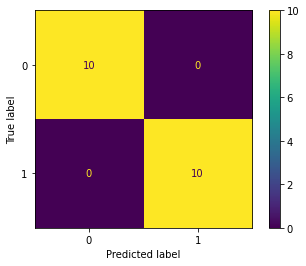

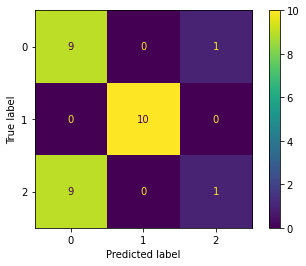

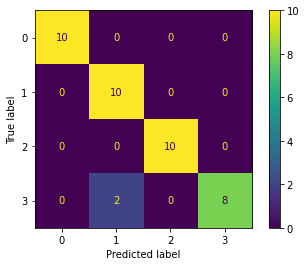

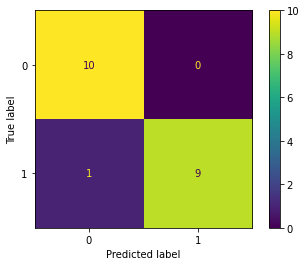

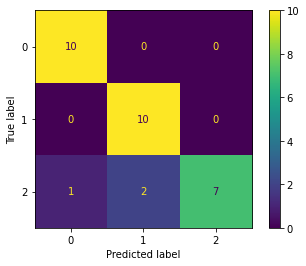

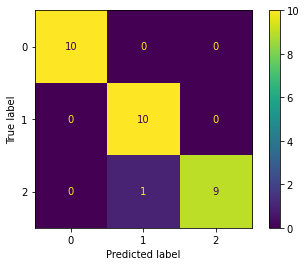

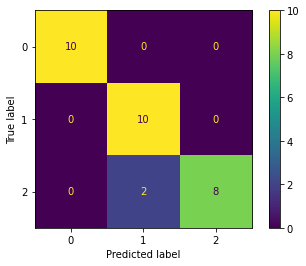

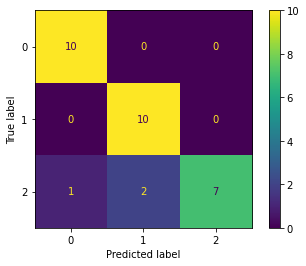

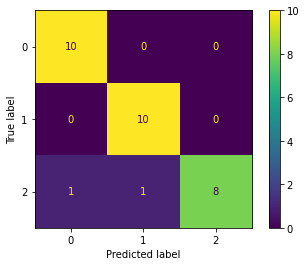

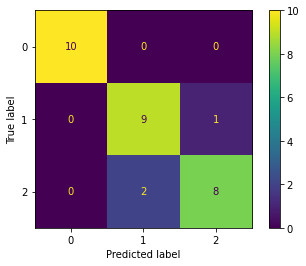

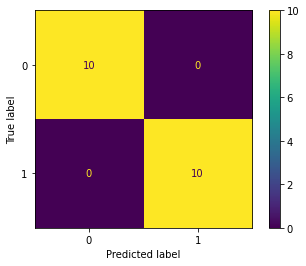

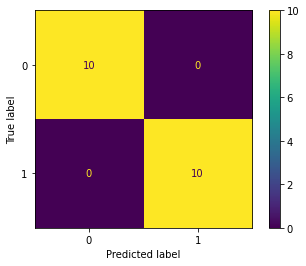

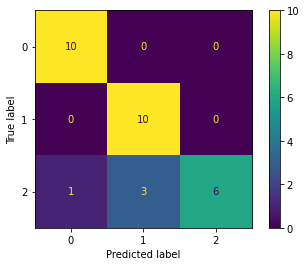

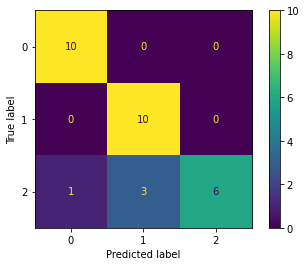

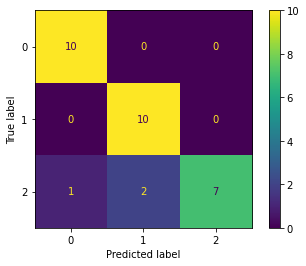

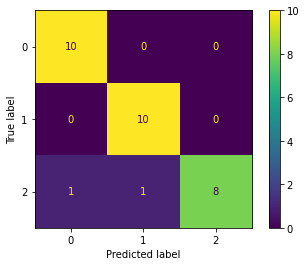

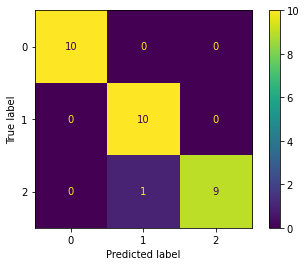

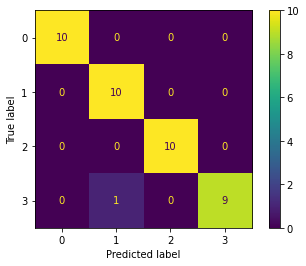

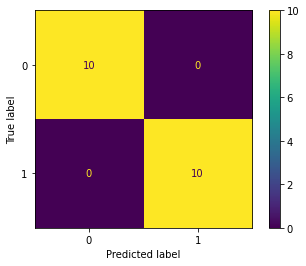

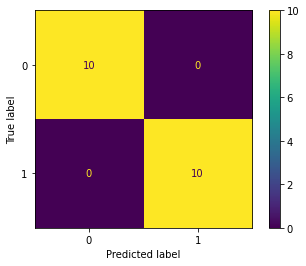

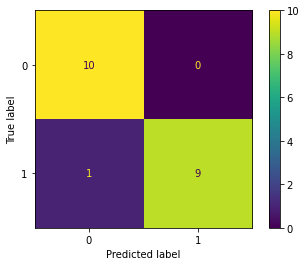

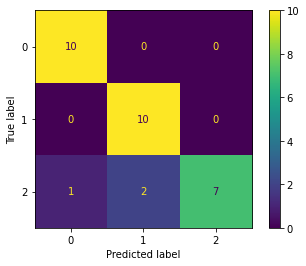

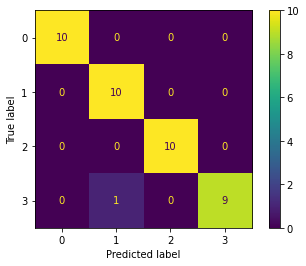

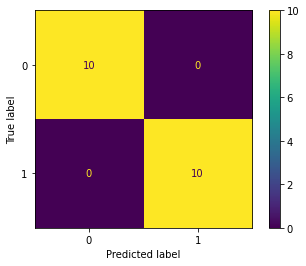

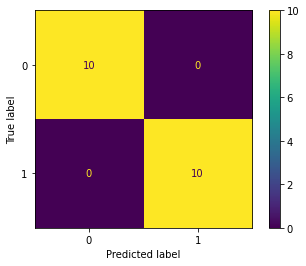

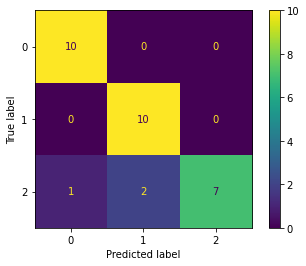

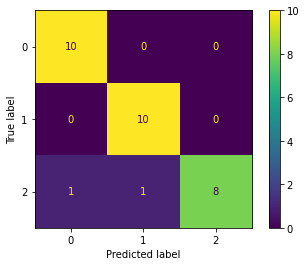

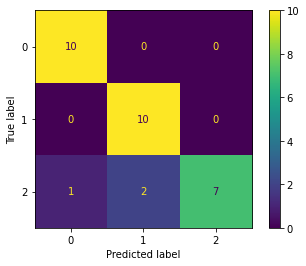

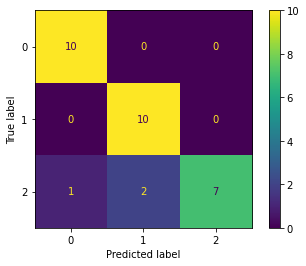

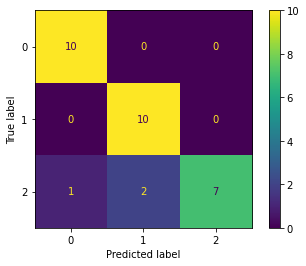

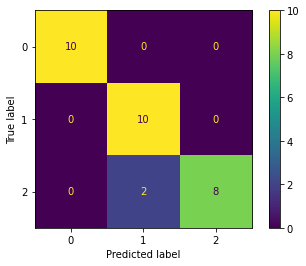

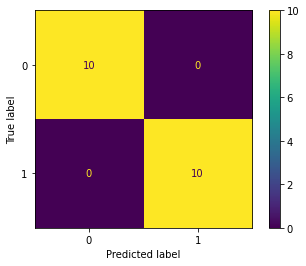

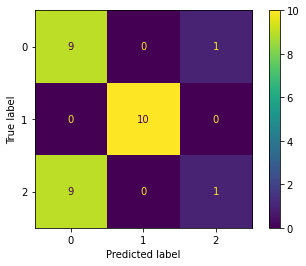

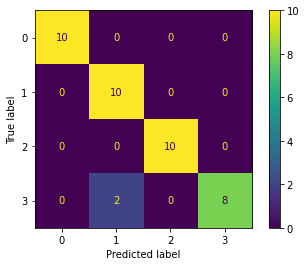

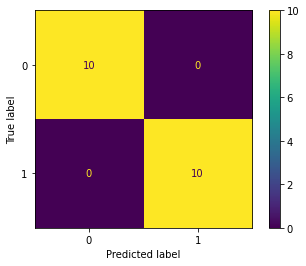

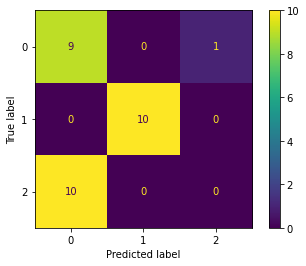

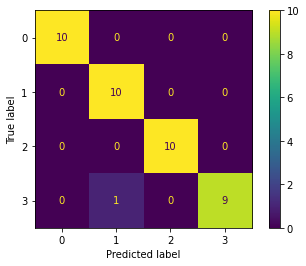

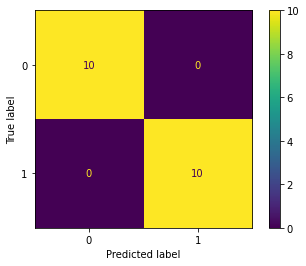

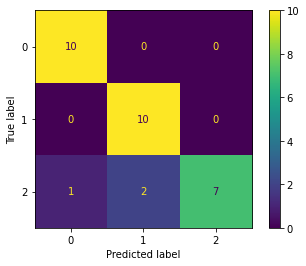

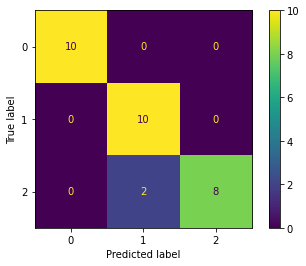

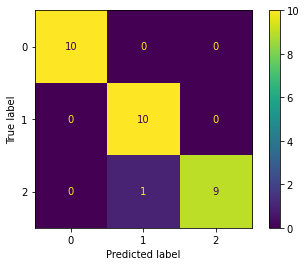

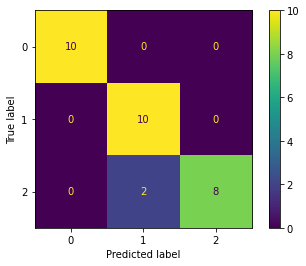

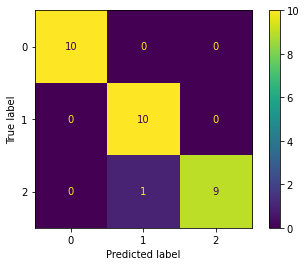

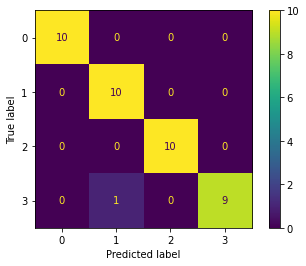

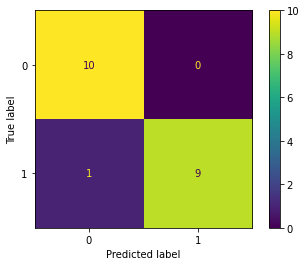

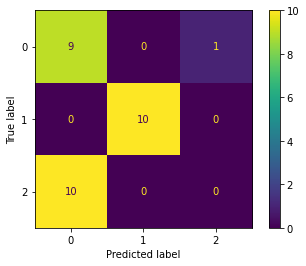

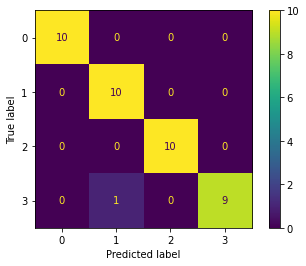

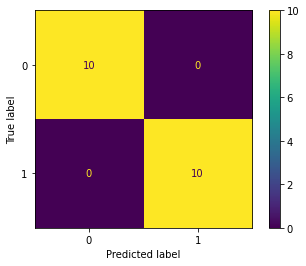

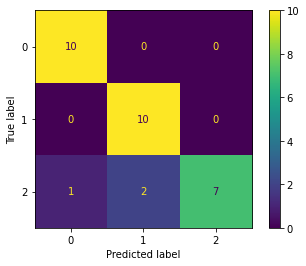

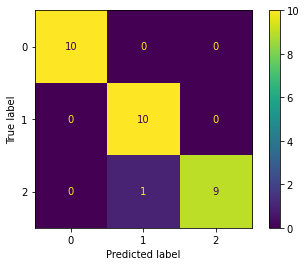

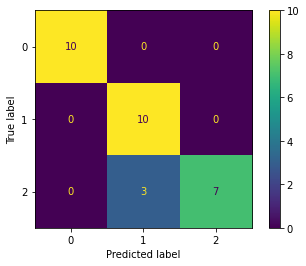

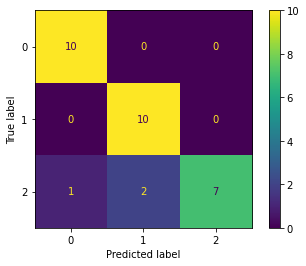

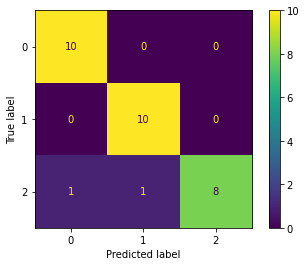

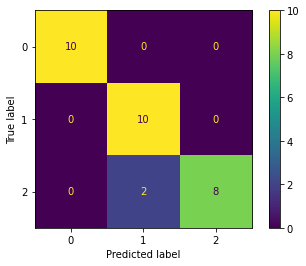

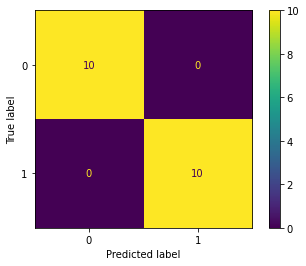

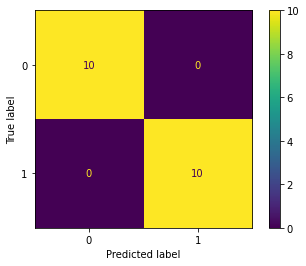

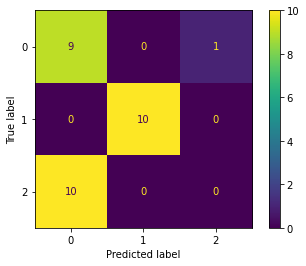

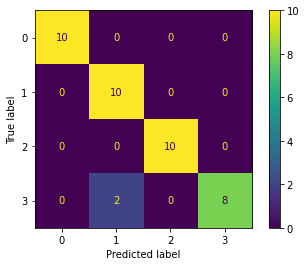

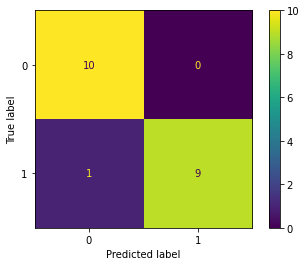

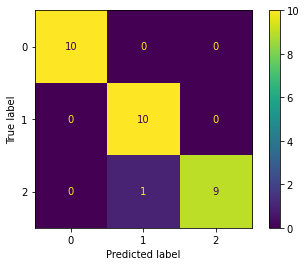

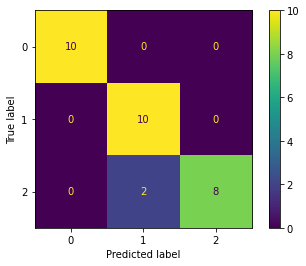

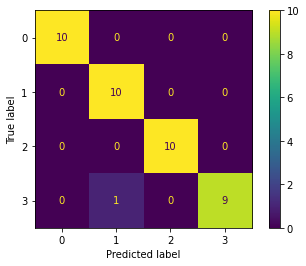

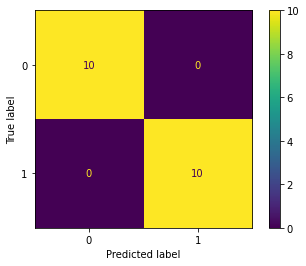

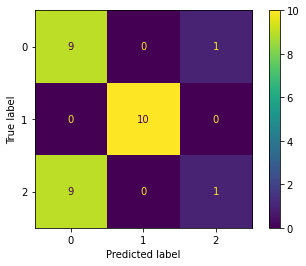

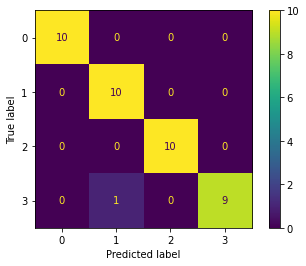

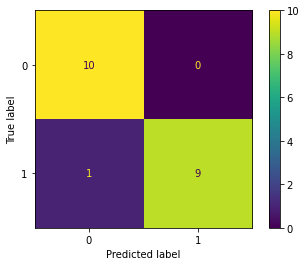

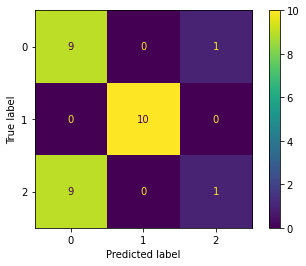

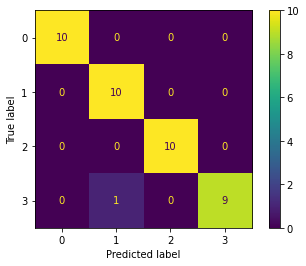

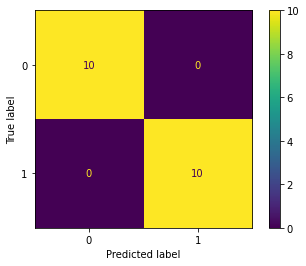

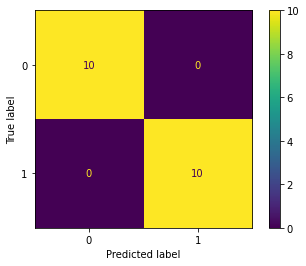

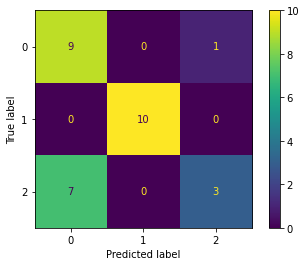

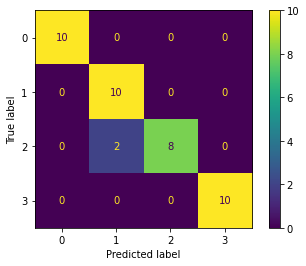

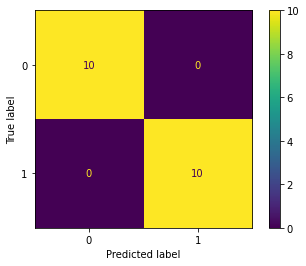

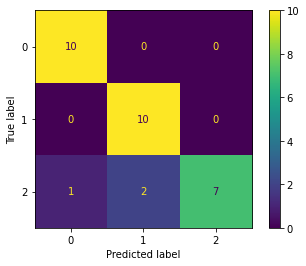

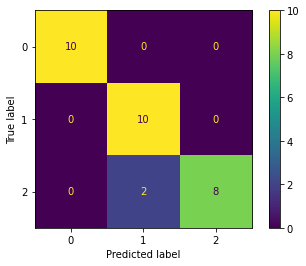

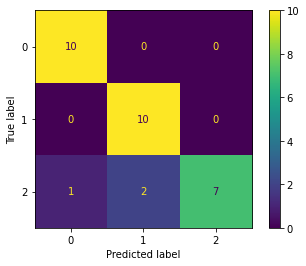

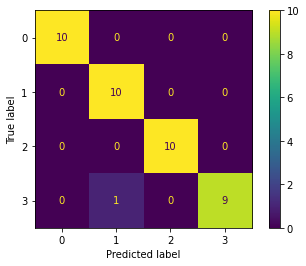

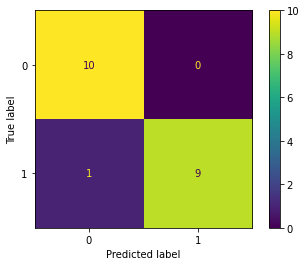

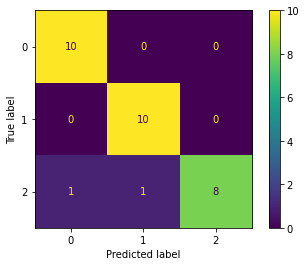

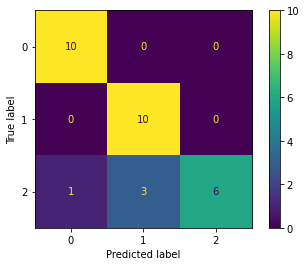

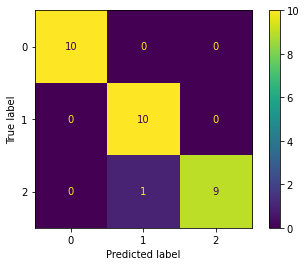

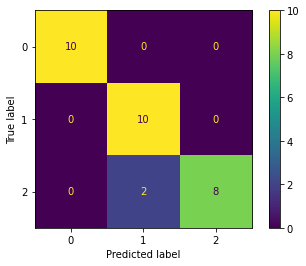

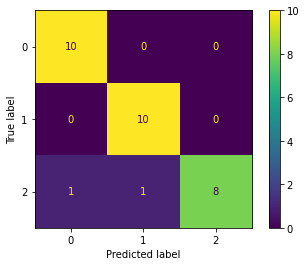

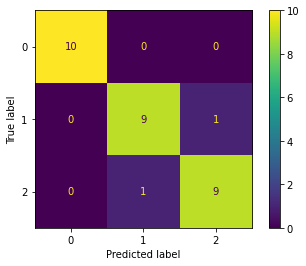

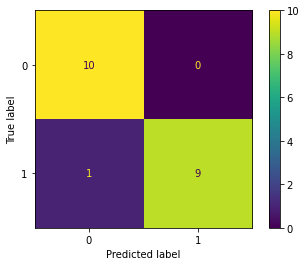

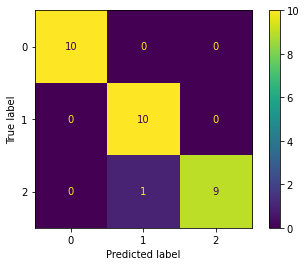

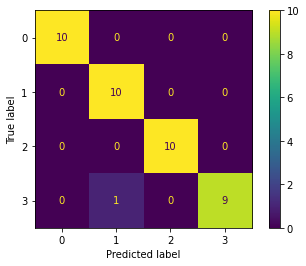

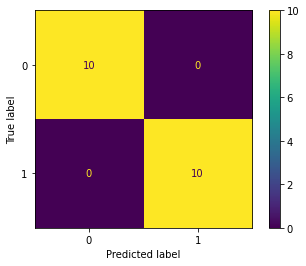

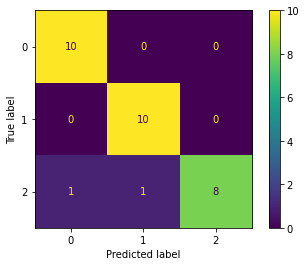

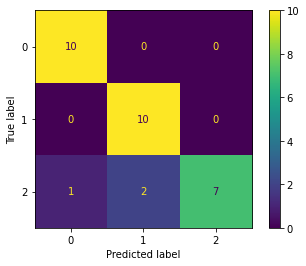

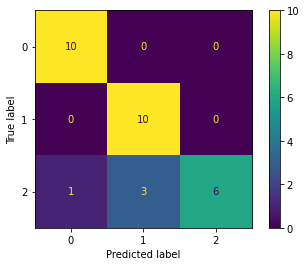

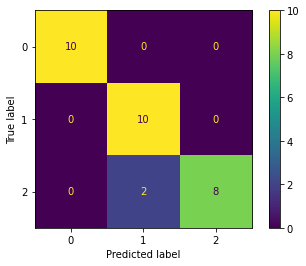

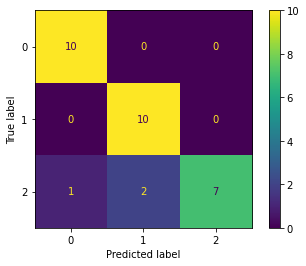

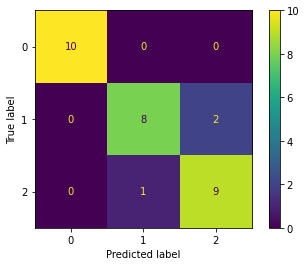

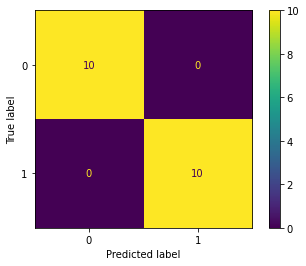

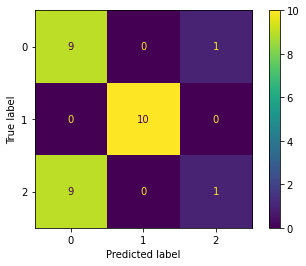

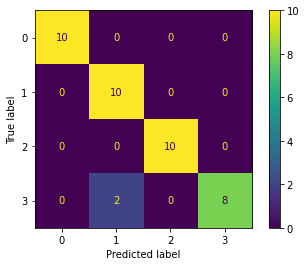

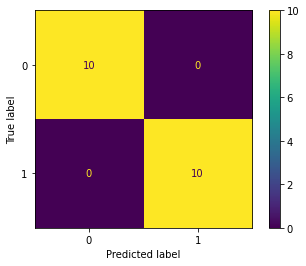

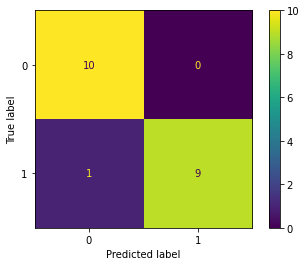

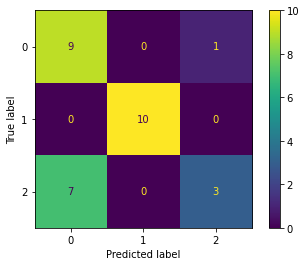

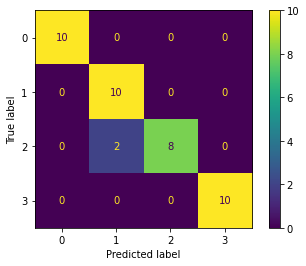

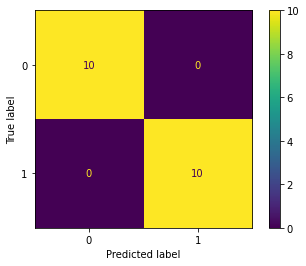

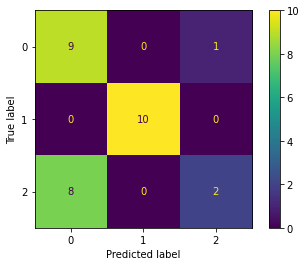

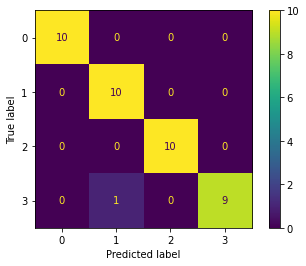

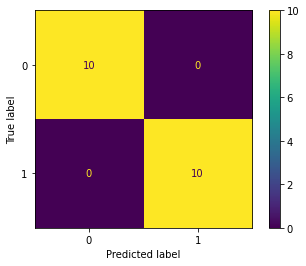

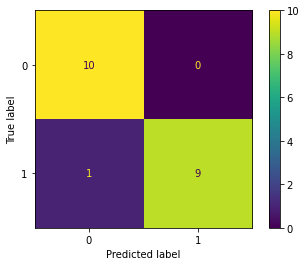

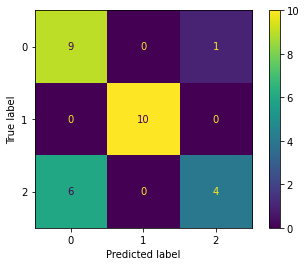

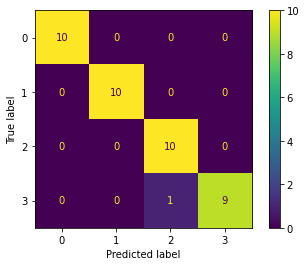

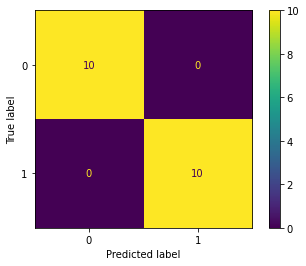

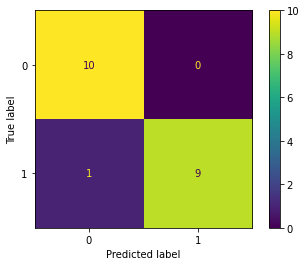

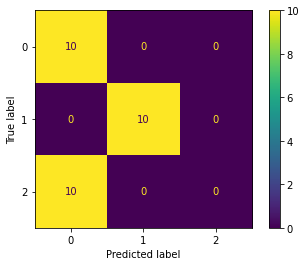

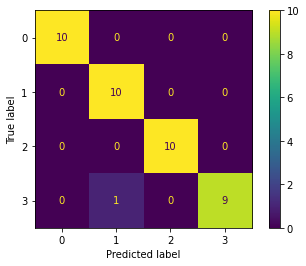

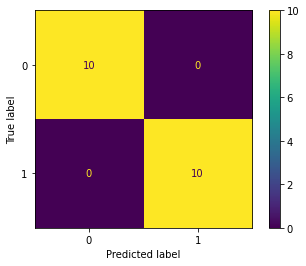

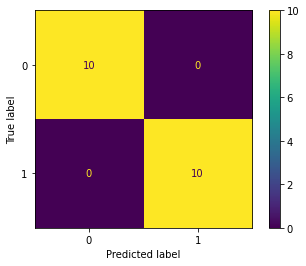

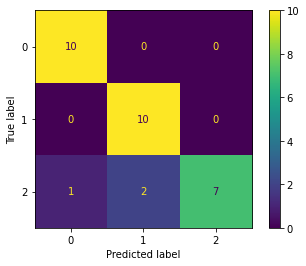

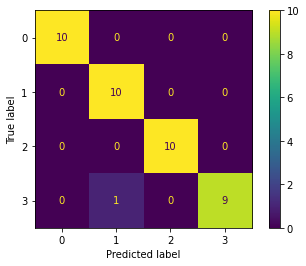

In [52]:
n_exps = 25

ground_truth = [0,1,2,3]

pred_iou = []
for i in range(n_exps):
    print("========== Experiment %s ==========" % str(i+1))
    known_classes = [0,1]
    known_classes_order = []
    
    model = None
    
    retrains = 0
    while len(known_classes) < len(ground_truth) and retrains < 5:
        print("Known classes:", known_classes)
        known_classes_order.append(known_classes.copy())
        
        #feature_idxs = [*range(3,16),*range(22,28)]
        feature_idxs = [*range(3,13),*range(22,28)] # without jitter force
        #feature_idxs = [*range(3,19),*range(22,28)] # with object position
        Xtrain, Ttrain, Xtest, Ttest = make_train_test_data(known_classes, crop_len, feature_idxs)
        print()

        model = train_classifier(Xtrain, Ttrain, len(known_classes))
        print()

        # check classifier on the test data
        classes, probs = model.use(Xtest)

        # make confusion matrix
        cm = sklearn.metrics.confusion_matrix(Ttest, classes)
        disp = ConfusionMatrixDisplay(cm)
        disp.plot()

        novel_classes, dissimilarities = compare_classes(model, Xtrain.shape[-1]//10)
        gated_dissimilarities = [dissimilarities[i] if novel_classes[i] == True \
            else float('inf') for i in range(len(dissimilarities))]
        
        gated_dissimilarities = [gated_dissimilarities[i] if gated_dissimilarities[i] == gated_dissimilarities[i] \
            else float('inf') for i in range(len(gated_dissimilarities))]
        
        if np.min(gated_dissimilarities) == float('inf'):
            print("No novel class found")
            retrains += 1
            print("Retraining (%s)" % retrains)
        else:
            new_class = np.argmin(gated_dissimilarities)
            known_classes.append(new_class)
            retrains = 0

            print("Most novel class:", known_classes[-1])
        print()
        
    print("Known classes:", known_classes)
    known_classes_order.append(known_classes.copy())
    
    feature_idxs = [*range(3,16),*range(22,28)]
    #feature_idxs = [*range(3,13),*range(22,28)] # without jitter force
    #feature_idxs = [*range(3,19),*range(22,28)] # with object position
    Xtrain, Ttrain, Xtest, Ttest = make_train_test_data(known_classes, crop_len, feature_idxs)
    print()

    model = train_classifier(Xtrain, Ttrain, len(known_classes))
    print()

    # check classifier on the test data
    classes, probs = model.use(Xtest)

    # make confusion matrix
    cm = sklearn.metrics.confusion_matrix(Ttest, classes)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()

    novel_classes, dissimilarities = compare_classes(model, Xtrain.shape[-1]//10)
    gated_dissimilarities = [dissimilarities[i] if novel_classes[i] == True \
        else float('inf') for i in range(len(dissimilarities))]
    
    gated_dissimilarities = [gated_dissimilarities[i] if gated_dissimilarities[i] == gated_dissimilarities[i] \
        else float('inf') for i in range(len(gated_dissimilarities))]
    
    if np.min(gated_dissimilarities) != float('inf'):
        new_class = np.argmin(gated_dissimilarities)
        known_classes.append(new_class)
        
    print("Known classes:", known_classes)
    known_classes_order.append(known_classes.copy())
    
    print("Order of acquisition:", known_classes_order)

    pred_iou.append(np.intersect1d(known_classes[2:],ground_truth[2:]).shape[0]/\
                    np.union1d(known_classes[2:],ground_truth[2:]).shape[0])
    print(pred_iou,pred_iou[-1])
    print()
    
print(np.sum(pred_iou)/len(pred_iou))

Same as above but limiting the number of retrains to 2.

========== Experiment 1 ==========
Known classes: [0, 1]
(1800, 16) (1800,) (200, 16) (200,)
(180, 160) (180,) (20, 160) (20,)
(180, 1, 160) (180,) (20, 1, 160) (20,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.001
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: nan
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0010877251625061035
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Diss

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in double_scalars
/Users/n

Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0
Angle from sim_mean to new_mean: 5.960464477539063e-08
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: inf


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: True

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0010877251625061035
Angle from sim_mean to new_mean: 8.749961853027344e-05
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.08044276398706779
Outlier ratio: 3.1533974289726694
Dissimilarity from most similar class: 2.187488645969118
Likely novel class: False

New class: 4
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0
Angle from sim_mean to new_mean: 5.960464477539063e-08
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: inf
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: True

No novel class found
Retraining (1)

Known classes: [0, 1]
(1800, 16) (1800,) (200, 16) (200,)
(180, 160) (180,) (20, 160) (20,)
(180, 1, 160) (180,) (20, 1, 160) (20,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.002
adam: Ep

Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 3
Most similar class: 3
Angle from sim_mean to sim_mean+std: 0.1350259780883789
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 4
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.011796653270721436
Angle from sim_mean to new_mean: 2.9146671295166016e-05
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0024707576484854607
Outlier ratio: 1.1176327081220854
Dissimilarity from most similar class: 1.36995573699564
Likely novel class: False

Known classes: [0, 1, 3, 2]
Order of acquisition: [[0, 1], [0, 1], [0, 1, 3], [0, 1, 3], [0, 1, 3, 2], [0, 1, 3, 2]]
[1.0] 1.0

========== Experiment 2 ==========
Known classes: [0, 1]
(1800, 16) (1800,) (200, 16) (200,)
(180, 160) (180,) (20, 160) (20,)
(180, 1, 

Most similar class: 0
Angle from sim_mean to sim_mean+std: 5.960464477539063e-08
Angle from sim_mean to new_mean: 5.960464477539063e-08
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 1.0
Outlier ratio: 15.453658536585365
Dissimilarity from most similar class: 3168.0
Likely novel class: True

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 7.748603820800781e-07
Angle from sim_mean to new_mean: 2.205371856689453e-06
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 2.8461538461538463
Outlier ratio: 20.125490196078434
Dissimilarity from most similar class: 3370.7218934911243
Likely novel class: True

New class: 4
Most similar class: 0
Angle from sim_mean to sim_mean+std: 5.960464477539063e-08
Angle from sim_mean to new_mean: 1.1920928955078125e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 2.0
Outlier ratio: 2.317073170731707
Dissimilarity from most similar class: 949.9999999999999
Likely novel clas

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in double_scalars
/Users/nik

Most similar class: 0
Angle from sim_mean to sim_mean+std: 5.960464477539063e-08
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: False

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: nan
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: False

New class: 4
Most similar class: 0
Angle from sim_mean to sim_mean+std: 5.960464477539063e-08
Angle from sim_mean to new_mean: 5.960464477539063e-08
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 1.0
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: True

No novel class found
Retraining (1)

Known classes: [0, 1]
(1800, 16) (1800,) (200, 16) (200,)
(180, 160) (180,) (20, 160) (20,)
(180, 

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


adam: Epoch 50 Loss 0.001
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 1.1920928955078125e-07
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 5.1021575927734375e-05
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 0
Angle from sim_mean to sim_mean+std: 1.1920928955078125e-07
Angle from sim_mean to new_mean: -1.19209289550

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in double_scalars


Most similar class: 0
Angle from sim_mean to sim_mean+std: 8.422136306762695e-05
Angle from sim_mean to new_mean: 4.76837158203125e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.005661712668082095
Outlier ratio: 618.170547845529
Dissimilarity from most similar class: 936.1190562409813
Likely novel class: True

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0016191601753234863
Angle from sim_mean to new_mean: 0.004565179347991943
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 2.8194735873366463
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: True

New class: 4
Most similar class: 0


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


Angle from sim_mean to sim_mean+std: 8.422136306762695e-05
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 88.43177265931972
Dissimilarity from most similar class: 0.0
Likely novel class: False

Known classes: [0, 1, 2]
Order of acquisition: [[0, 1], [0, 1], [0, 1], [0, 1, 2]]
[1.0, 1.0, 0.3333333333333333, 0.5] 0.5

========== Experiment 5 ==========
Known classes: [0, 1]
(1800, 16) (1800,) (200, 16) (200,)
(180, 160) (180,) (20, 160) (20,)
(180, 1, 160) (180,) (20, 1, 160) (20,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.002
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.001
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0
Angle from sim_mean to new_mea

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in double_scalars
/Users/n

Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: nan
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: False

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 1.5497207641601562e-06
Angle from sim_mean to new_mean: 5.364418029785156e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.34615384615384615
Outlier ratio: 6.2507331378299105
Dissimilarity from most similar class: 56.7559171597633
Likely novel class: True

New class: 4
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: nan
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: False

Most n

Most similar class: 0
Angle from sim_mean to sim_mean+std: 4.76837158203125e-07
Angle from sim_mean to new_mean: 8.344650268554688e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 1.75
Outlier ratio: 97982.87364425162
Dissimilarity from most similar class: 39523841.65625
Likely novel class: True

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.3074052929878235
Angle from sim_mean to new_mean: 1.226571872830391
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 3.9900805249927047
Outlier ratio: 2.4071569214653725
Dissimilarity from most similar class: 1099.3854631097502
Likely novel class: True

New class: 4
Most similar class: 0
Angle from sim_mean to sim_mean+std: 4.76837158203125e-07
Angle from sim_mean to new_mean: 5.960464477539063e-08
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.125
Outlier ratio: 1.3015184381778742
Dissimilarity from most similar class: 37.5
Likely novel class: True

Mos

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/sklearn/metrics/_plot/confusion_matrix.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Angle from sim_mean to sim_mean+std: 0.04425513744354248
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0044596195220947266
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.04425513744354248
Angle from sim_mean to new_mean: 0.0001150369644165039
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.002599403618693079
Outlier ratio: 1.0279532554928055
Dissimilarity from most similar class: 1.5666758196751036
Likely novel class: False

New class: 3
Most similar class: 3
Angle from sim_mean to sim_mean+std: 0.431060791015625
Angle

adam: Epoch 50 Loss 0.002
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: nan
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 3.159046173095703e-06
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: False

New class: 2


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in double_scalars
/Users/n

Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0
Angle from sim_mean to new_mean: 5.960464477539063e-08
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: inf


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: True

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 3.159046173095703e-06
Angle from sim_mean to new_mean: 4.76837158203125e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.1509433962264151
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: True

New class: 4
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0
Angle from sim_mean to new_mean: 5.960464477539063e-08
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: inf
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: True

No novel class found
Retraining (1)

Known classes: [0, 1]
(1800, 16) (1800,) (200, 16) (200,)
(180, 160) (180,) (20, 160) (20,)
(180, 1, 160) (180,) (20, 1, 160) (20,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.001
adam: Epoch 100 Loss 0.001
adam: Epoch 1

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in double_scalars
/Users/n

Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: nan
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: False

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 5.960464477539063e-08
Angle from sim_mean to new_mean: 5.960464477539063e-08
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 1.0
Outlier ratio: 6.466666666666667
Dissimilarity from most similar class: 97.0
Likely novel class: True

New class: 4
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: nan
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: False

Most novel class: 3

Known classes: [0, 1, 3]
(2700, 16) (2700,) (300, 16) (300,)
(270, 160) (270,) (30, 160) (30,)
(270, 1, 160) (270,) (

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in double_scalars


Angle from sim_mean to sim_mean+std: 3.337860107421875e-06
Angle from sim_mean to new_mean: 2.980232238769531e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.08928571428571429
Outlier ratio: 18715.373141486813
Dissimilarity from most similar class: 373292.91772959183
Likely novel class: True

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.002785325050354004
Angle from sim_mean to new_mean: 0.0004929900169372559
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.17699550609886583
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: True

New class: 4


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


Most similar class: 0
Angle from sim_mean to sim_mean+std: 3.337860107421875e-06
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 2657.767625899281
Dissimilarity from most similar class: 0.0
Likely novel class: False

Most novel class: 2

Known classes: [0, 1, 2]
(2700, 16) (2700,) (300, 16) (300,)
(270, 160) (270,) (30, 160) (30,)
(270, 1, 160) (270,) (30, 1, 160) (30,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.249
adam: Epoch 100 Loss 0.238
adam: Epoch 150 Loss 0.229
adam: Epoch 200 Loss 0.217
adam: Epoch 250 Loss 0.204
adam: Epoch 300 Loss 0.195
adam: Epoch 350 Loss 0.188
adam: Epoch 400 Loss 0.183
adam: Epoch 450 Loss 0.180
adam: Epoch 500 Loss 0.177

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.06277066469192505
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.

Angle from sim_mean to sim_mean+std: 0.028302311897277832
Angle from sim_mean to new_mean: 0.00036472082138061523
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.012886608793810048
Outlier ratio: 1.2704894266359672
Dissimilarity from most similar class: 9.937660809446951
Likely novel class: False

Most novel class: 3

Known classes: [0, 1, 2, 3]
(3600, 19) (3600,) (400, 19) (400,)
(360, 190) (360,) (40, 190) (40,)
(360, 1, 190) (360,) (40, 1, 190) (40,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.092
adam: Epoch 100 Loss 0.030
adam: Epoch 150 Loss 0.021
adam: Epoch 200 Loss 0.017
adam: Epoch 250 Loss 0.015
adam: Epoch 300 Loss 0.012
adam: Epoch 350 Loss 0.014
adam: Epoch 400 Loss 0.011
adam: Epoch 450 Loss 0.011
adam: Epoch 500 Loss 0.013

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.030542075634002686
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to si

Angle from sim_mean to sim_mean+std: 0.017045557498931885
Angle from sim_mean to new_mean: 5.4836273193359375e-05
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0032170419299454153
Outlier ratio: 1.076546825414274
Dissimilarity from most similar class: 1.821597624513704
Likely novel class: False

Known classes: [0, 1, 2, 2, 3]
Order of acquisition: [[0, 1], [0, 1, 2], [0, 1, 2, 2], [0, 1, 2, 2, 3]]
[1.0, 1.0, 0.3333333333333333, 0.5, 0.5, 0.3333333333333333, 1.0, 0.5, 1.0, 1.0, 1.0] 1.0

========== Experiment 12 ==========
Known classes: [0, 1]
(1800, 16) (1800,) (200, 16) (200,)
(180, 160) (180,) (20, 160) (20,)
(180, 1, 160) (180,) (20, 1, 160) (20,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.001
adam: Epoch 100 Loss 0.000
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 

Angle from sim_mean to sim_mean+std: 0.031501591205596924
Angle from sim_mean to new_mean: 0.0004088878631591797
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.01297991141115856
Outlier ratio: 1.3878561346379064
Dissimilarity from most similar class: 9.129626127486887
Likely novel class: False

Known classes: [0, 1, 3, 2]
Order of acquisition: [[0, 1], [0, 1, 3], [0, 1, 3], [0, 1, 3, 2], [0, 1, 3, 2]]
[1.0, 1.0, 0.3333333333333333, 0.5, 0.5, 0.3333333333333333, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0] 1.0

========== Experiment 13 ==========
Known classes: [0, 1]
(1800, 16) (1800,) (200, 16) (200,)
(180, 160) (180,) (20, 160) (20,)
(180, 1, 160) (180,) (20, 1, 160) (20,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.001
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam

Angle from sim_mean to sim_mean+std: 0.009491920471191406
Angle from sim_mean to new_mean: 1.5795230865478516e-05
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0016640711343313573
Outlier ratio: 1.2335197324748735
Dissimilarity from most similar class: 1.1192269632465242
Likely novel class: False

Known classes: [0, 1, 3]
Order of acquisition: [[0, 1], [0, 1, 3], [0, 1, 3], [0, 1, 3], [0, 1, 3]]
[1.0, 1.0, 0.3333333333333333, 0.5, 0.5, 0.3333333333333333, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 0.5] 0.5

========== Experiment 14 ==========
Known classes: [0, 1]
(1800, 16) (1800,) (200, 16) (200,)
(180, 160) (180,) (20, 160) (20,)
(180, 1, 160) (180,) (20, 1, 160) (20,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.001
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in double_scalars
/Users/n

Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.00010728836059570312
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 0


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in double_scalars


Angle from sim_mean to sim_mean+std: 0.0
Angle from sim_mean to new_mean: 5.960464477539063e-08
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: inf


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in double_scalars


Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: True

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.00010728836059570312
Angle from sim_mean to new_mean: 1.6450881958007812e-05
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.15333333333333332
Outlier ratio: 2.0292506656523392
Dissimilarity from most similar class: 4.544544444444444
Likely novel class: False

New class: 4
Most similar class: 0


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


Angle from sim_mean to sim_mean+std: 0.0
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: nan
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: False

No novel class found
Retraining (1)

Known classes: [0, 1]
(1800, 16) (1800,) (200, 16) (200,)
(180, 160) (180,) (20, 160) (20,)
(180, 1, 160) (180,) (20, 1, 160) (20,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.001
adam: Epoch 100 Loss 0.000
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 5.960464477539063e-08
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in double_scalars
/Users/n

Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 8.344650268554688e-07
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 0


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in double_scalars


Angle from sim_mean to sim_mean+std: 0.0
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: nan
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: False

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 8.344650268554688e-07
Angle from sim_mean to new_mean: 6.556510925292969e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.7857142857142857
Outlier ratio: 12.974193548387097
Dissimilarity from most similar class: 225.72448979591837
Likely novel class: True

New class: 4
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: nan
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: False

Most novel class: 3

Known classes: [0, 1, 3]
(2700, 16) (2700,) (300, 16) (300,)
(270, 160) (270,) (30, 160) (30,)
(270, 1, 160) 

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in double_scalars


Most similar class: 0
Angle from sim_mean to sim_mean+std: -1.1920928955078125e-07
Angle from sim_mean to new_mean: 5.960464477539063e-08
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: -0.5
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: False

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 1.430511474609375e-06
Angle from sim_mean to new_mean: 2.4437904357910156e-06
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 1.7083333333333333
Outlier ratio: 7.868495742667929
Dissimilarity from most similar class: 592.0086805555557
Likely novel class: True

New class: 4
Most similar class: 0


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


Angle from sim_mean to sim_mean+std: -1.1920928955078125e-07
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: -0.0
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: False

Most novel class: 3

Known classes: [0, 1, 3]
(2700, 16) (2700,) (300, 16) (300,)
(270, 160) (270,) (30, 160) (30,)
(270, 1, 160) (270,) (30, 1, 160) (30,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.045
adam: Epoch 100 Loss 0.005
adam: Epoch 150 Loss 0.002
adam: Epoch 200 Loss 0.001
adam: Epoch 250 Loss 0.001
adam: Epoch 300 Loss 0.001
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.01333397626876831
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar

Angle from sim_mean to sim_mean+std: 1.1920928955078125e-07
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 46160.873381294965
Dissimilarity from most similar class: 0.0
Likely novel class: False

Most novel class: 3

Known classes: [0, 1, 3]
(2700, 16) (2700,) (300, 16) (300,)
(270, 160) (270,) (30, 160) (30,)
(270, 1, 160) (270,) (30, 1, 160) (30,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.037
adam: Epoch 100 Loss 0.005
adam: Epoch 150 Loss 0.002
adam: Epoch 200 Loss 0.001
adam: Epoch 250 Loss 0.001
adam: Epoch 300 Loss 0.001
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.003794074058532715
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity fro

Angle from sim_mean to sim_mean+std: 0.006664574146270752
Angle from sim_mean to new_mean: 2.8014183044433594e-06
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0004203446826397646
Outlier ratio: 1.071555160591446
Dissimilarity from most similar class: 0.2358349005423534
Likely novel class: False

No novel class found
Retraining (1)

Known classes: [0, 1, 3]
(2700, 16) (2700,) (300, 16) (300,)
(270, 160) (270,) (30, 160) (30,)
(270, 1, 160) (270,) (30, 1, 160) (30,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.025
adam: Epoch 100 Loss 0.004
adam: Epoch 150 Loss 0.002
adam: Epoch 200 Loss 0.001
adam: Epoch 250 Loss 0.001
adam: Epoch 300 Loss 0.001
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0011389851570129395
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from 

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in double_scalars


Most similar class: 0
Angle from sim_mean to sim_mean+std: -1.1920928955078125e-07
Angle from sim_mean to new_mean: 5.960464477539063e-08
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: -0.5
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: False

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.004543006420135498
Angle from sim_mean to new_mean: 0.00023382902145385742
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.05147010587911151
Outlier ratio: 0.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 4
Most similar class: 0


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in double_scalars


Angle from sim_mean to sim_mean+std: -1.1920928955078125e-07
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: -0.0
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: False

No novel class found
Retraining (1)

Known classes: [0, 1]
(1800, 16) (1800,) (200, 16) (200,)
(180, 160) (180,) (20, 160) (20,)
(180, 1, 160) (180,) (20, 1, 160) (20,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.001
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 1.430511474609375e-06
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity fr

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in double_scalars


Most similar class: 0
Angle from sim_mean to sim_mean+std: 1.430511474609375e-06
Angle from sim_mean to new_mean: 8.940696716308594e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.625
Outlier ratio: 37351.661703543505
Dissimilarity from most similar class: 5846896.8359375
Likely novel class: True

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.016878068447113037
Angle from sim_mean to new_mean: 0.009645164012908936
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.5714613637888596
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: True

New class: 4
Most similar class: 0


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


Angle from sim_mean to sim_mean+std: 1.430511474609375e-06
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.8614207286641156
Dissimilarity from most similar class: 0.0
Likely novel class: False

Most novel class: 2

Known classes: [0, 1, 2]
(2700, 16) (2700,) (300, 16) (300,)
(270, 160) (270,) (30, 160) (30,)
(270, 1, 160) (270,) (30, 1, 160) (30,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.250
adam: Epoch 100 Loss 0.240
adam: Epoch 150 Loss 0.229
adam: Epoch 200 Loss 0.211
adam: Epoch 250 Loss 0.197
adam: Epoch 300 Loss 0.188
adam: Epoch 350 Loss 0.182
adam: Epoch 400 Loss 0.178
adam: Epoch 450 Loss 0.175
adam: Epoch 500 Loss 0.188

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0074117183685302734
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity fro

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in double_scalars
/Users/n

Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0
Angle from sim_mean to new_mean: 7.748603820800781e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: inf


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: True

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.021799325942993164
Angle from sim_mean to new_mean: 0.005498349666595459
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.25222567344394253
Outlier ratio: 1.036622034728896
Dissimilarity from most similar class: 8.582354189199537
Likely novel class: False

New class: 4
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: nan
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: False

No novel class found
Retraining (1)

Known classes: [0, 1]
(1800, 16) (1800,) (200, 16) (200,)
(180, 160) (180,) (20, 160) (20,)
(180, 1, 160) (180,) (20, 1, 160) (20,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.001
adam: Epoch 100 Loss 0.001
a

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in double_scalars
/Users/n

Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: False

New class: 2
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0
Angle from sim_mean to new_mean: -1.1920928955078125e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: -inf


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: False

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0
Angle from sim_mean to new_mean: 5.960464477539063e-08
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: inf
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: True

New class: 4
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: nan
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: False

No novel class found
Retraining (2)

Known classes: [0, 1]
(1800, 19) (1800,) (200, 19) (200,)
(180, 190) (180,) (20, 190) (20,)
(180, 1, 190) (180,) (20, 1, 190) (20,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.001
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: 

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in double_scalars


Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.000514686107635498
Angle from sim_mean to new_mean: 1.1920928955078125e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.00023161551823972206
Outlier ratio: 92.72080577350613
Dissimilarity from most similar class: 6.307124671713167
Likely novel class: False

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 6.842613220214844e-05
Angle from sim_mean to new_mean: 0.00021761655807495117
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 3.1803135888501743
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: True

New class: 4
Most similar class: 0


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


Angle from sim_mean to sim_mean+std: 0.000514686107635498
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 13.58665227653965
Dissimilarity from most similar class: 0.0
Likely novel class: False

Known classes: [0, 1]
Order of acquisition: [[0, 1], [0, 1], [0, 1], [0, 1]]
[1.0, 1.0, 0.3333333333333333, 0.5, 0.5, 0.3333333333333333, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 0.3333333333333333, 1.0, 0.5, 1.0, 1.0, 1.0, 0.0] 0.0

========== Experiment 22 ==========
Known classes: [0, 1]
(1800, 16) (1800,) (200, 16) (200,)
(180, 160) (180,) (20, 160) (20,)
(180, 1, 160) (180,) (20, 1, 160) (20,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.002
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.00

Outlier ratio: 0.9410624899079605
Dissimilarity from most similar class: 24.082644628099168
Likely novel class: False

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 3.5762786865234375e-07
Angle from sim_mean to new_mean: 2.980232238769531e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.8333333333333334
Outlier ratio: 6.344117647058825
Dissimilarity from most similar class: 299.58333333333337
Likely novel class: True

New class: 4
Most similar class: 0
Angle from sim_mean to sim_mean+std: 1.3113021850585938e-06
Angle from sim_mean to new_mean: 5.960464477539063e-08
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.045454545454545456
Outlier ratio: 0.8708218956886808
Dissimilarity from most similar class: 22.28512396694215
Likely novel class: False

Most novel class: 3

Known classes: [0, 1, 3]
(2700, 16) (2700,) (300, 16) (300,)
(270, 160) (270,) (30, 160) (30,)
(270, 1, 160) (270,) (30, 1, 160) (30,)

CUDA not av

Most similar class: 0
Angle from sim_mean to sim_mean+std: 8.344650268554688e-07
Angle from sim_mean to new_mean: 5.960464477539063e-08
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.07142857142857142
Outlier ratio: 5.5261750946758745
Dissimilarity from most similar class: 253.13265306122452
Likely novel class: True

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 6.085634231567383e-05
Angle from sim_mean to new_mean: 1.329183578491211e-05
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.21841332027424093
Outlier ratio: 52.54818907305095
Dissimilarity from most similar class: 36.6236995666901
Likely novel class: True

New class: 4
Most similar class: 0
Angle from sim_mean to sim_mean+std: 8.344650268554688e-07
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.378703497438182
Dissimilarity from most similar class: 0.0
Likely novel class: Fals

Most similar class: 0
Angle from sim_mean to sim_mean+std: 1.7881393432617188e-07
Angle from sim_mean to new_mean: 7.748603820800781e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 4.333333333333333
Outlier ratio: 5499.308154506438
Dissimilarity from most similar class: 9254113.555555556
Likely novel class: True

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.05184459686279297
Angle from sim_mean to new_mean: 0.001963496208190918
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.03787272593491897
Outlier ratio: 1.0406458358849566
Dissimilarity from most similar class: 3.249079373284404
Likely novel class: False

New class: 4
Most similar class: 0
Angle from sim_mean to sim_mean+std: 1.7881393432617188e-07
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 0.6420600858369098
Dissimilarity from most similar class: 0.0
Likely novel class: False

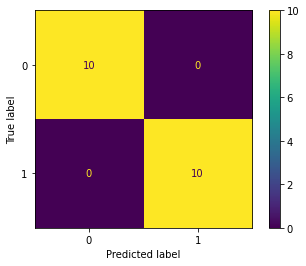

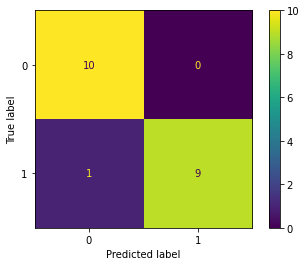

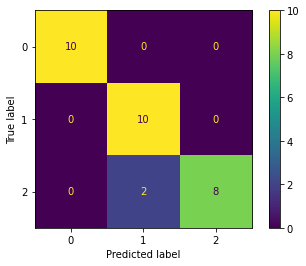

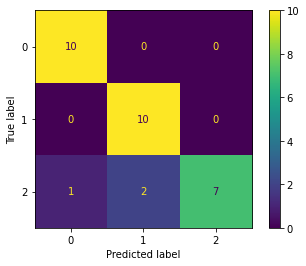

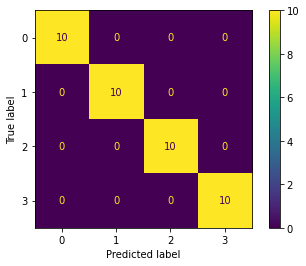

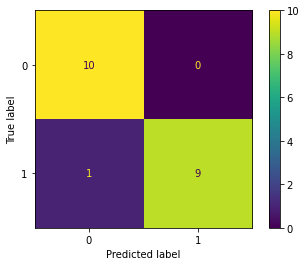

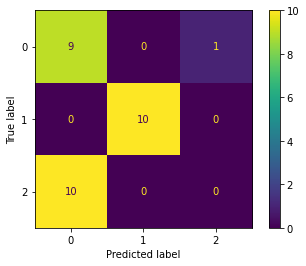

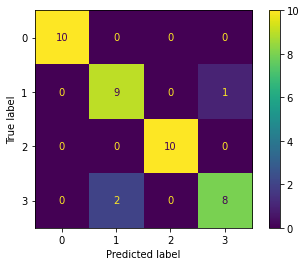

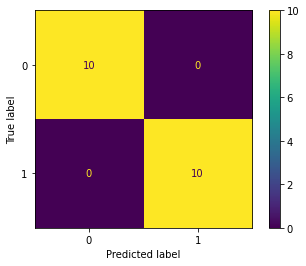

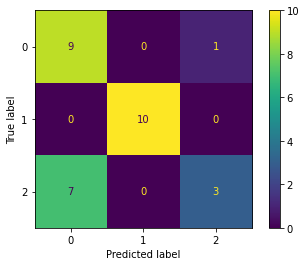

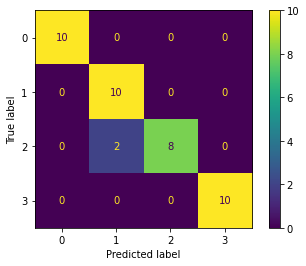

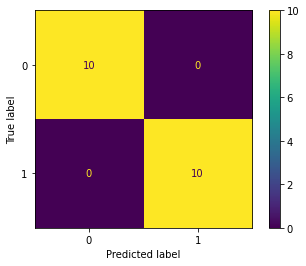

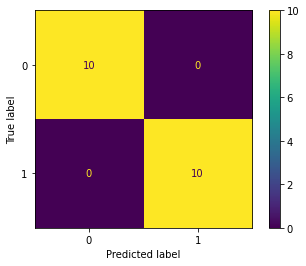

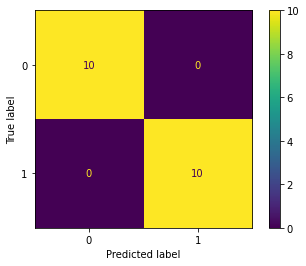

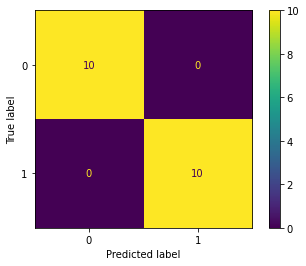

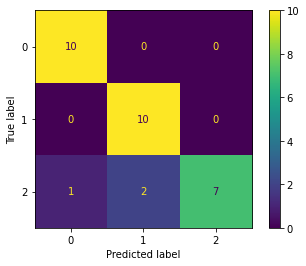

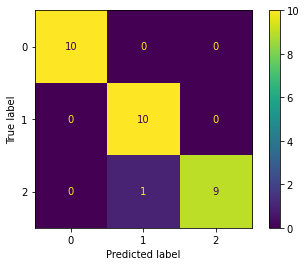

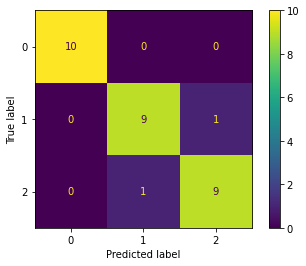

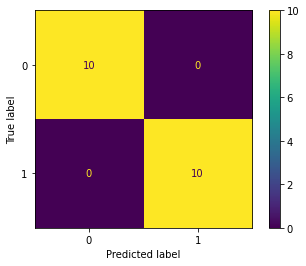

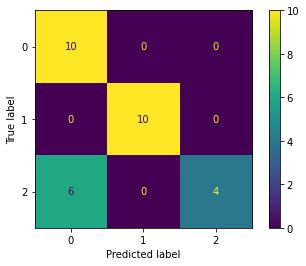

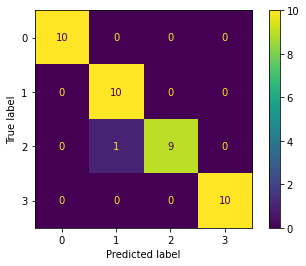

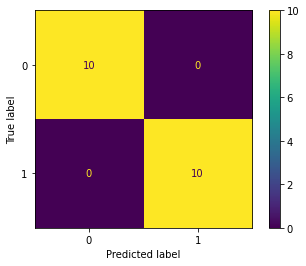

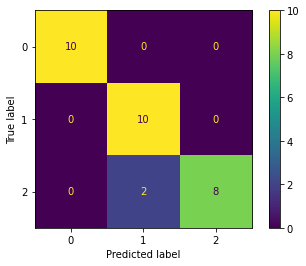

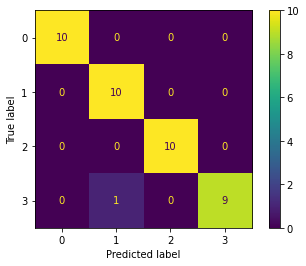

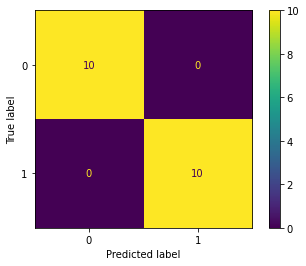

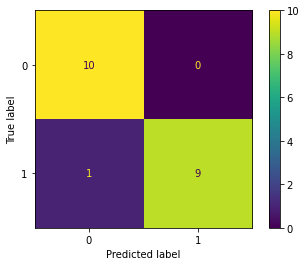

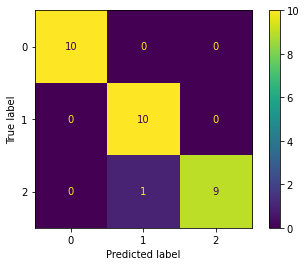

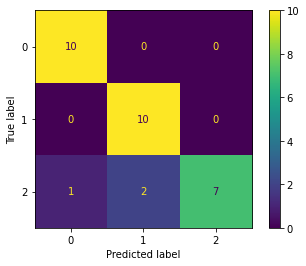

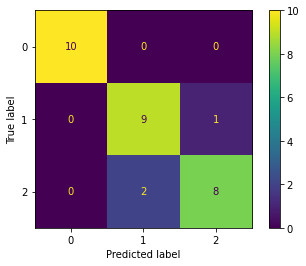

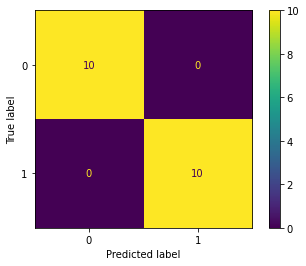

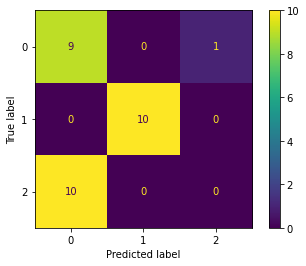

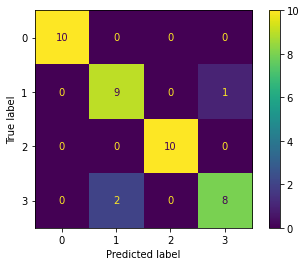

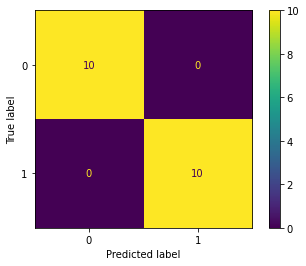

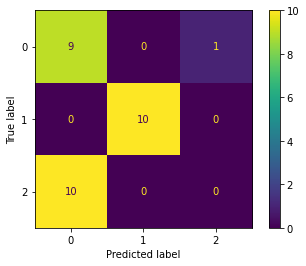

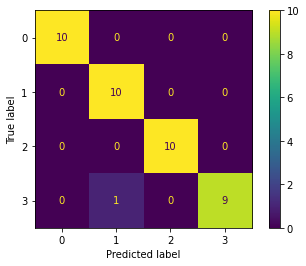

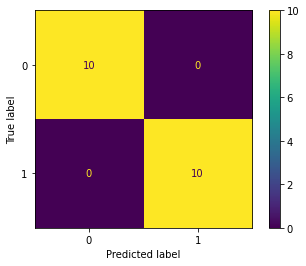

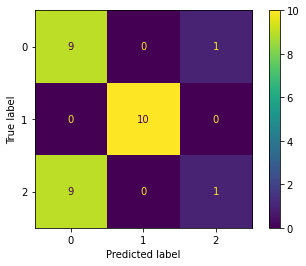

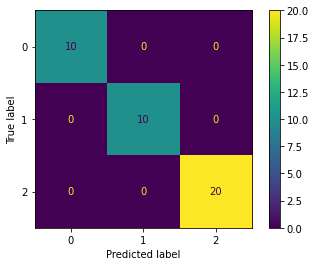

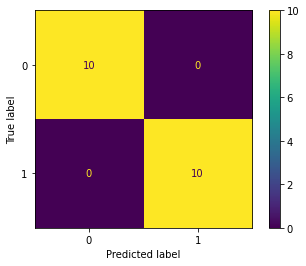

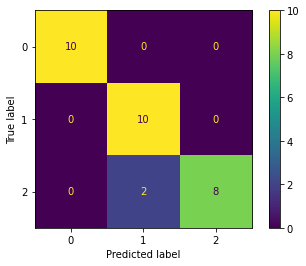

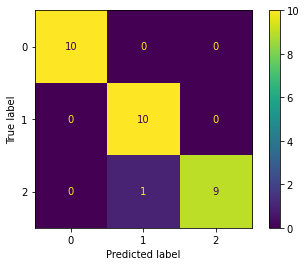

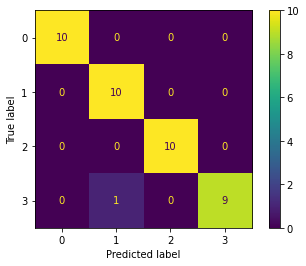

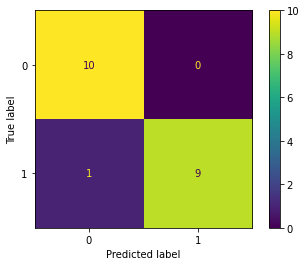

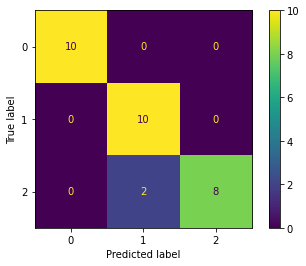

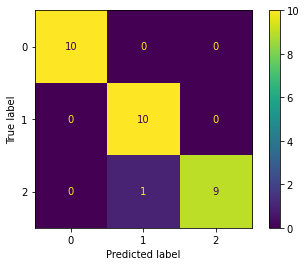

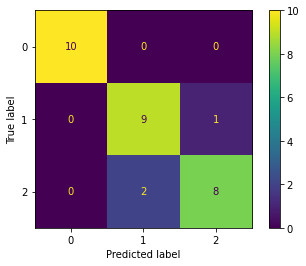

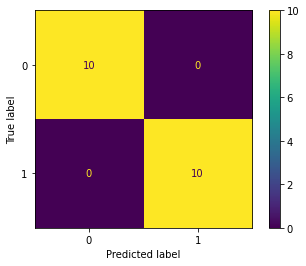

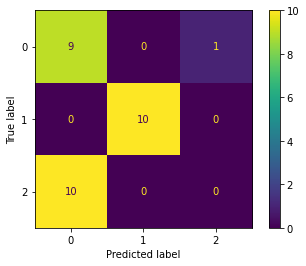

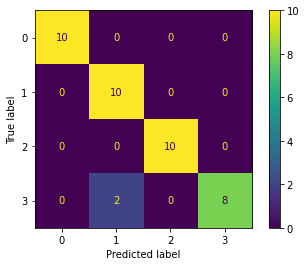

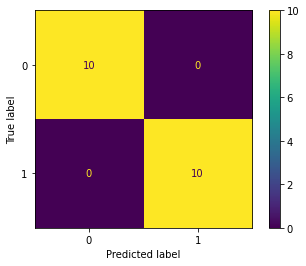

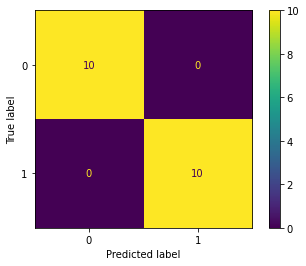

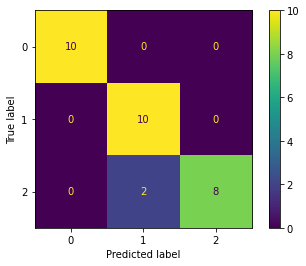

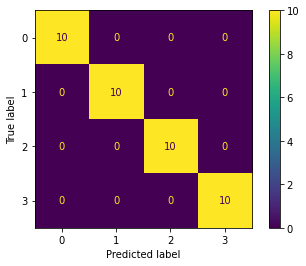

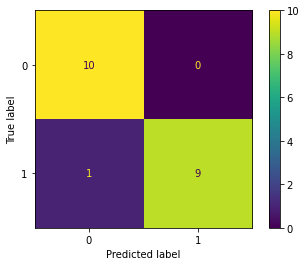

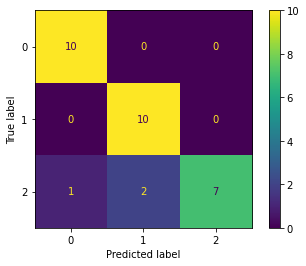

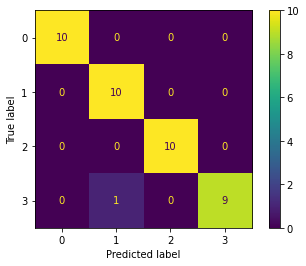

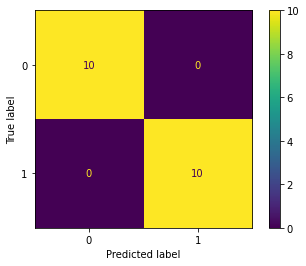

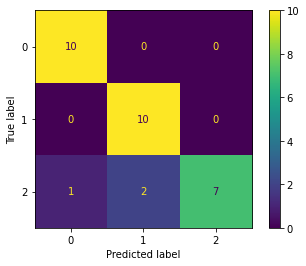

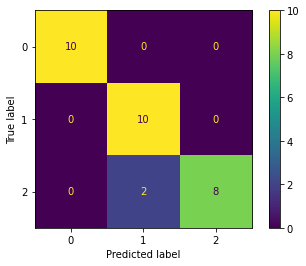

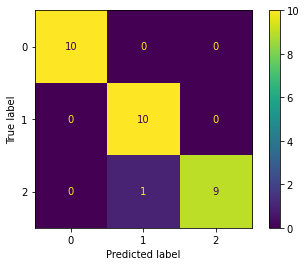

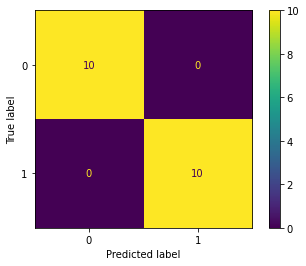

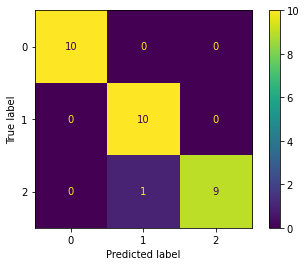

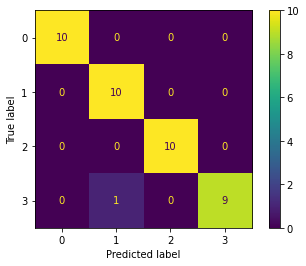

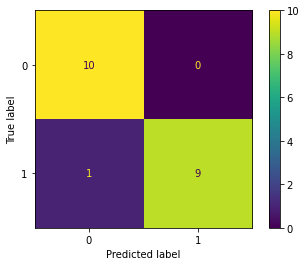

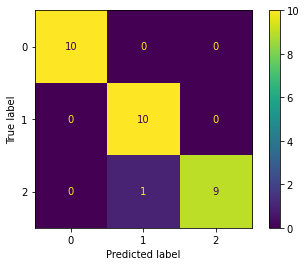

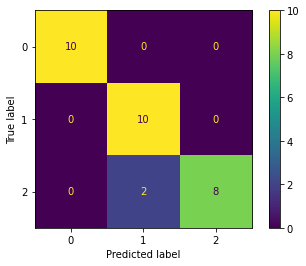

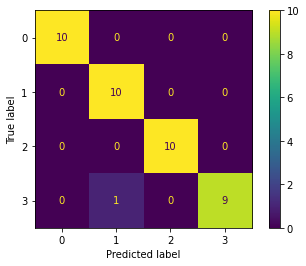

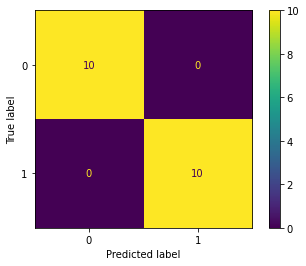

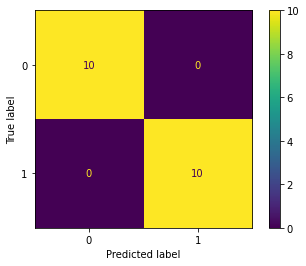

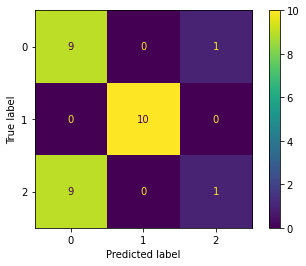

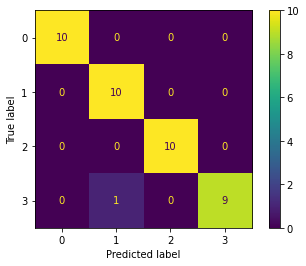

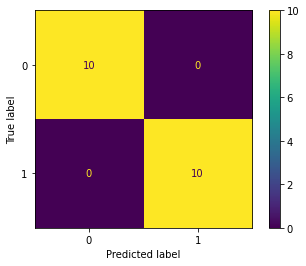

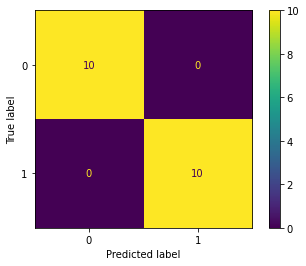

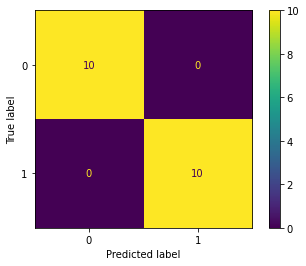

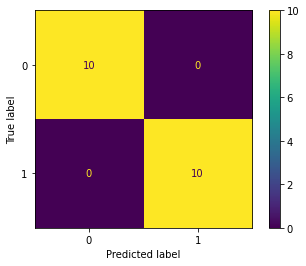

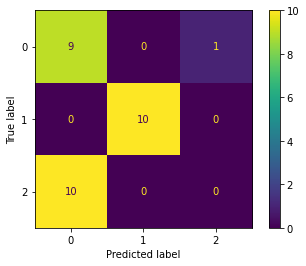

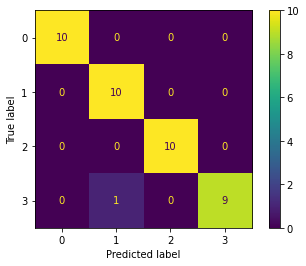

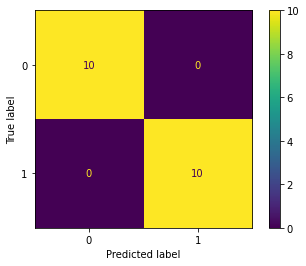

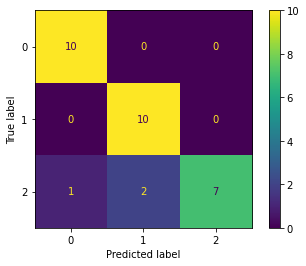

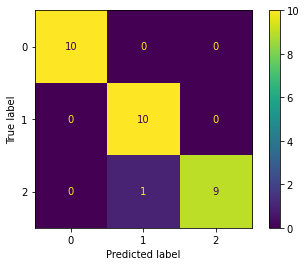

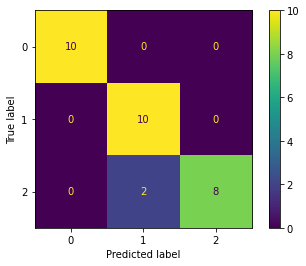

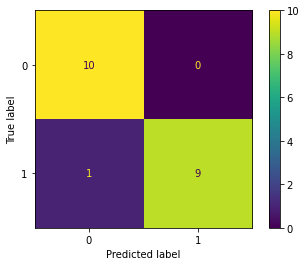

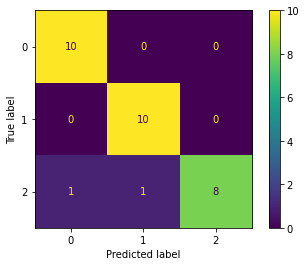

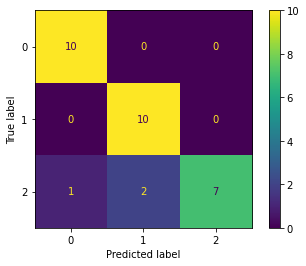

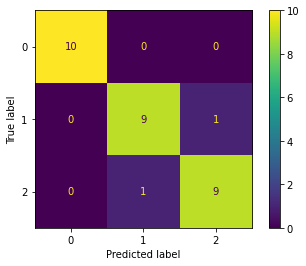

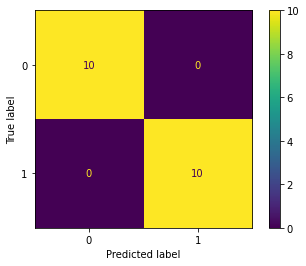

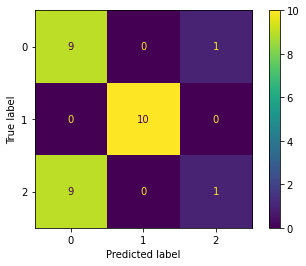

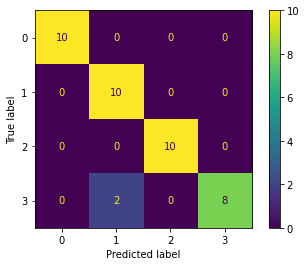

In [53]:
n_exps = 25

ground_truth = [0,1,2,3]

pred_iou = []
for i in range(n_exps):
    print("========== Experiment %s ==========" % str(i+1))
    known_classes = [0,1]
    known_classes_order = []
    
    model = None
    
    retrains = 0
    while len(known_classes) < len(ground_truth) and retrains < 2:
        print("Known classes:", known_classes)
        known_classes_order.append(known_classes.copy())
        
        #feature_idxs = [*range(3,16),*range(22,28)]
        feature_idxs = [*range(3,13),*range(22,28)] # without jitter force
        #feature_idxs = [*range(3,19),*range(22,28)] # with object position
        Xtrain, Ttrain, Xtest, Ttest = make_train_test_data(known_classes, crop_len, feature_idxs)
        print()

        model = train_classifier(Xtrain, Ttrain, len(known_classes))
        print()

        # check classifier on the test data
        classes, probs = model.use(Xtest)

        # make confusion matrix
        cm = sklearn.metrics.confusion_matrix(Ttest, classes)
        disp = ConfusionMatrixDisplay(cm)
        disp.plot()

        novel_classes, dissimilarities = compare_classes(model, Xtrain.shape[-1]//10)
        gated_dissimilarities = [dissimilarities[i] if novel_classes[i] == True \
            else float('inf') for i in range(len(dissimilarities))]
        
        gated_dissimilarities = [gated_dissimilarities[i] if gated_dissimilarities[i] == gated_dissimilarities[i] \
            else float('inf') for i in range(len(gated_dissimilarities))]
        
        if np.min(gated_dissimilarities) == float('inf'):
            print("No novel class found")
            retrains += 1
            print("Retraining (%s)" % retrains)
        else:
            new_class = np.argmin(gated_dissimilarities)
            known_classes.append(new_class)
            retrains = 0

            print("Most novel class:", known_classes[-1])
        print()
        
    print("Known classes:", known_classes)
    known_classes_order.append(known_classes.copy())
    
    feature_idxs = [*range(3,16),*range(22,28)]
    #feature_idxs = [*range(3,13),*range(22,28)] # without jitter force
    #feature_idxs = [*range(3,19),*range(22,28)] # with object position
    Xtrain, Ttrain, Xtest, Ttest = make_train_test_data(known_classes, crop_len, feature_idxs)
    print()

    model = train_classifier(Xtrain, Ttrain, len(known_classes))
    print()

    # check classifier on the test data
    classes, probs = model.use(Xtest)

    # make confusion matrix
    cm = sklearn.metrics.confusion_matrix(Ttest, classes)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()

    novel_classes, dissimilarities = compare_classes(model, Xtrain.shape[-1]//10)
    gated_dissimilarities = [dissimilarities[i] if novel_classes[i] == True \
        else float('inf') for i in range(len(dissimilarities))]
    
    gated_dissimilarities = [gated_dissimilarities[i] if gated_dissimilarities[i] == gated_dissimilarities[i] \
        else float('inf') for i in range(len(gated_dissimilarities))]
    
    if np.min(gated_dissimilarities) != float('inf'):
        new_class = np.argmin(gated_dissimilarities)
        known_classes.append(new_class)
        
    print("Known classes:", known_classes)
    known_classes_order.append(known_classes.copy())
    
    print("Order of acquisition:", known_classes_order)

    pred_iou.append(np.intersect1d(known_classes[2:],ground_truth[2:]).shape[0]/\
                    np.union1d(known_classes[2:],ground_truth[2:]).shape[0])
    print(pred_iou,pred_iou[-1])
    print()
    
print(np.sum(pred_iou)/len(pred_iou))

Same as above except not allowing any retraining (effectively constraining this model to the same behavior as models E-H).

========== Experiment 1 ==========
Known classes: [0, 1]
(1800, 16) (1800,) (200, 16) (200,)
(180, 160) (180,) (20, 160) (20,)
(180, 1, 160) (180,) (20, 1, 160) (20,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.002
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: nan
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0001163482666015625
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Diss

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in double_scalars
/Users/n

Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0
Angle from sim_mean to new_mean: 5.960464477539063e-08
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: inf


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: True

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0001163482666015625
Angle from sim_mean to new_mean: 1.3589859008789062e-05
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.1168032786885246
Outlier ratio: 1.4010264946594533
Dissimilarity from most similar class: 3.6261673609244824
Likely novel class: False

New class: 4
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0
Angle from sim_mean to new_mean: -1.1920928955078125e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: -inf
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: False

No novel class found

Known classes: [0, 1]
(1800, 19) (1800,) (200, 19) (200,)
(180, 190) (180,) (20, 190) (20,)
(180, 1, 190) (180,) (20, 1, 190) (20,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.001
adam: Epoch 100 L

Outlier ratio: 1.2997332914030661
Dissimilarity from most similar class: 0.7921064170587855
Likely novel class: False

New class: 3
Most similar class: 3
Angle from sim_mean to sim_mean+std: 0.2601441740989685
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 4
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.007453501224517822
Angle from sim_mean to new_mean: 0.00015807151794433594
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.02120768658685795
Outlier ratio: 0.7626775697519544
Dissimilarity from most similar class: 7.801654174373903
Likely novel class: False

Known classes: [0, 1, 3]
Order of acquisition: [[0, 1], [0, 1, 3], [0, 1, 3], [0, 1, 3]]
[0.5, 0.5] 0.5

========== Experiment 3 ==========
Known classes: [0, 1]
(1800, 16) (1800,) (200, 16) (200,)
(180, 160) (180,) (20, 160) (20,)
(18

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in double_scalars


Most similar class: 0
Angle from sim_mean to sim_mean+std: 2.562999725341797e-06
Angle from sim_mean to new_mean: 1.1920928955078125e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.046511627906976744
Outlier ratio: 18884.290592783513
Dissimilarity from most similar class: 253615.30773391027
Likely novel class: True

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0013092756271362305
Angle from sim_mean to new_mean: 0.0006543397903442383
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.4997723754893927
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: True

New class: 4
Most similar class: 0


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


Angle from sim_mean to sim_mean+std: 2.562999725341797e-06
Angle from sim_mean to new_mean: 5.960464477539063e-08
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.023255813953488372
Outlier ratio: 0.5142557989690723
Dissimilarity from most similar class: 3.4532179556517035
Likely novel class: False

Most novel class: 2

Known classes: [0, 1, 2]
(2700, 16) (2700,) (300, 16) (300,)
(270, 160) (270,) (30, 160) (30,)
(270, 1, 160) (270,) (30, 1, 160) (30,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.250
adam: Epoch 100 Loss 0.241
adam: Epoch 150 Loss 0.235
adam: Epoch 200 Loss 0.230
adam: Epoch 250 Loss 0.219
adam: Epoch 300 Loss 0.206
adam: Epoch 350 Loss 0.198
adam: Epoch 400 Loss 0.194
adam: Epoch 450 Loss 0.189
adam: Epoch 500 Loss 0.184

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.04787784814834595
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_me

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in double_scalars
/Users/n

Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 4.470348358154297e-06
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: nan
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: False

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 4.470348358154297e-06
Angle from sim_mean to new_mean: 7.092952728271484e-06
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 1.5866666666666667
Outlier ratio: 34.54034391534391
Dissimilarity from most similar class: 1104.8488888888887
Likely novel cl

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in double_scalars
/Users/n

Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0
Angle from sim_mean to new_mean: 5.960464477539063e-08
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: inf


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: True

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 1.7285346984863281e-06
Angle from sim_mean to new_mean: 6.556510925292969e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.3793103448275862
Outlier ratio: 2.7783375314861463
Dissimilarity from most similar class: 28.853745541022594
Likely novel class: True

New class: 4
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: nan
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: False

Most novel class: 3

Known classes: [0, 1, 3]
(2700, 16) (2700,) (300, 16) (300,)
(270, 160) (270,) (30, 160) (30,)
(270, 1, 160) (270,) (30, 1, 160) (30,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.042
adam: Epoch 100 Loss 0.006
adam: Epoch

Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.004219472408294678
Angle from sim_mean to new_mean: 5.537271499633789e-05
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.013123137121950531
Outlier ratio: 5.889974474551615
Dissimilarity from most similar class: 35.00313123856825
Likely novel class: True

New class: 3
Most similar class: 3
Angle from sim_mean to sim_mean+std: 0.21755987405776978
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 4
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.004219472408294678
Angle from sim_mean to new_mean: 1.0669231414794922e-05
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0025285700159624813
Outlier ratio: 1.8460293499141287
Dissimilarity from most similar class: 2.113826811753672
Likely novel class: False

Most novel

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in double_scalars
/Users/n

Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: nan
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: False

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: nan
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: False

New class: 4
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0
Angle from sim_mean to new_mean: -1.1920928955078125e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: -inf
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: False

No novel class found

Known classes: [0, 1]
(1800, 19) (1800,) (200, 19) (200,)
(180, 190) (180,) (20, 190) (20,)
(180, 1, 190) (180,) (20, 1, 190) (20,)

CUDA not ava

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


adam: Epoch 50 Loss 0.001
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 5.8650970458984375e-05
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 8.982419967651367e-05
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 0
Angle from sim_mean to sim_mean+std: 5.8650970458984375e-05
Angle from sim_mean to new_mean: 1.1920928955078

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in double_scalars
/Users/n

Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0
Angle from sim_mean to new_mean: -1.1920928955078125e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: -inf


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: False

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 2.980232238769531e-07
Angle from sim_mean to new_mean: 5.960464477539063e-08
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.2
Outlier ratio: 2.1470588235294117
Dissimilarity from most similar class: 8.759999999999998
Likely novel class: False

New class: 4
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: nan
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: False

No novel class found

Known classes: [0, 1]
(1800, 19) (1800,) (200, 19) (200,)
(180, 190) (180,) (20, 190) (20,)
(180, 1, 190) (180,) (20, 1, 190) (20,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.001
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/sklearn/metrics/_plot/confusion_matrix.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Angle from sim_mean to sim_mean+std: 0.0022722482681274414
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 1.2695789337158203e-05
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0022722482681274414
Angle from sim_mean to new_mean: 5.960464477539063e-08
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 2.6231572320444888e-05
Outlier ratio: 4.035947998516472
Dissimilarity from most similar class: 0.1702667133201761
Likely novel class: False

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 1.269578933715820

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in double_scalars
/Users/n

Angle from sim_mean to sim_mean+std: 1.1920928955078125e-07
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: nan
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: False

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 1.1920928955078125e-07
Angle from sim_mean to new_mean: 5.960464477539063e-08
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.5
Outlier ratio: 13.848484848484848
Dissimilarity from most similar class: 114.25
Likely novel class: True

New class: 4
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0
Angle from sim_mean to new_mean: -1.1920928955078125e-07
Angl

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


adam: Epoch 50 Loss 0.036
adam: Epoch 100 Loss 0.004
adam: Epoch 150 Loss 0.002
adam: Epoch 200 Loss 0.001
adam: Epoch 250 Loss 0.001
adam: Epoch 300 Loss 0.001
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.037425458431243896
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.002529919147491455
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.037425458431243896
Angle from sim_mean to new_mean: 0.000191867351531982

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in double_scalars


Most similar class: 0
Angle from sim_mean to sim_mean+std: 3.6954879760742188e-06
Angle from sim_mean to new_mean: 1.1324882507324219e-06
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.3064516129032258
Outlier ratio: 12863.917600352219
Dissimilarity from most similar class: 1047027.1829799688
Likely novel class: True

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.023270010948181152
Angle from sim_mean to new_mean: 0.11363750696182251
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 4.8834316070962025
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: True

New class: 4
Most similar class: 0


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


Angle from sim_mean to sim_mean+std: 3.6954879760742188e-06
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 0.5323981295925183
Dissimilarity from most similar class: 0.0
Likely novel class: False

Known classes: [0, 1, 2]
Order of acquisition: [[0, 1], [0, 1], [0, 1, 2]]
[0.5, 0.5, 0.6666666666666666, 0.5, 0.5, 1.0, 0.5, 0.5, 0.5, 0.5] 0.5

========== Experiment 11 ==========
Known classes: [0, 1]
(1800, 16) (1800,) (200, 16) (200,)
(180, 160) (180,) (20, 160) (20,)
(180, 1, 160) (180,) (20, 1, 160) (20,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.001
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 2.9802322

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in double_scalars
/Users/n

Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.006295919418334961
Angle from sim_mean to new_mean: 1.8477439880371094e-05
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.002934827886545234
Outlier ratio: 3.7282403762184733
Dissimilarity from most similar class: 7.089863202023409
Likely novel class: False

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0
Angle from sim_mean to new_mean: 0.019765198230743408
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: inf
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: True

New class: 4
Most similar class: 0


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


Angle from sim_mean to sim_mean+std: 0.006295919418334961
Angle from sim_mean to new_mean: 6.079673767089844e-06
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0009656530465406899
Outlier ratio: 0.2520429272677304
Dissimilarity from most similar class: 0.15770553752117888
Likely novel class: False

No novel class found

Known classes: [0, 1, 4]
(2700, 19) (2700,) (300, 19) (300,)
(270, 190) (270,) (30, 190) (30,)
(270, 1, 190) (270,) (30, 1, 190) (30,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.098
adam: Epoch 100 Loss 0.014
adam: Epoch 150 Loss 0.006
adam: Epoch 200 Loss 0.003
adam: Epoch 250 Loss 0.002
adam: Epoch 300 Loss 0.002
adam: Epoch 350 Loss 0.001
adam: Epoch 400 Loss 0.001
adam: Epoch 450 Loss 0.001
adam: Epoch 500 Loss 0.001

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.002901017665863037
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to si

Angle from sim_mean to sim_mean+std: 0.00820392370223999
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

Known classes: [0, 1, 4, 3]
Order of acquisition: [[0, 1], [0, 1, 4], [0, 1, 4, 3], [0, 1, 4, 3]]
[0.5, 0.5, 0.6666666666666666, 0.5, 0.5, 1.0, 0.5, 0.5, 0.5, 0.5, 0.3333333333333333, 0.3333333333333333] 0.3333333333333333

========== Experiment 13 ==========
Known classes: [0, 1]
(1800, 16) (1800,) (200, 16) (200,)
(180, 160) (180,) (20, 160) (20,)
(180, 1, 160) (180,) (20, 1, 160) (20,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.001
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most sim

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in double_scalars


Angle from sim_mean to sim_mean+std: 2.980232238769531e-07
Angle from sim_mean to new_mean: -1.1920928955078125e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: -0.4
Outlier ratio: 1.62916486369537
Dissimilarity from most similar class: -301.2
Likely novel class: False

No novel class found

Known classes: [0, 1]
(1800, 19) (1800,) (200, 19) (200,)
(180, 190) (180,) (20, 190) (20,)
(180, 1, 190) (180,) (20, 1, 190) (20,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.001
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 8.505582809448242e-05
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in double_scalars


Most similar class: 0
Angle from sim_mean to sim_mean+std: 8.505582809448242e-05
Angle from sim_mean to new_mean: 4.172325134277344e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.004905395935529082
Outlier ratio: 953.9103708385151
Dissimilarity from most similar class: 804.2212314414811
Likely novel class: True

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0006900429725646973
Angle from sim_mean to new_mean: 0.002543151378631592
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 3.6854971063315194
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: True

New class: 4
Most similar class: 0


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


Angle from sim_mean to sim_mean+std: 8.505582809448242e-05
Angle from sim_mean to new_mean: 5.960464477539063e-08
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.000700770847932726
Outlier ratio: 136.16219037328494
Dissimilarity from most similar class: 16.399343131684514
Likely novel class: False

Known classes: [0, 1, 2]
Order of acquisition: [[0, 1], [0, 1], [0, 1, 2]]
[0.5, 0.5, 0.6666666666666666, 0.5, 0.5, 1.0, 0.5, 0.5, 0.5, 0.5, 0.3333333333333333, 0.3333333333333333, 0.5] 0.5

========== Experiment 14 ==========
Known classes: [0, 1]
(1800, 16) (1800,) (200, 16) (200,)
(180, 160) (180,) (20, 160) (20,)
(180, 1, 160) (180,) (20, 1, 160) (20,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.001
adam: Epoch 100 Loss 0.000
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500

Outlier ratio: 0.8940355827259187
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 2.384185791015625e-07
Angle from sim_mean to new_mean: 1.1920928955078125e-06
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 5.0
Outlier ratio: 102.47945205479452
Dissimilarity from most similar class: 18702.5
Likely novel class: True

New class: 4
Most similar class: 0
Angle from sim_mean to sim_mean+std: 2.86102294921875e-06
Angle from sim_mean to new_mean: 5.960464477539063e-08
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.020833333333333332
Outlier ratio: 1.5179873030801783
Dissimilarity from most similar class: 16.812499999999996
Likely novel class: False

Most novel class: 3

Known classes: [0, 1, 3]
(2700, 16) (2700,) (300, 16) (300,)
(270, 160) (270,) (30, 160) (30,)
(270, 1, 160) (270,) (30, 1, 160) (30,)

CUDA not available. Defaulting to CPU.
160 16 8 19
1

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in double_scalars
/Users/n

Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: nan
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: False

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 5.960464477539063e-08
Angle from sim_mean to new_mean: 5.960464477539063e-08
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 1.0
Outlier ratio: 35.81818181818182
Dissimilarity from most similar class: 394.0
Likely novel class: True

New class: 4
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0
Angle from sim_mean to new_mean: 5.960464477539063e-08
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: inf
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: True

Most novel class: 3

Known classes: [0, 1, 3]
(2700, 16) (2700,) (300, 16) (300,)
(270, 160) (270,) (30, 160) (30,)
(270

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


adam: Epoch 50 Loss 0.038
adam: Epoch 100 Loss 0.005
adam: Epoch 150 Loss 0.002
adam: Epoch 200 Loss 0.001
adam: Epoch 250 Loss 0.001
adam: Epoch 300 Loss 0.001
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.07836049795150757
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.005986452102661133
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.07836049795150757
Angle from sim_mean to new_mean: 0.0007590055465698242


adam: Epoch 50 Loss 0.102
adam: Epoch 100 Loss 0.036
adam: Epoch 150 Loss 0.022
adam: Epoch 200 Loss 0.018
adam: Epoch 250 Loss 0.015
adam: Epoch 300 Loss 0.010
adam: Epoch 350 Loss 0.011
adam: Epoch 400 Loss 0.010
adam: Epoch 450 Loss 0.013
adam: Epoch 500 Loss 0.008

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.008226752281188965
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.010330021381378174
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 2
Angle from sim_mean to sim_mean+std: 0.012734532356262207
Angle from sim_mean to new_mean: 0.0
Angle from sim_m

adam: Epoch 50 Loss 0.002
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.001
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 2.092123031616211e-05
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 8.940696716308594e-06
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 0
Angle from sim_mean to sim_mean+std: 2.092123031616211e-05
Angle from sim_mean to new_mean: 1.192092895507812

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in double_scalars
/Users/n

Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0
Angle from sim_mean to new_mean: 9.5367431640625e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: inf


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: True

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.26806318759918213
Angle from sim_mean to new_mean: 1.0740638747811317
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 4.006756333835407
Outlier ratio: 3.6743233102729542
Dissimilarity from most similar class: 1096.1855308627385
Likely novel class: True

New class: 4
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: nan
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: False

Most novel class: 3

Known classes: [0, 1, 3]
(2700, 16) (2700,) (300, 16) (300,)
(270, 160) (270,) (30, 160) (30,)
(270, 1, 160) (270,) (30, 1, 160) (30,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.042
adam: Epoch 100 Loss 0.006
adam: Epoch 150 Lo

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in double_scalars


Most similar class: 0
Angle from sim_mean to sim_mean+std: 8.046627044677734e-06
Angle from sim_mean to new_mean: 3.5762786865234375e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.044444444444444446
Outlier ratio: 8988.23438046053
Dissimilarity from most similar class: 76205.43209876544
Likely novel class: True

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.006732821464538574
Angle from sim_mean to new_mean: 0.005358636379241943
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.795897590254785
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: True

New class: 4
Most similar class: 0


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


Angle from sim_mean to sim_mean+std: 8.046627044677734e-06
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.120529647031414
Dissimilarity from most similar class: 0.0
Likely novel class: False

Most novel class: 2

Known classes: [0, 1, 2]
(2700, 16) (2700,) (300, 16) (300,)
(270, 160) (270,) (30, 160) (30,)
(270, 1, 160) (270,) (30, 1, 160) (30,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.251
adam: Epoch 100 Loss 0.242
adam: Epoch 150 Loss 0.231
adam: Epoch 200 Loss 0.216
adam: Epoch 250 Loss 0.205
adam: Epoch 300 Loss 0.199
adam: Epoch 350 Loss 0.196
adam: Epoch 400 Loss 0.193
adam: Epoch 450 Loss 0.188
adam: Epoch 500 Loss 0.183

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0006389021873474121
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from

Outlier ratio: 12.126472278065332
Dissimilarity from most similar class: 43.02122711639889
Likely novel class: True

New class: 3
Most similar class: 3
Angle from sim_mean to sim_mean+std: 0.3222540020942688
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 4
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0018398761749267578
Angle from sim_mean to new_mean: 1.6570091247558594e-05
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.009006090449656601
Outlier ratio: 1.4829938779780045
Dissimilarity from most similar class: 5.945622925587044
Likely novel class: False

Most novel class: 2

Known classes: [0, 1, 3, 2]
(3600, 19) (3600,) (400, 19) (400,)
(360, 190) (360,) (40, 190) (40,)
(360, 1, 190) (360,) (40, 1, 190) (40,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in double_scalars


Most similar class: 0
Angle from sim_mean to sim_mean+std: 5.960464477539063e-08
Angle from sim_mean to new_mean: 5.960464477539063e-08
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 1.0
Outlier ratio: 517.9772727272727
Dissimilarity from most similar class: 22791.0
Likely novel class: True

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.00031507015228271484
Angle from sim_mean to new_mean: 1.233816146850586e-05
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.03916004540295119
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: True

New class: 4
Most similar class: 0


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


Angle from sim_mean to sim_mean+std: 5.960464477539063e-08
Angle from sim_mean to new_mean: -1.1920928955078125e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: -2.0
Outlier ratio: 14.818181818181818
Dissimilarity from most similar class: -1304.0
Likely novel class: False

Most novel class: 2

Known classes: [0, 1, 2]
(2700, 16) (2700,) (300, 16) (300,)
(270, 160) (270,) (30, 160) (30,)
(270, 1, 160) (270,) (30, 1, 160) (30,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.250
adam: Epoch 100 Loss 0.240
adam: Epoch 150 Loss 0.231
adam: Epoch 200 Loss 0.220
adam: Epoch 250 Loss 0.208
adam: Epoch 300 Loss 0.196
adam: Epoch 350 Loss 0.188
adam: Epoch 400 Loss 0.176
adam: Epoch 450 Loss 0.164
adam: Epoch 500 Loss 0.158

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.04535543918609619
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio

Angle from sim_mean to sim_mean+std: 0.011764824390411377
Angle from sim_mean to new_mean: 0.0004070401191711426
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.03459806161687295
Outlier ratio: 1.57695868210493
Dissimilarity from most similar class: 34.330475765537365
Likely novel class: True

Most novel class: 2

Known classes: [0, 1, 2, 2]
(3600, 19) (3600,) (400, 19) (400,)
(360, 190) (360,) (40, 190) (40,)
(360, 1, 190) (360,) (40, 1, 190) (40,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.045
adam: Epoch 100 Loss 0.026
adam: Epoch 150 Loss 0.020
adam: Epoch 200 Loss 0.017
adam: Epoch 250 Loss 0.016
adam: Epoch 300 Loss 0.014
adam: Epoch 350 Loss 0.012
adam: Epoch 400 Loss 0.009
adam: Epoch 450 Loss 0.008
adam: Epoch 500 Loss 0.007

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.005734384059906006
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_me

Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 3
Most similar class: 3
Angle from sim_mean to sim_mean+std: 0.2764888405799866
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 4
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.020450949668884277
Angle from sim_mean to new_mean: 0.00018537044525146484
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.009064148523797033
Outlier ratio: 1.3591699585666481
Dissimilarity from most similar class: 6.642017725726545
Likely novel class: False

Known classes: [0, 1, 2, 3]
Order of acquisition: [[0, 1], [0, 1, 2], [0, 1, 2, 3], [0, 1, 2, 3]]
[0.5, 0.5, 0.6666666666666666, 0.5, 0.5, 1.0, 0.5, 0.5, 0.5, 0.5, 0.3333333333333333, 0.3333333333333333, 0.5, 0.3333333333333333, 0.5, 0.5, 1.0, 0.3333333333333333, 

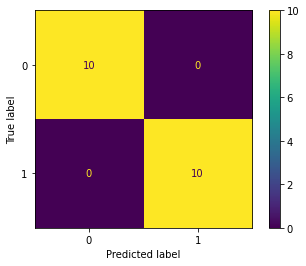

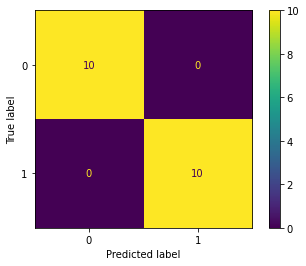

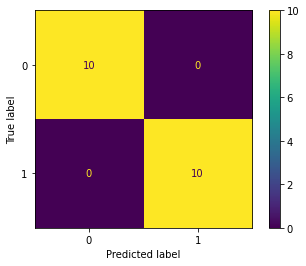

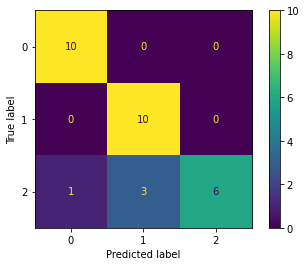

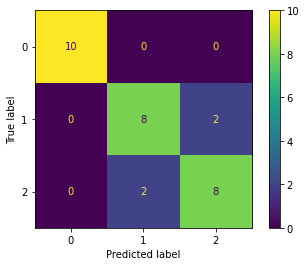

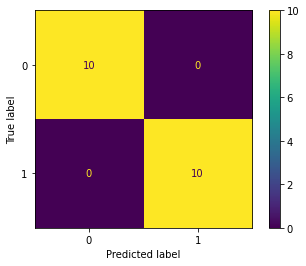

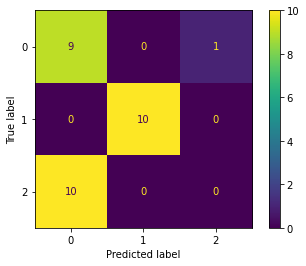

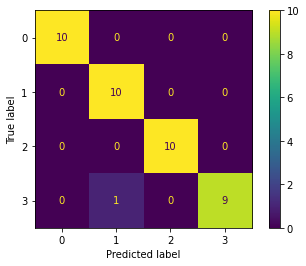

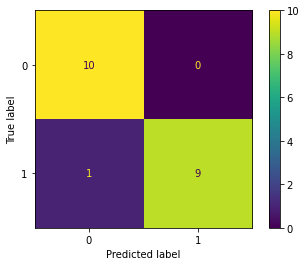

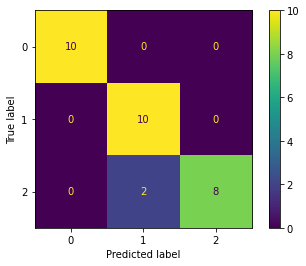

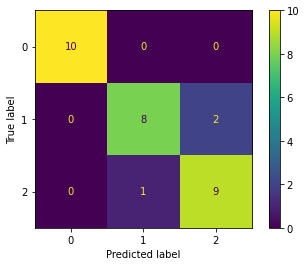

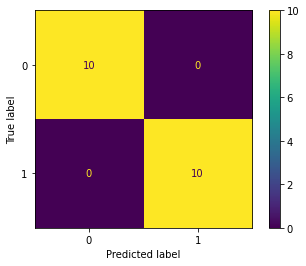

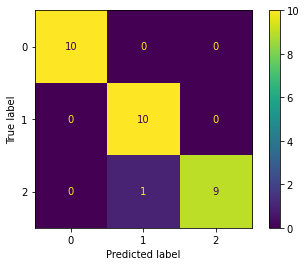

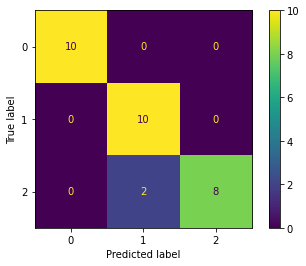

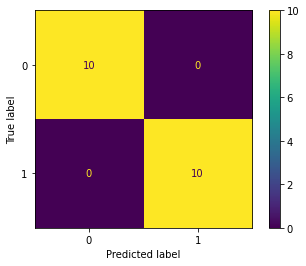

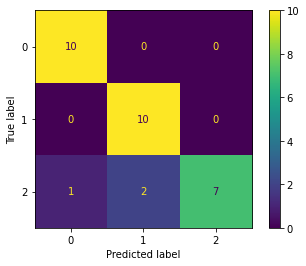

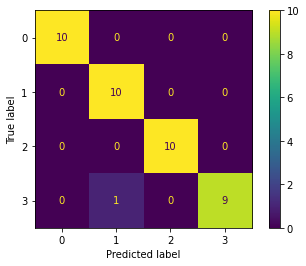

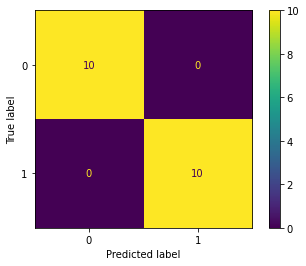

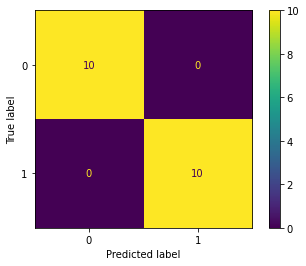

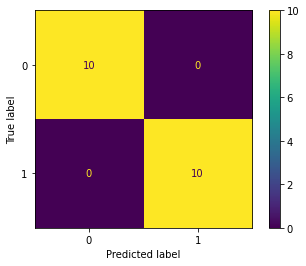

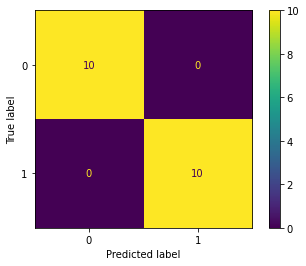

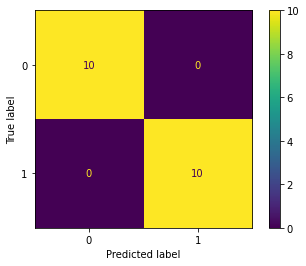

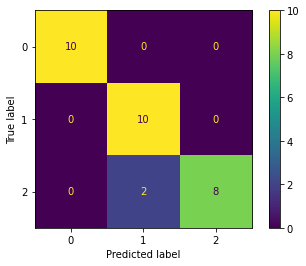

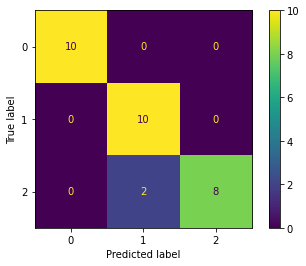

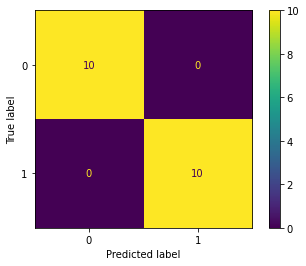

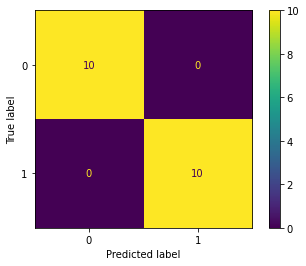

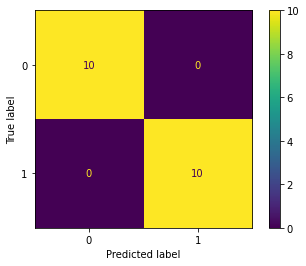

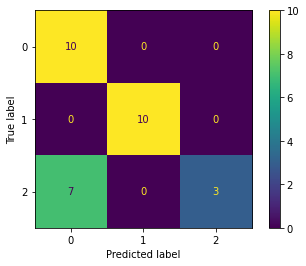

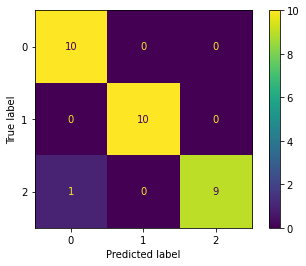

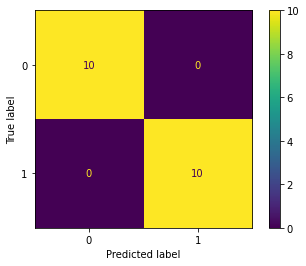

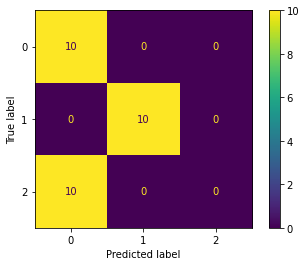

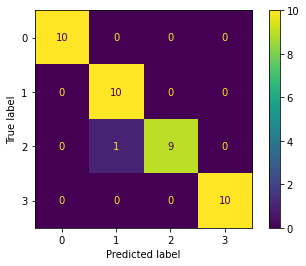

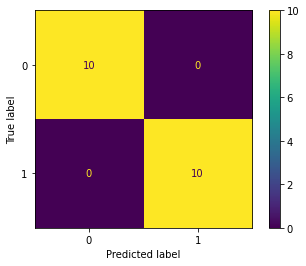

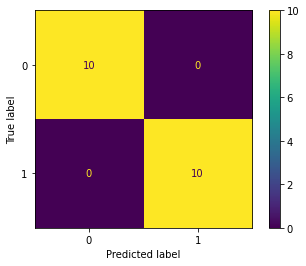

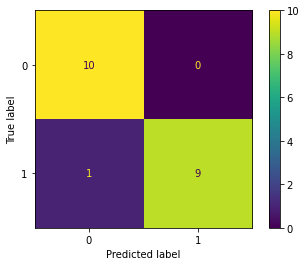

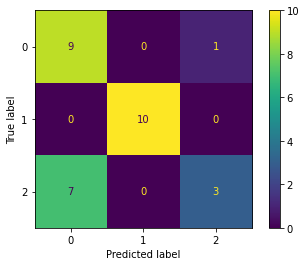

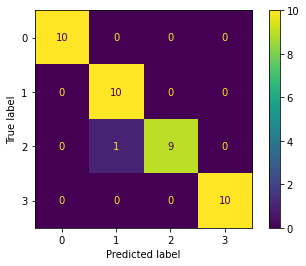

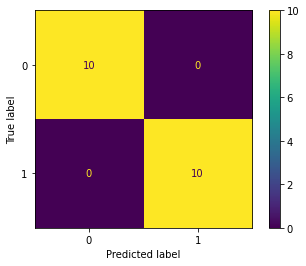

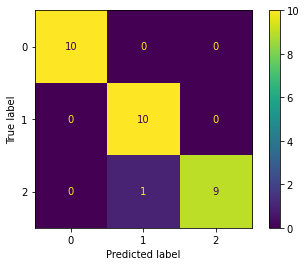

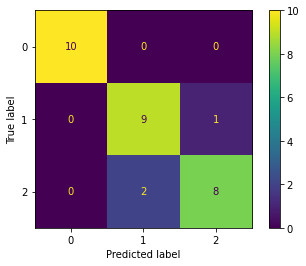

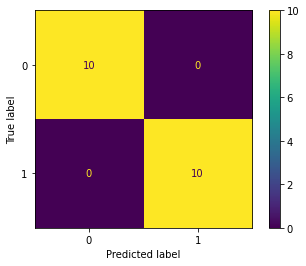

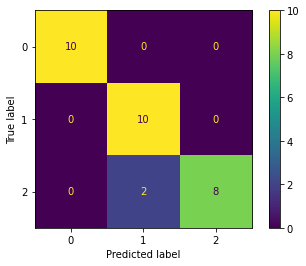

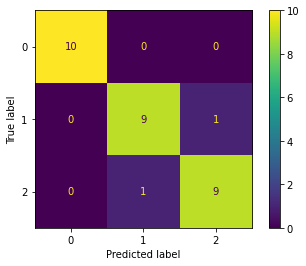

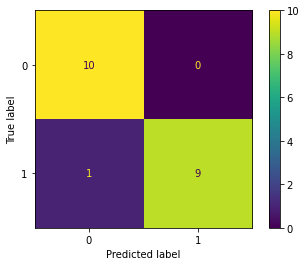

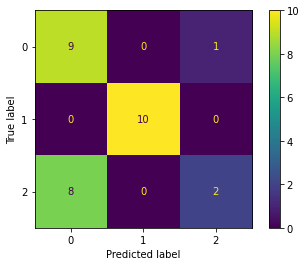

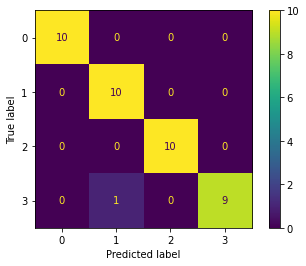

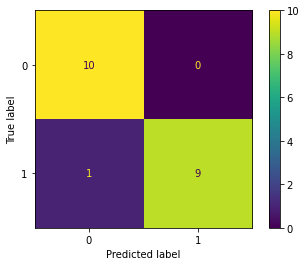

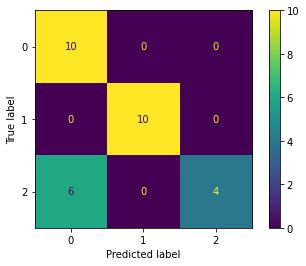

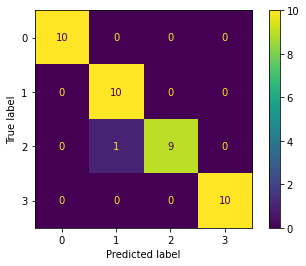

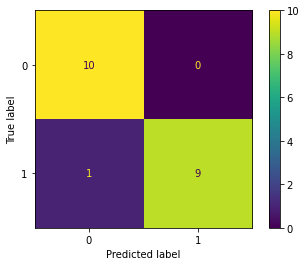

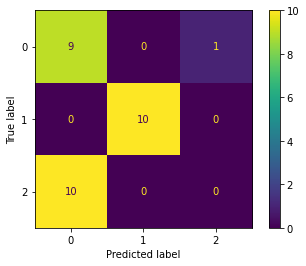

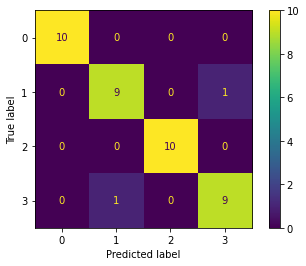

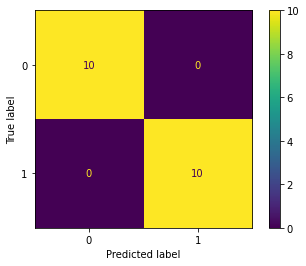

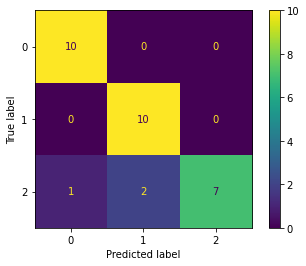

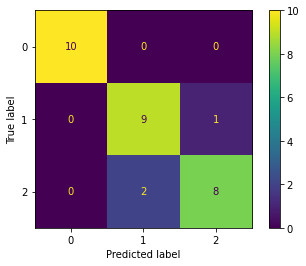

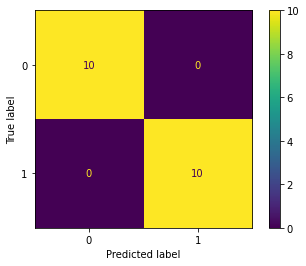

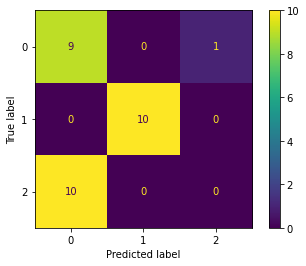

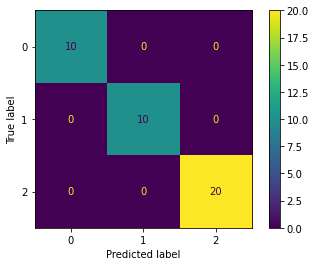

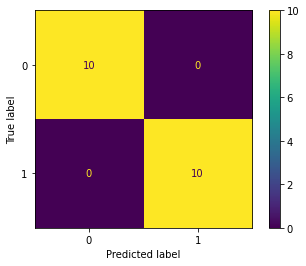

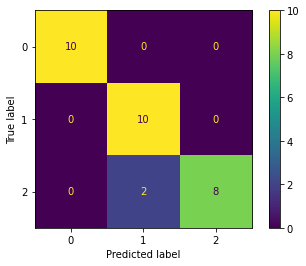

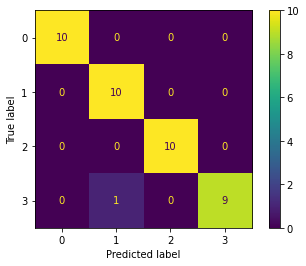

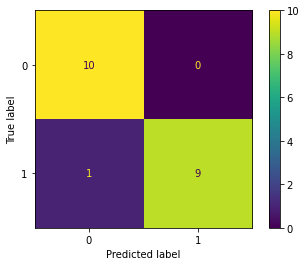

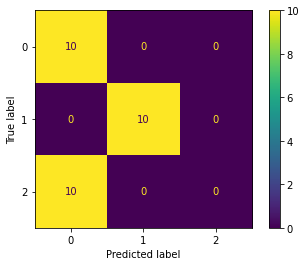

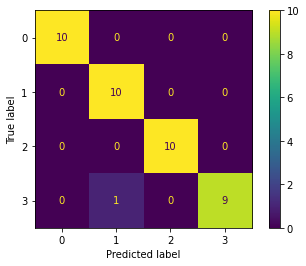

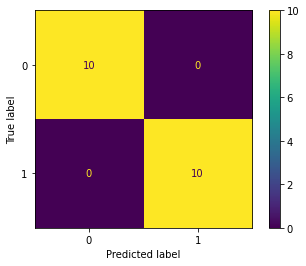

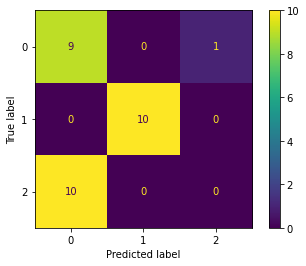

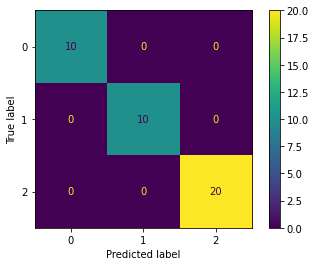

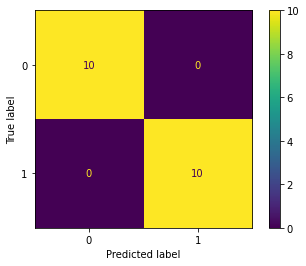

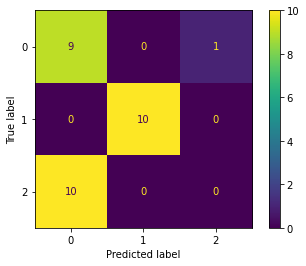

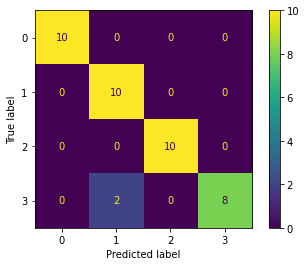

In [54]:
n_exps = 25

ground_truth = [0,1,2,3]

pred_iou = []
for i in range(n_exps):
    print("========== Experiment %s ==========" % str(i+1))
    known_classes = [0,1]
    known_classes_order = []
    
    model = None
    
    retrains = 0
    while len(known_classes) < len(ground_truth) and retrains < 1:
        print("Known classes:", known_classes)
        known_classes_order.append(known_classes.copy())
        
        #feature_idxs = [*range(3,16),*range(22,28)]
        feature_idxs = [*range(3,13),*range(22,28)] # without jitter force
        #feature_idxs = [*range(3,19),*range(22,28)] # with object position
        Xtrain, Ttrain, Xtest, Ttest = make_train_test_data(known_classes, crop_len, feature_idxs)
        print()

        model = train_classifier(Xtrain, Ttrain, len(known_classes))
        print()

        # check classifier on the test data
        classes, probs = model.use(Xtest)

        # make confusion matrix
        cm = sklearn.metrics.confusion_matrix(Ttest, classes)
        disp = ConfusionMatrixDisplay(cm)
        disp.plot()

        novel_classes, dissimilarities = compare_classes(model, Xtrain.shape[-1]//10)
        gated_dissimilarities = [dissimilarities[i] if novel_classes[i] == True \
            else float('inf') for i in range(len(dissimilarities))]
        
        gated_dissimilarities = [gated_dissimilarities[i] if gated_dissimilarities[i] == gated_dissimilarities[i] \
            else float('inf') for i in range(len(gated_dissimilarities))]
        
        if np.min(gated_dissimilarities) == float('inf'):
            print("No novel class found")
            retrains += 1
            #print("Retraining (%s)" % retrains)
        else:
            new_class = np.argmin(gated_dissimilarities)
            known_classes.append(new_class)
            retrains = 0

            print("Most novel class:", known_classes[-1])
        print()
        
    print("Known classes:", known_classes)
    known_classes_order.append(known_classes.copy())
    
    feature_idxs = [*range(3,16),*range(22,28)]
    #feature_idxs = [*range(3,13),*range(22,28)] # without jitter force
    #feature_idxs = [*range(3,19),*range(22,28)] # with object position
    Xtrain, Ttrain, Xtest, Ttest = make_train_test_data(known_classes, crop_len, feature_idxs)
    print()

    model = train_classifier(Xtrain, Ttrain, len(known_classes))
    print()

    # check classifier on the test data
    classes, probs = model.use(Xtest)

    # make confusion matrix
    cm = sklearn.metrics.confusion_matrix(Ttest, classes)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()

    novel_classes, dissimilarities = compare_classes(model, Xtrain.shape[-1]//10)
    gated_dissimilarities = [dissimilarities[i] if novel_classes[i] == True \
        else float('inf') for i in range(len(dissimilarities))]
    
    gated_dissimilarities = [gated_dissimilarities[i] if gated_dissimilarities[i] == gated_dissimilarities[i] \
        else float('inf') for i in range(len(gated_dissimilarities))]
    
    if np.min(gated_dissimilarities) != float('inf'):
        new_class = np.argmin(gated_dissimilarities)
        known_classes.append(new_class)
        
    print("Known classes:", known_classes)
    known_classes_order.append(known_classes.copy())
    
    print("Order of acquisition:", known_classes_order)

    pred_iou.append(np.intersect1d(known_classes[2:],ground_truth[2:]).shape[0]/\
                    np.union1d(known_classes[2:],ground_truth[2:]).shape[0])
    print(pred_iou,pred_iou[-1])
    print()
    
print(np.sum(pred_iou)/len(pred_iou))